In [1]:
from getdist import plots 
from getdist.mcsamples import loadMCSamples
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from copy import copy

from pathlib import Path

%matplotlib inline

In [2]:
PROJECT_NAME = "gdm_step"
PROJECT_DIR = Path.cwd() / PROJECT_NAME
CHAIN_DIR = PROJECT_DIR / "chains/"
GDM_DATA_PATH = CHAIN_DIR/PROJECT_NAME
PLA_DATA_PATH = Path.cwd() / "data/plkHM/base_plikHM_TTTEEE_lowl_lowE_lensing"
gdm_samples = loadMCSamples(str(GDM_DATA_PATH), settings={'ignore_rows':0.3})
pla_samples = loadMCSamples(str(PLA_DATA_PATH), settings={'ignore_rows':0.3})


/home/mcmeiers/Projects/gdm_cosmology/workspace/gdm_step/chains/gdm_step.1.txt
Removed 0.3 as burn in


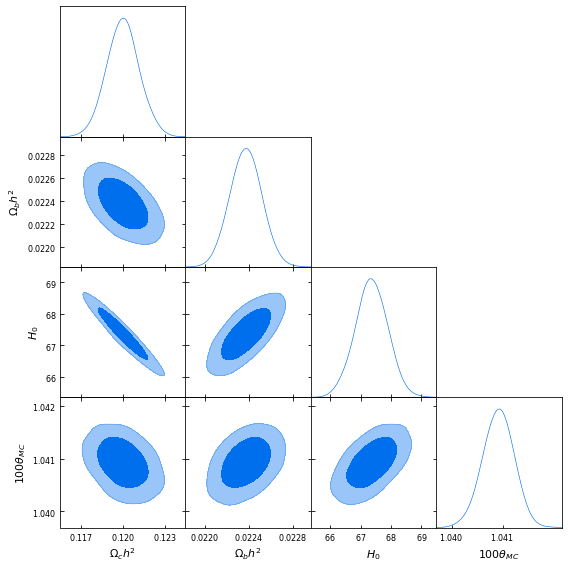

In [3]:
g = plots.get_subplot_plotter()
g.triangle_plot([pla_samples], ['omegach2','omegabh2','H0','theta'],filled=True)

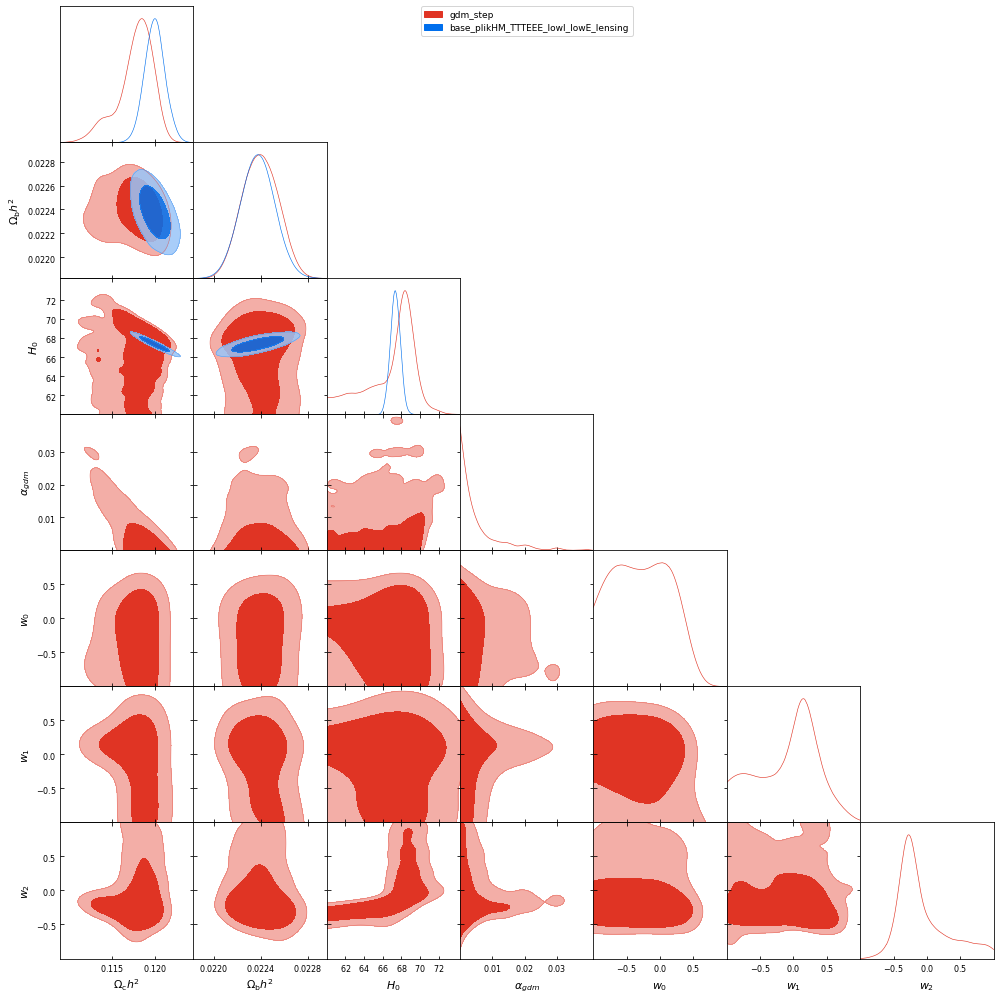

In [5]:
g = plots.get_subplot_plotter()
g.triangle_plot([gdm_samples,pla_samples], ['omega_cdm','omega_b','H0', 'gdm_alpha','w_0','w_1','w_2'],filled=True)

In [5]:
g = plots.get_subplot_plotter()
g.triangle_plot([gdm_samples,pla_samples], ['z_reio'],filled=True)

Exception: parameter name not found: z_reio

In [6]:
best_fit_sample = gdm_samples.getParamSampleDict(np.argmin(gdm_samples.loglikes))

In [9]:
gdm_full_samples = loadMCSamples(str(GDM_DATA_PATH))
chains = np.split(gdm_full_samples.samples,gdm_full_samples.chain_offsets[1:-1])
chains_weights = np.split(gdm_full_samples.weights.astype(int),gdm_full_samples.chain_offsets[1:-1])
traces = [np.repeat(chain,weights,axis=0) for chain, weights in zip(chains,chains_weights)]

/home/mcmeiers/Projects/gdm_cosmology/workspace/gdm_step/chains/gdm_step.1.txt
Removed no burn in


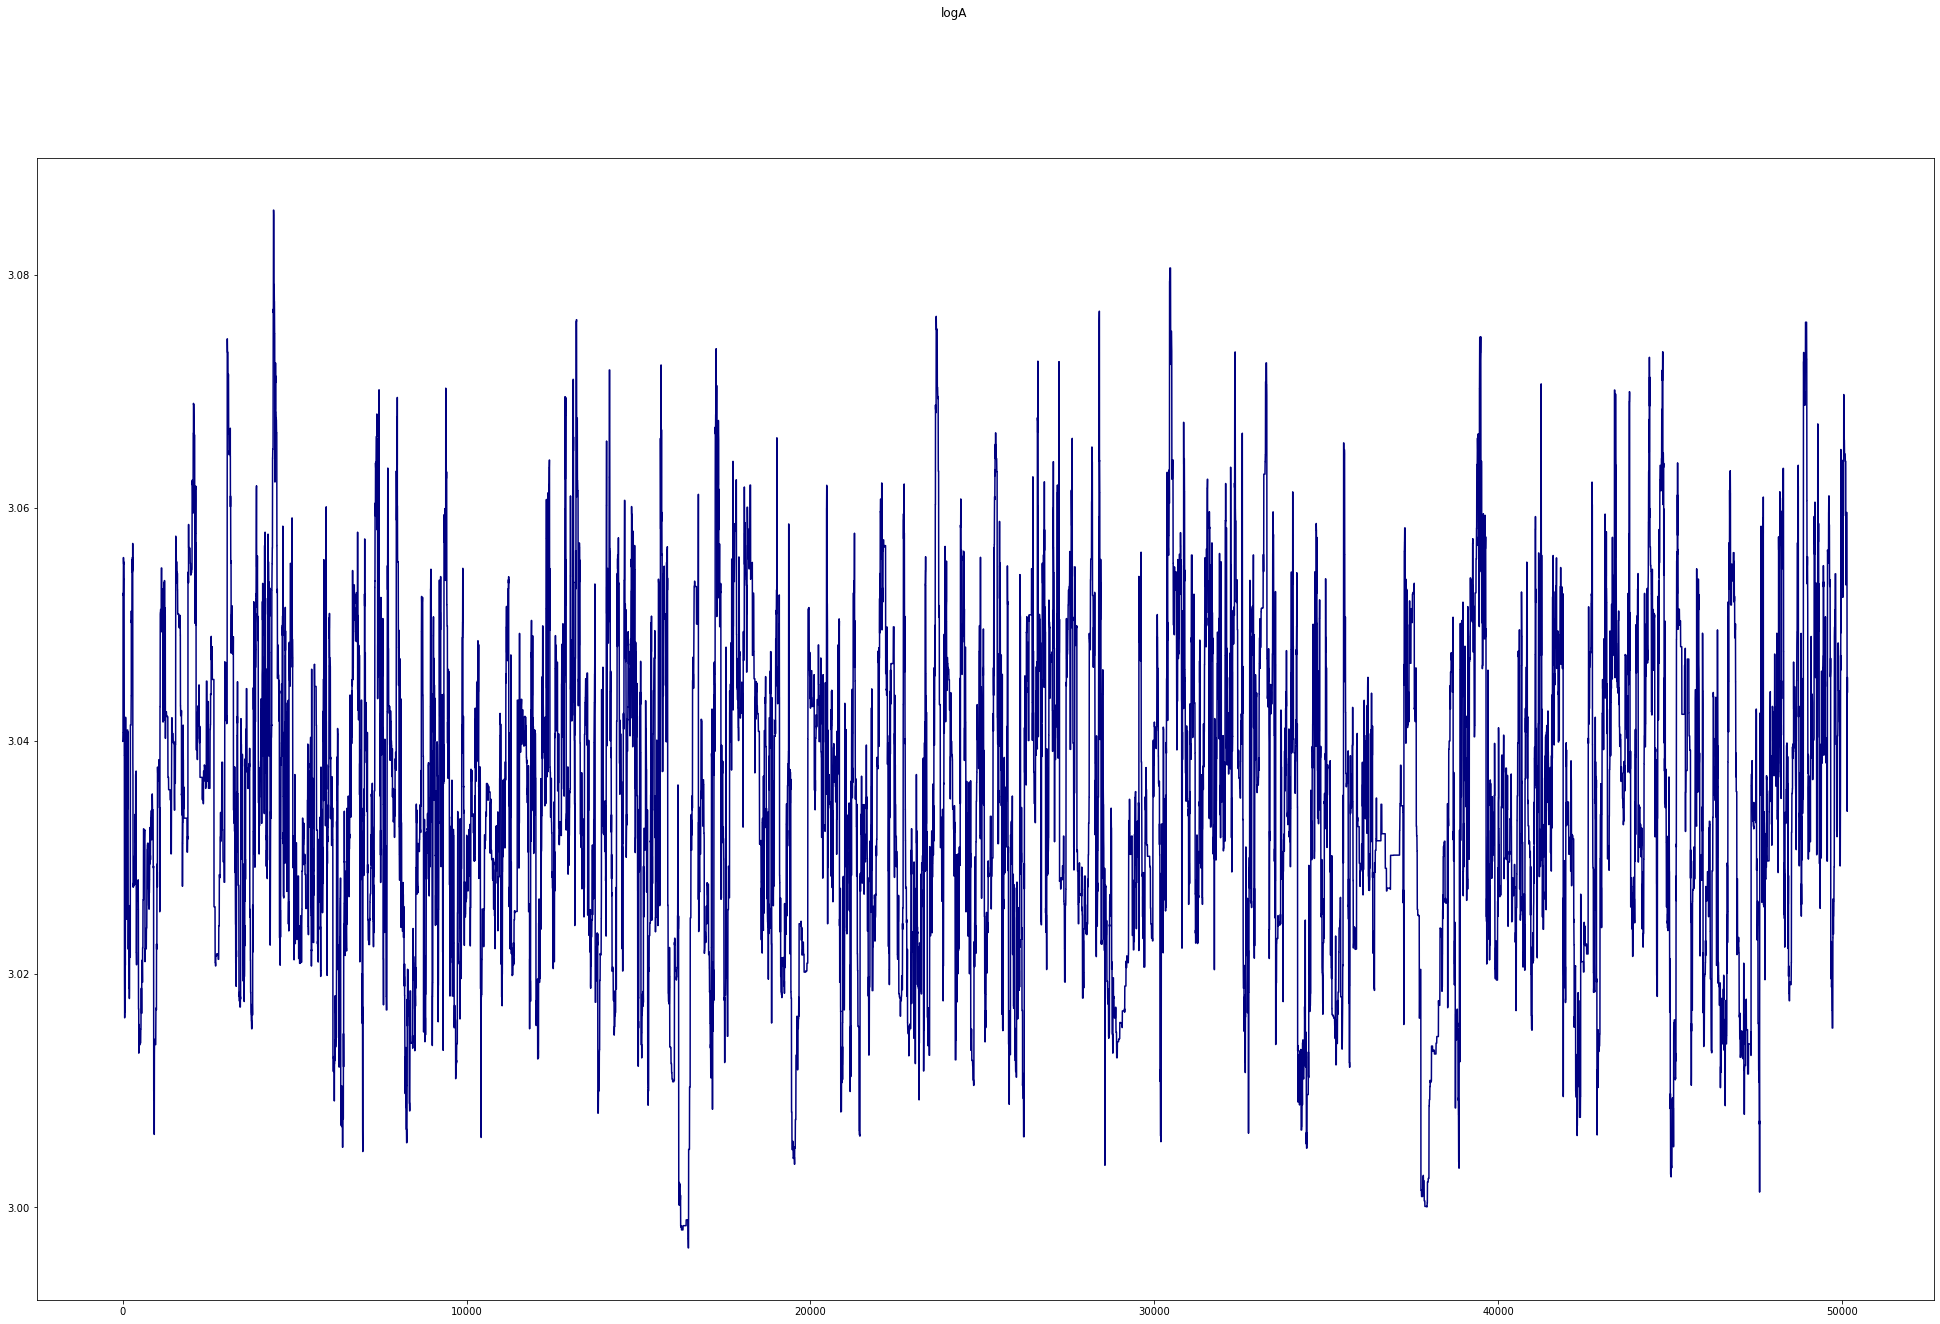

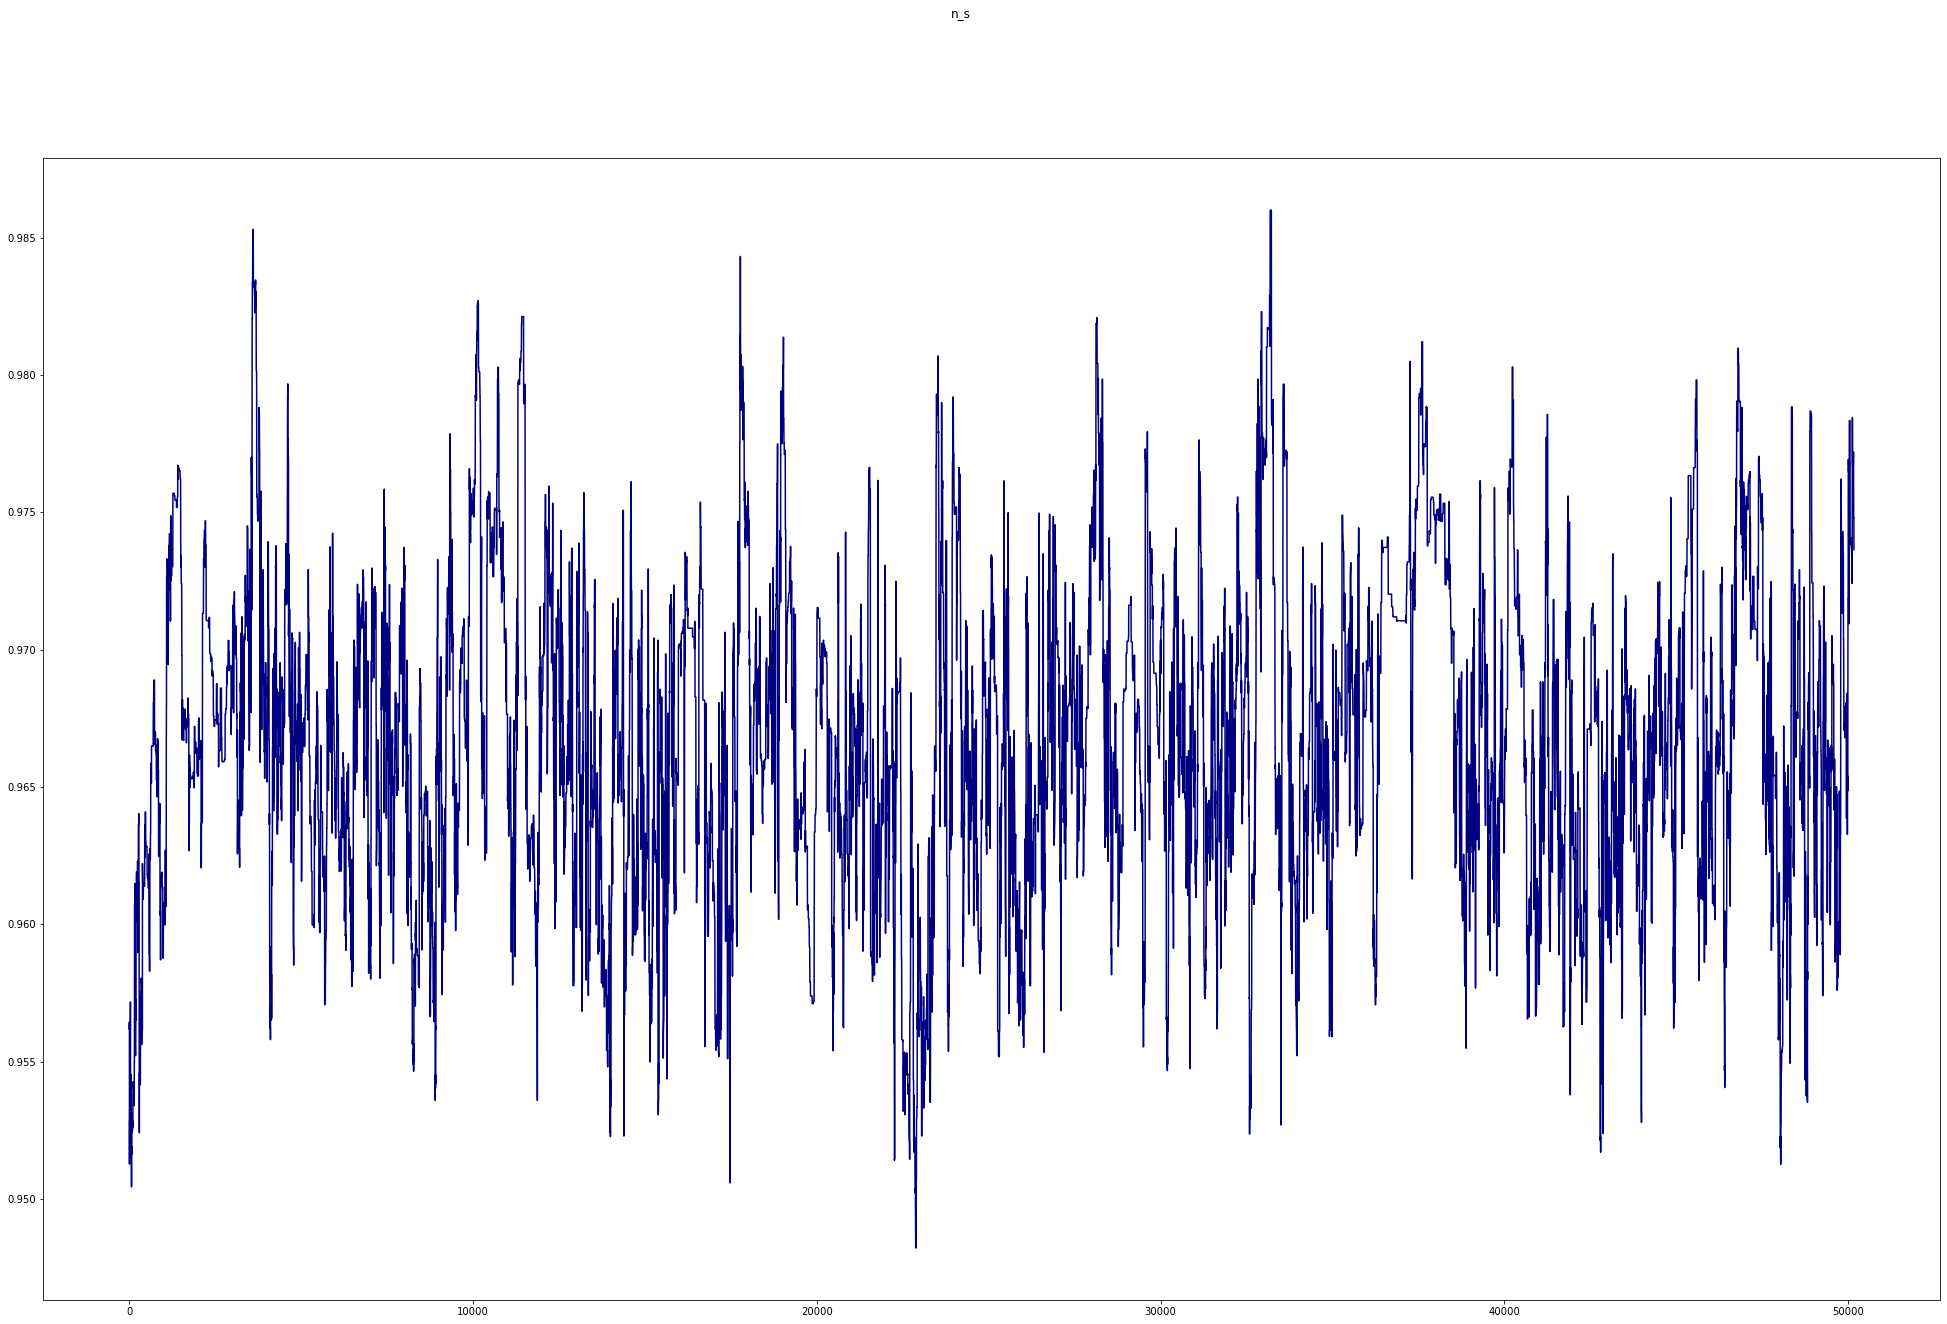

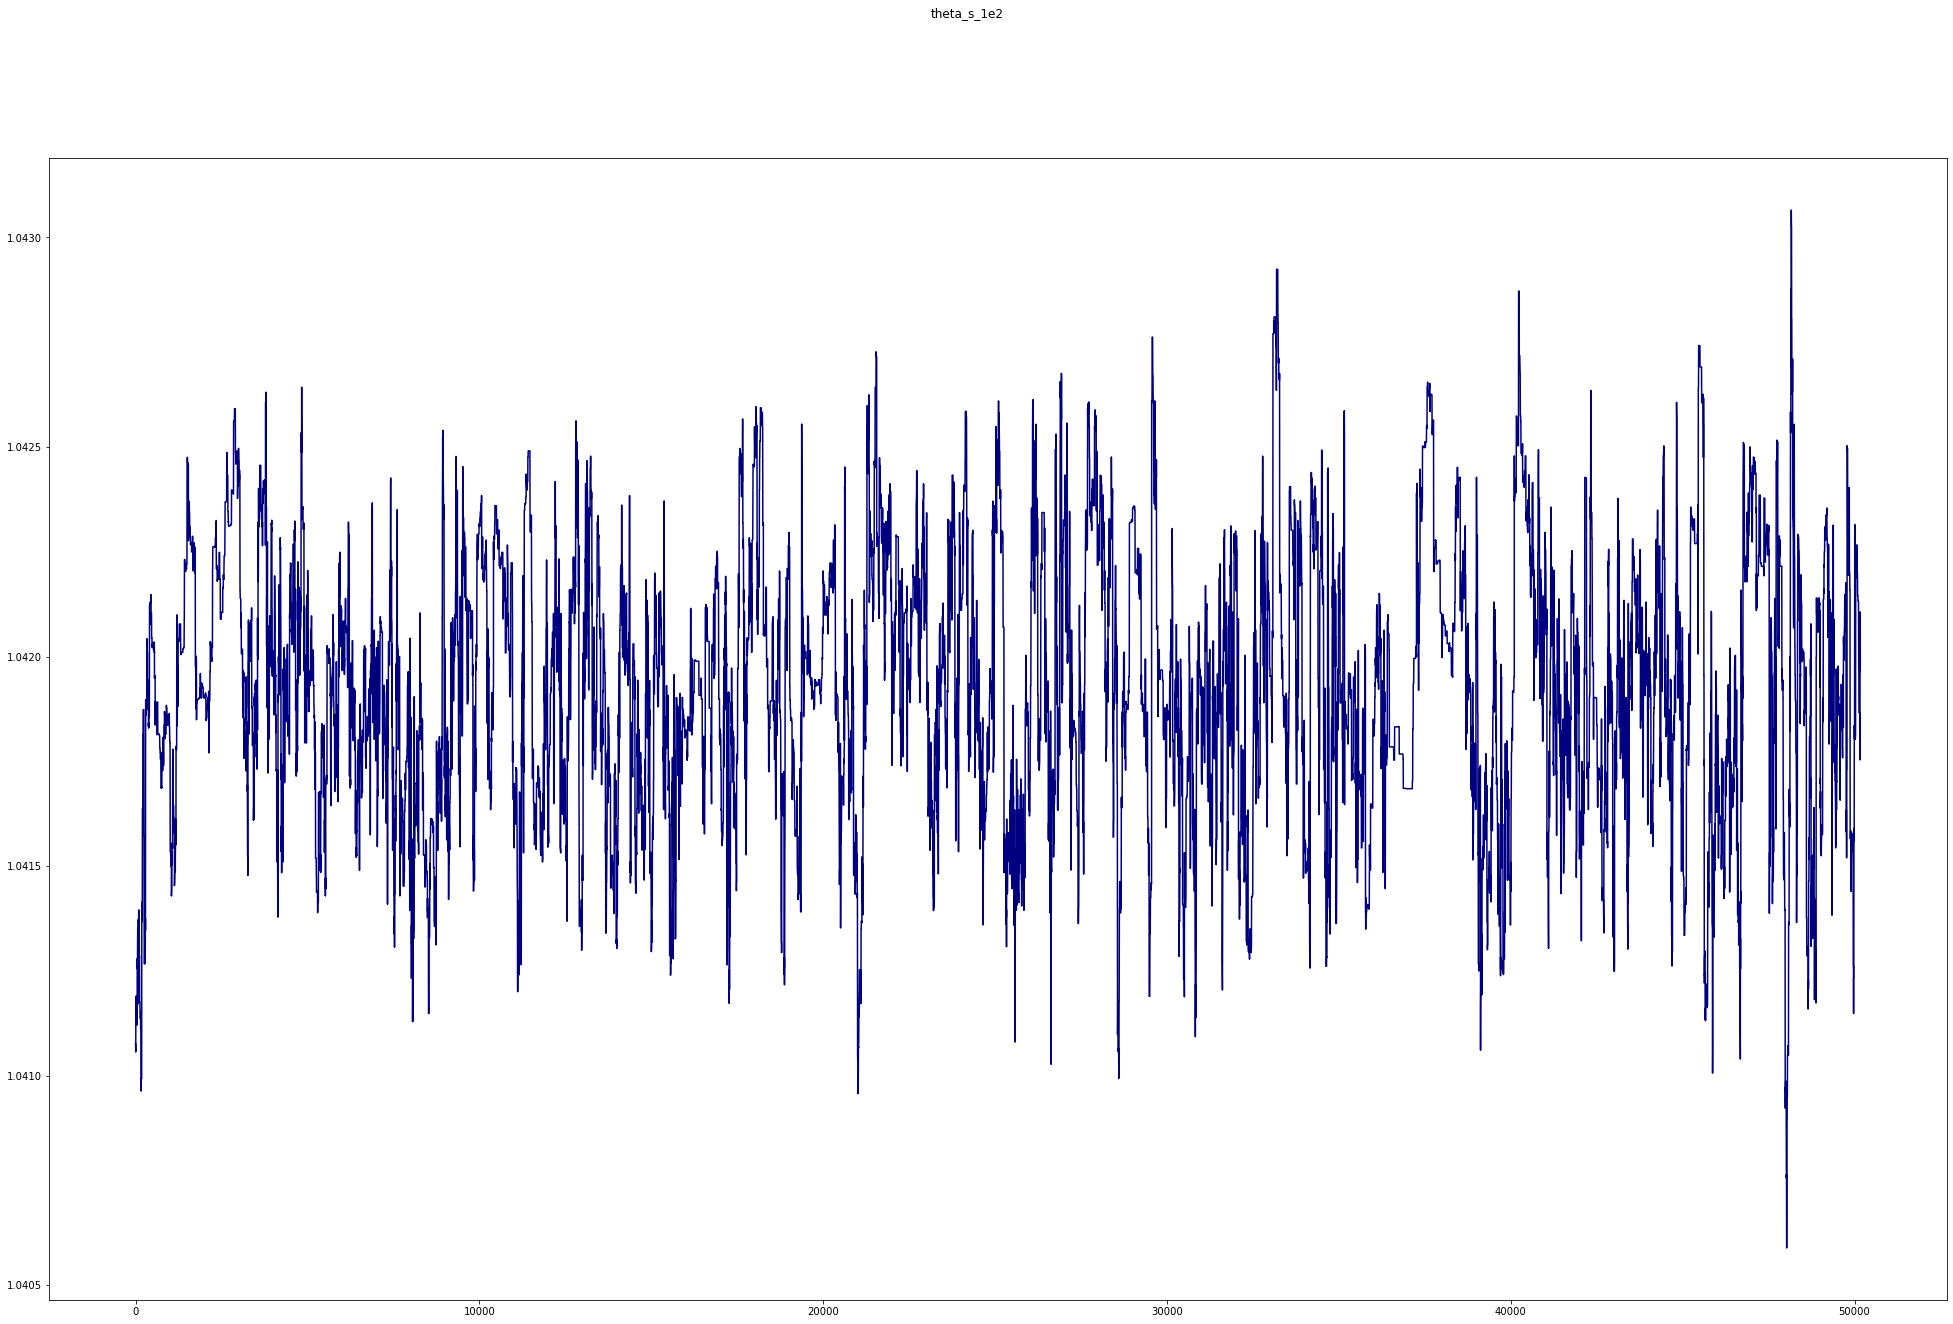

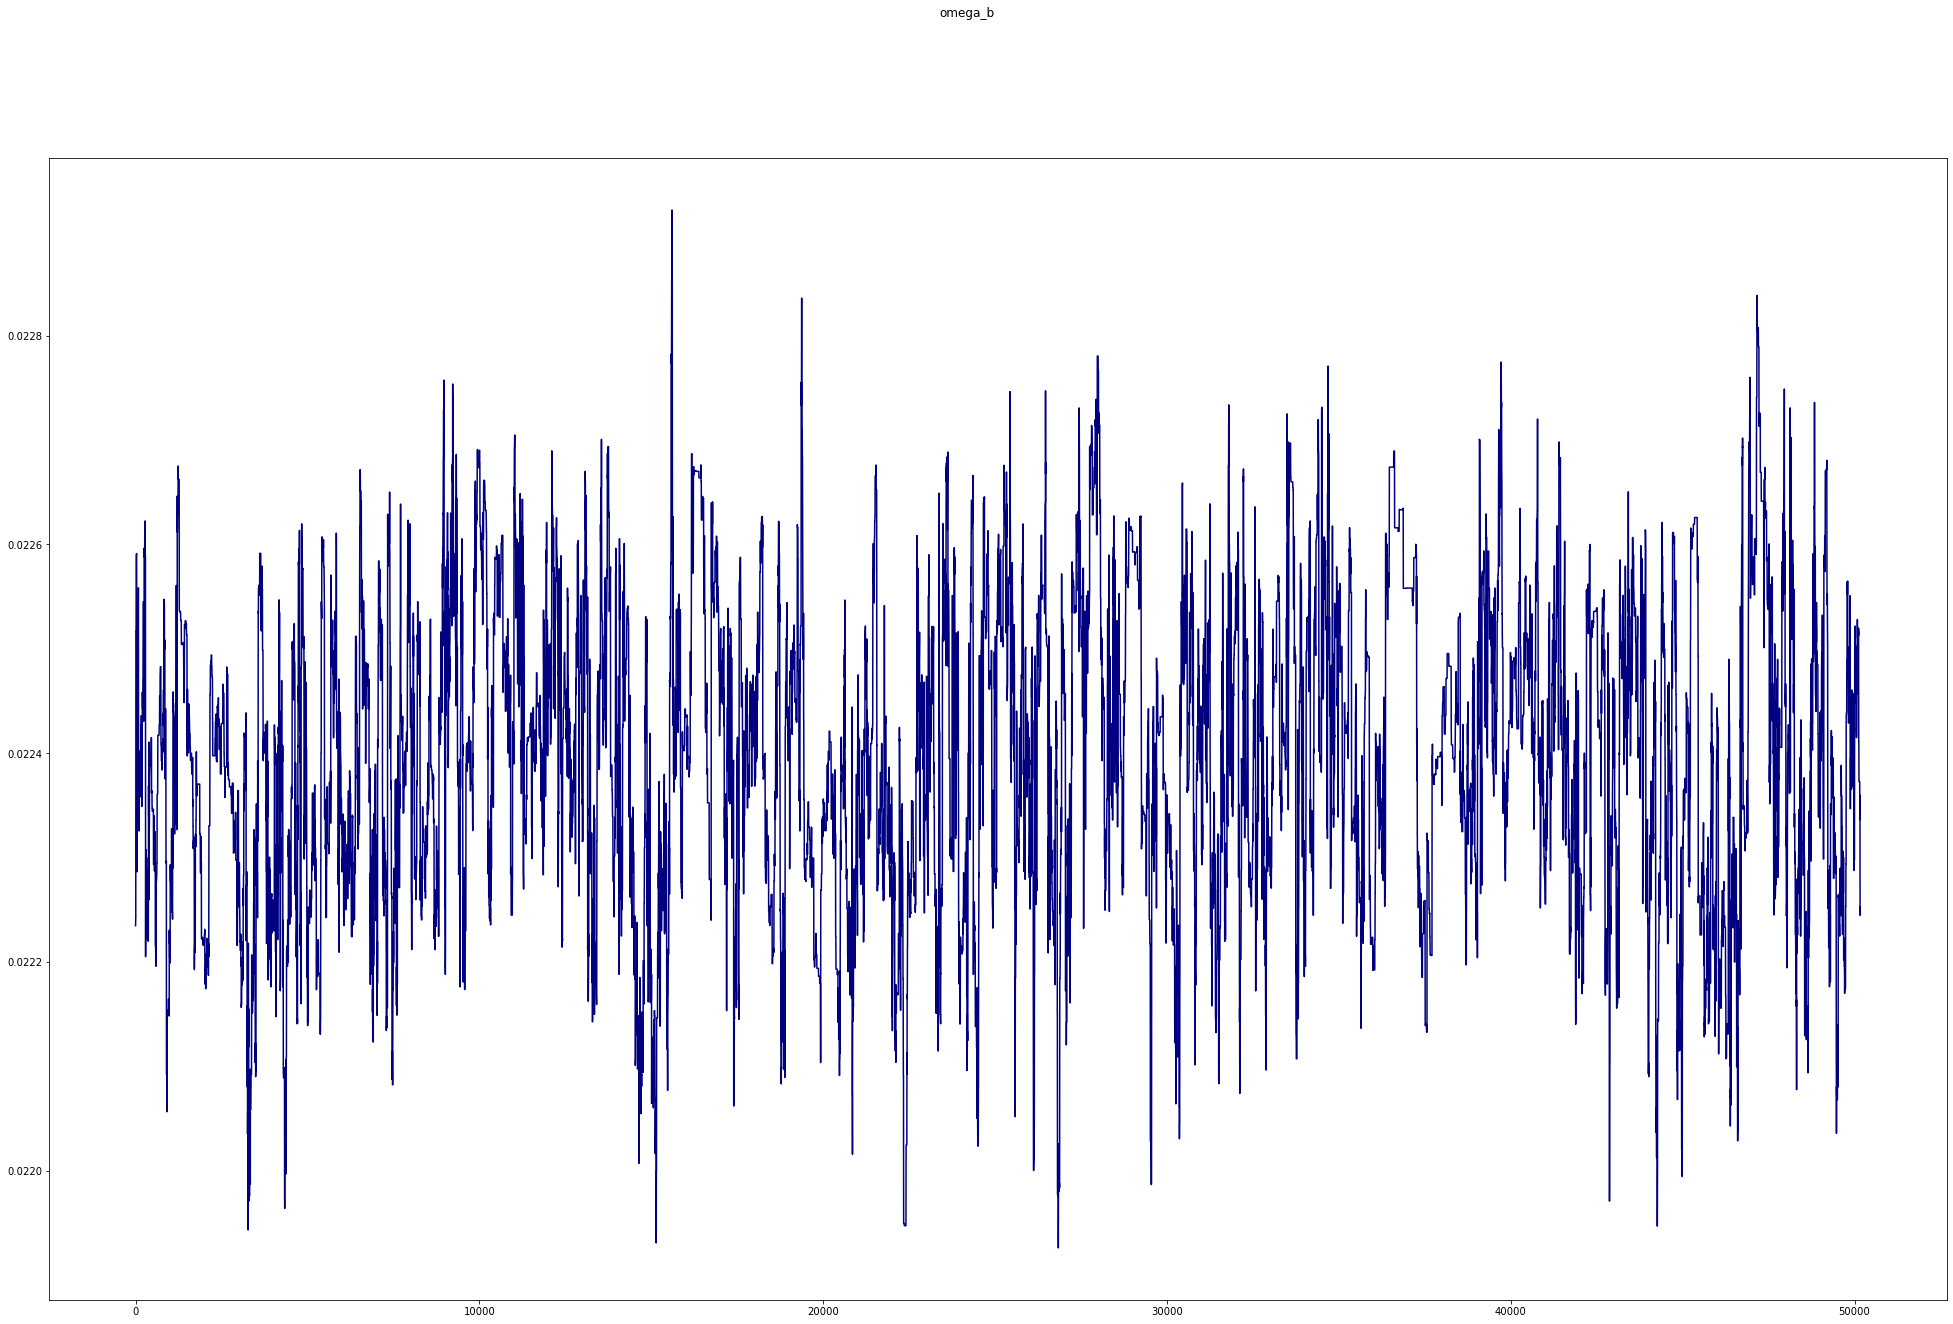

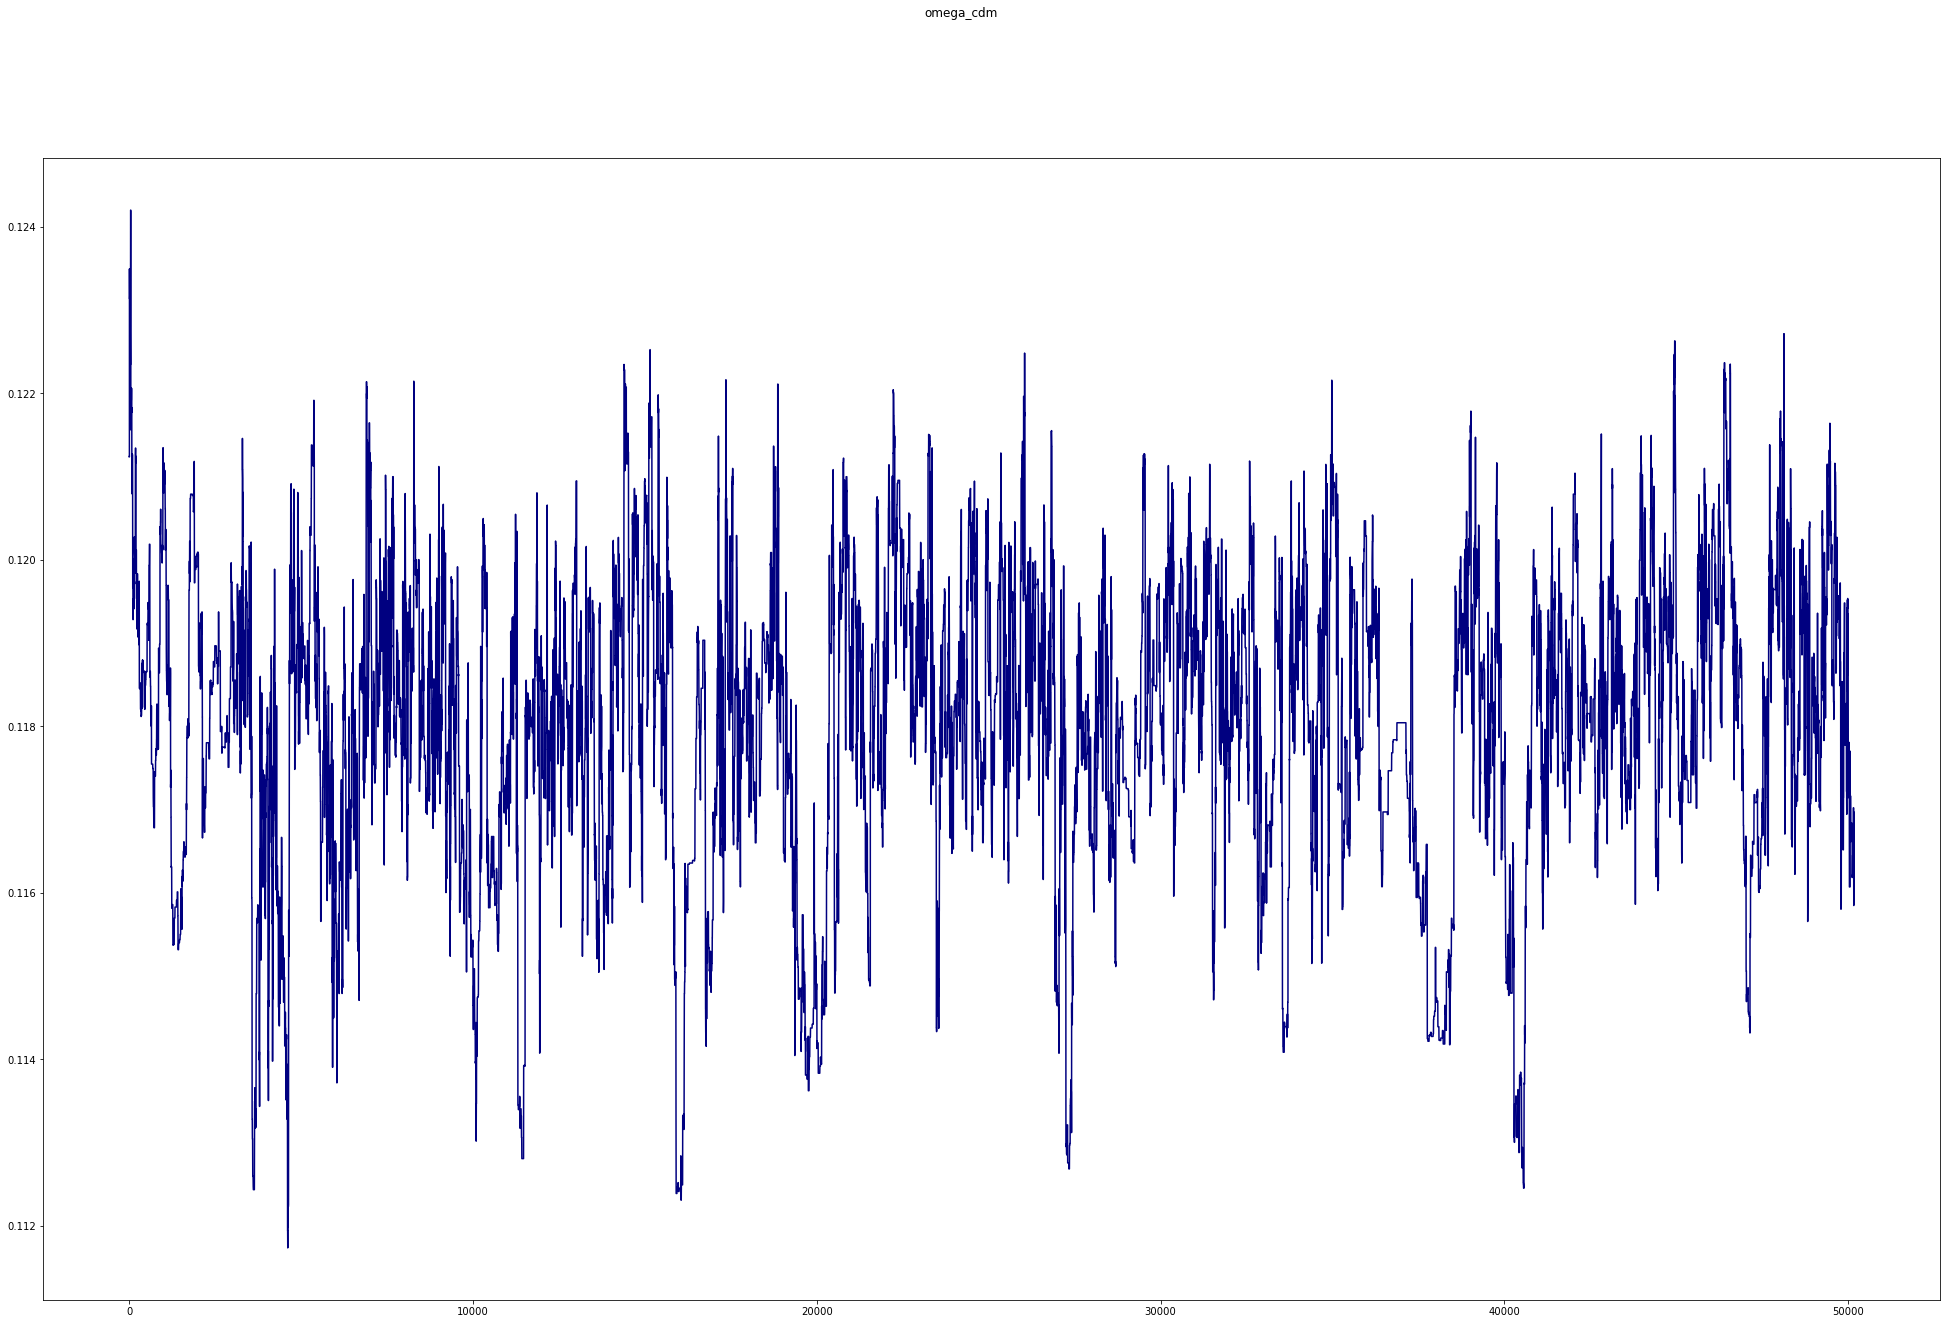

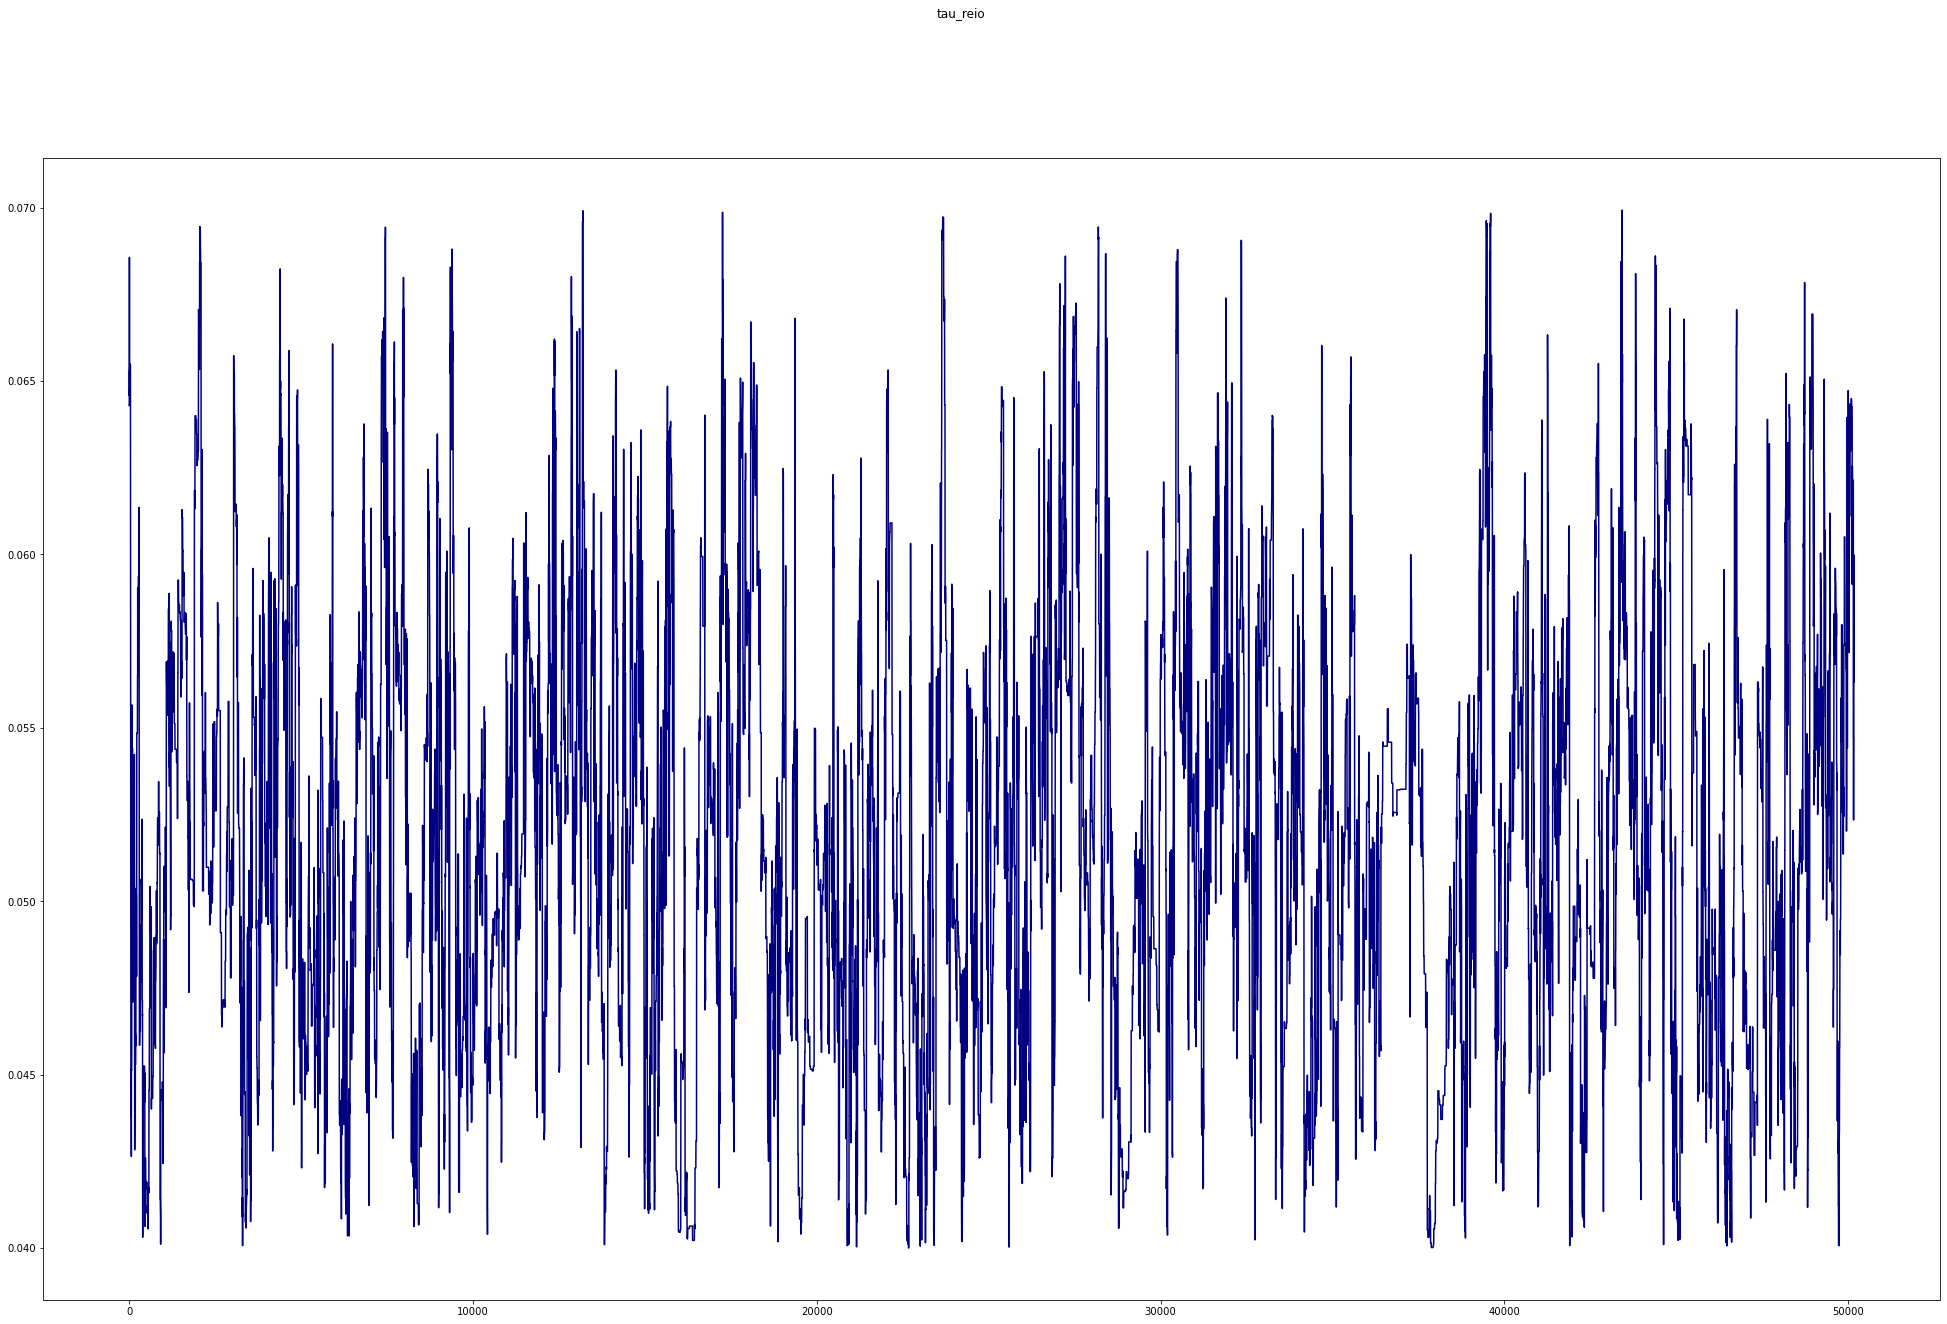

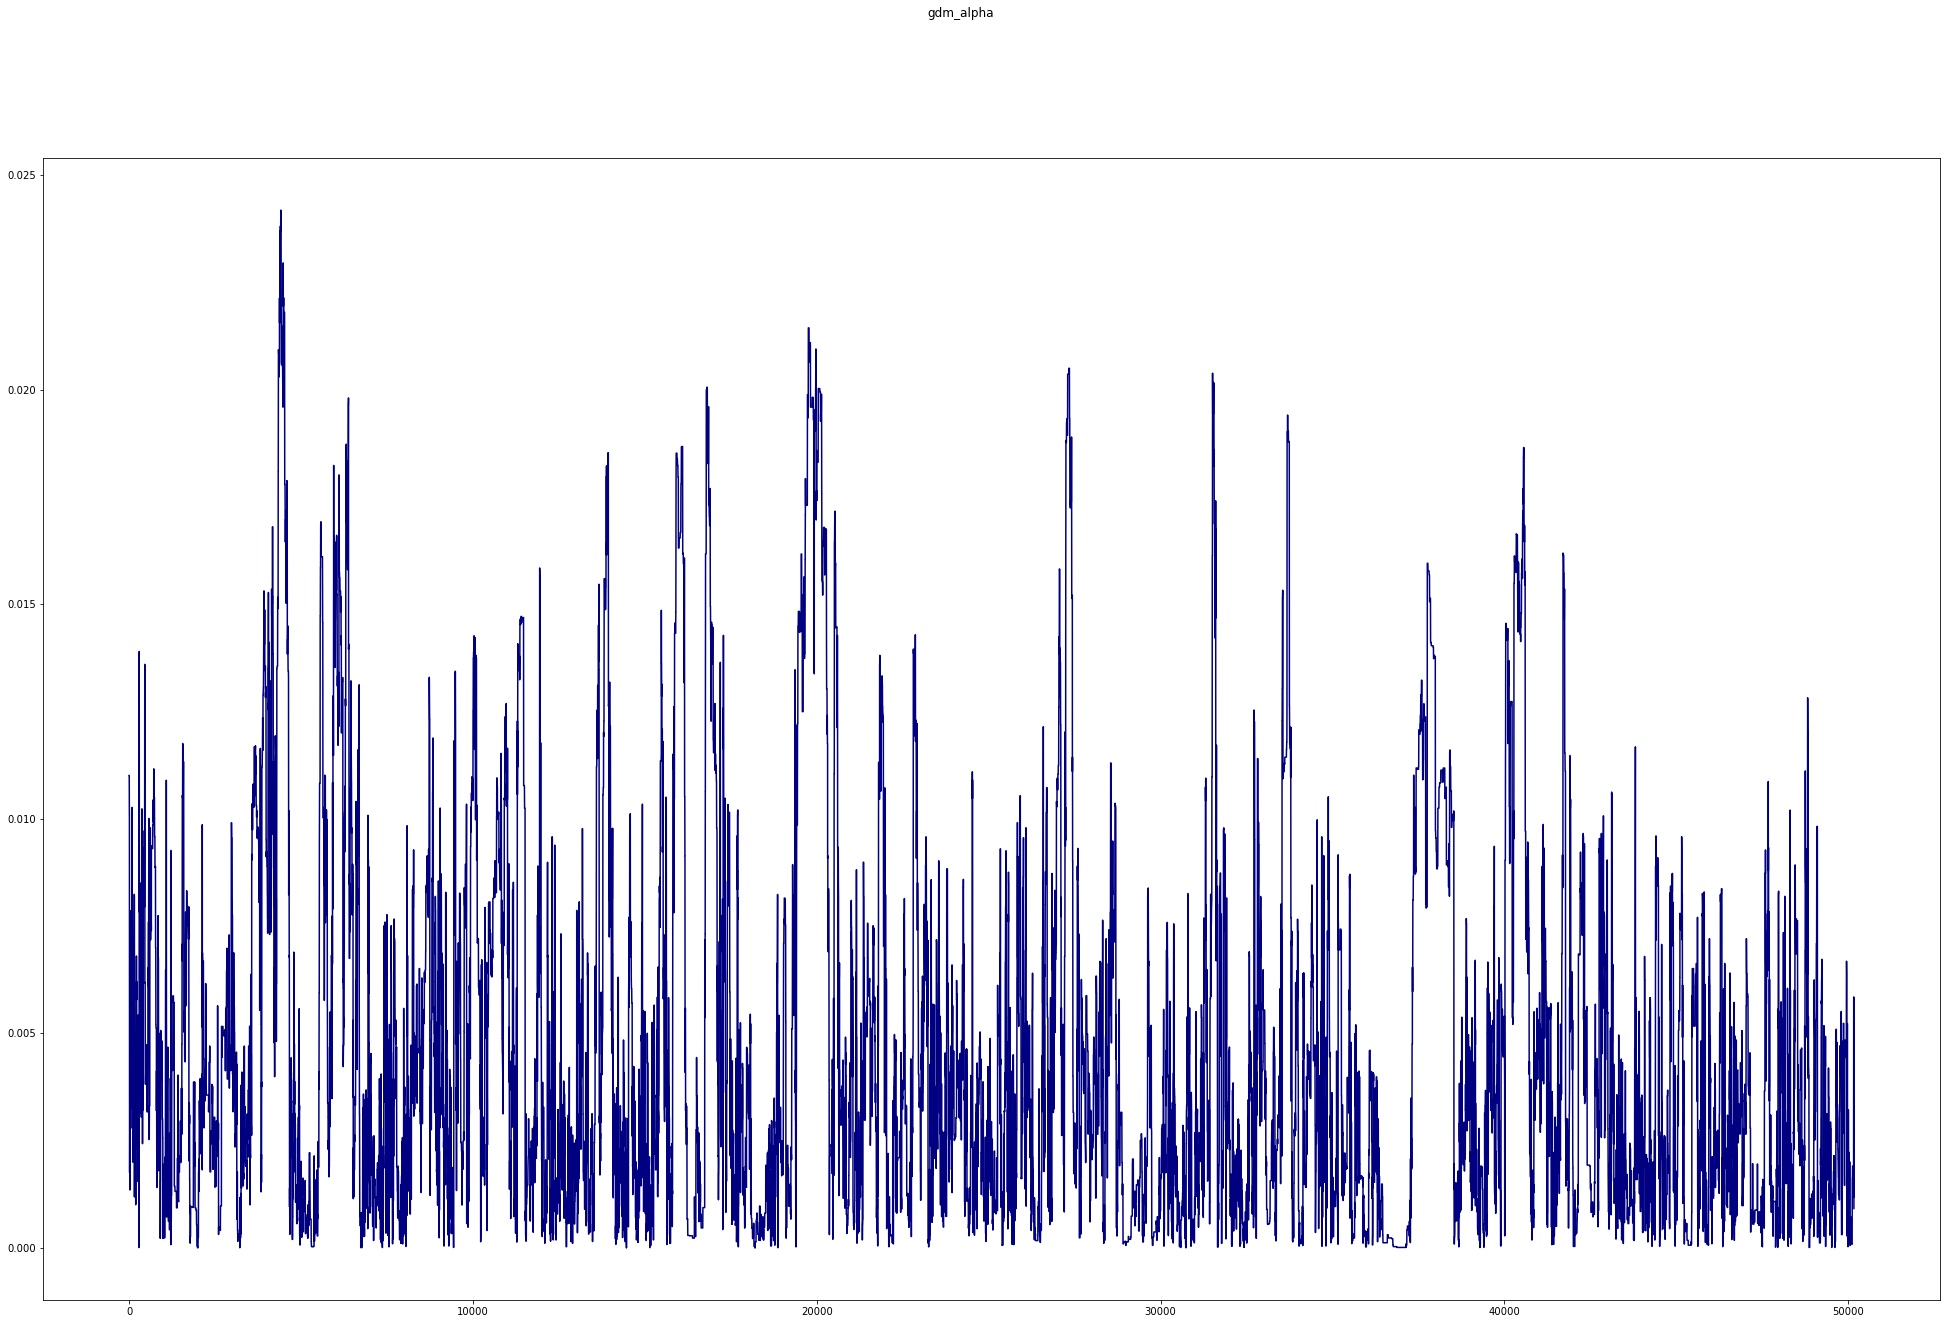

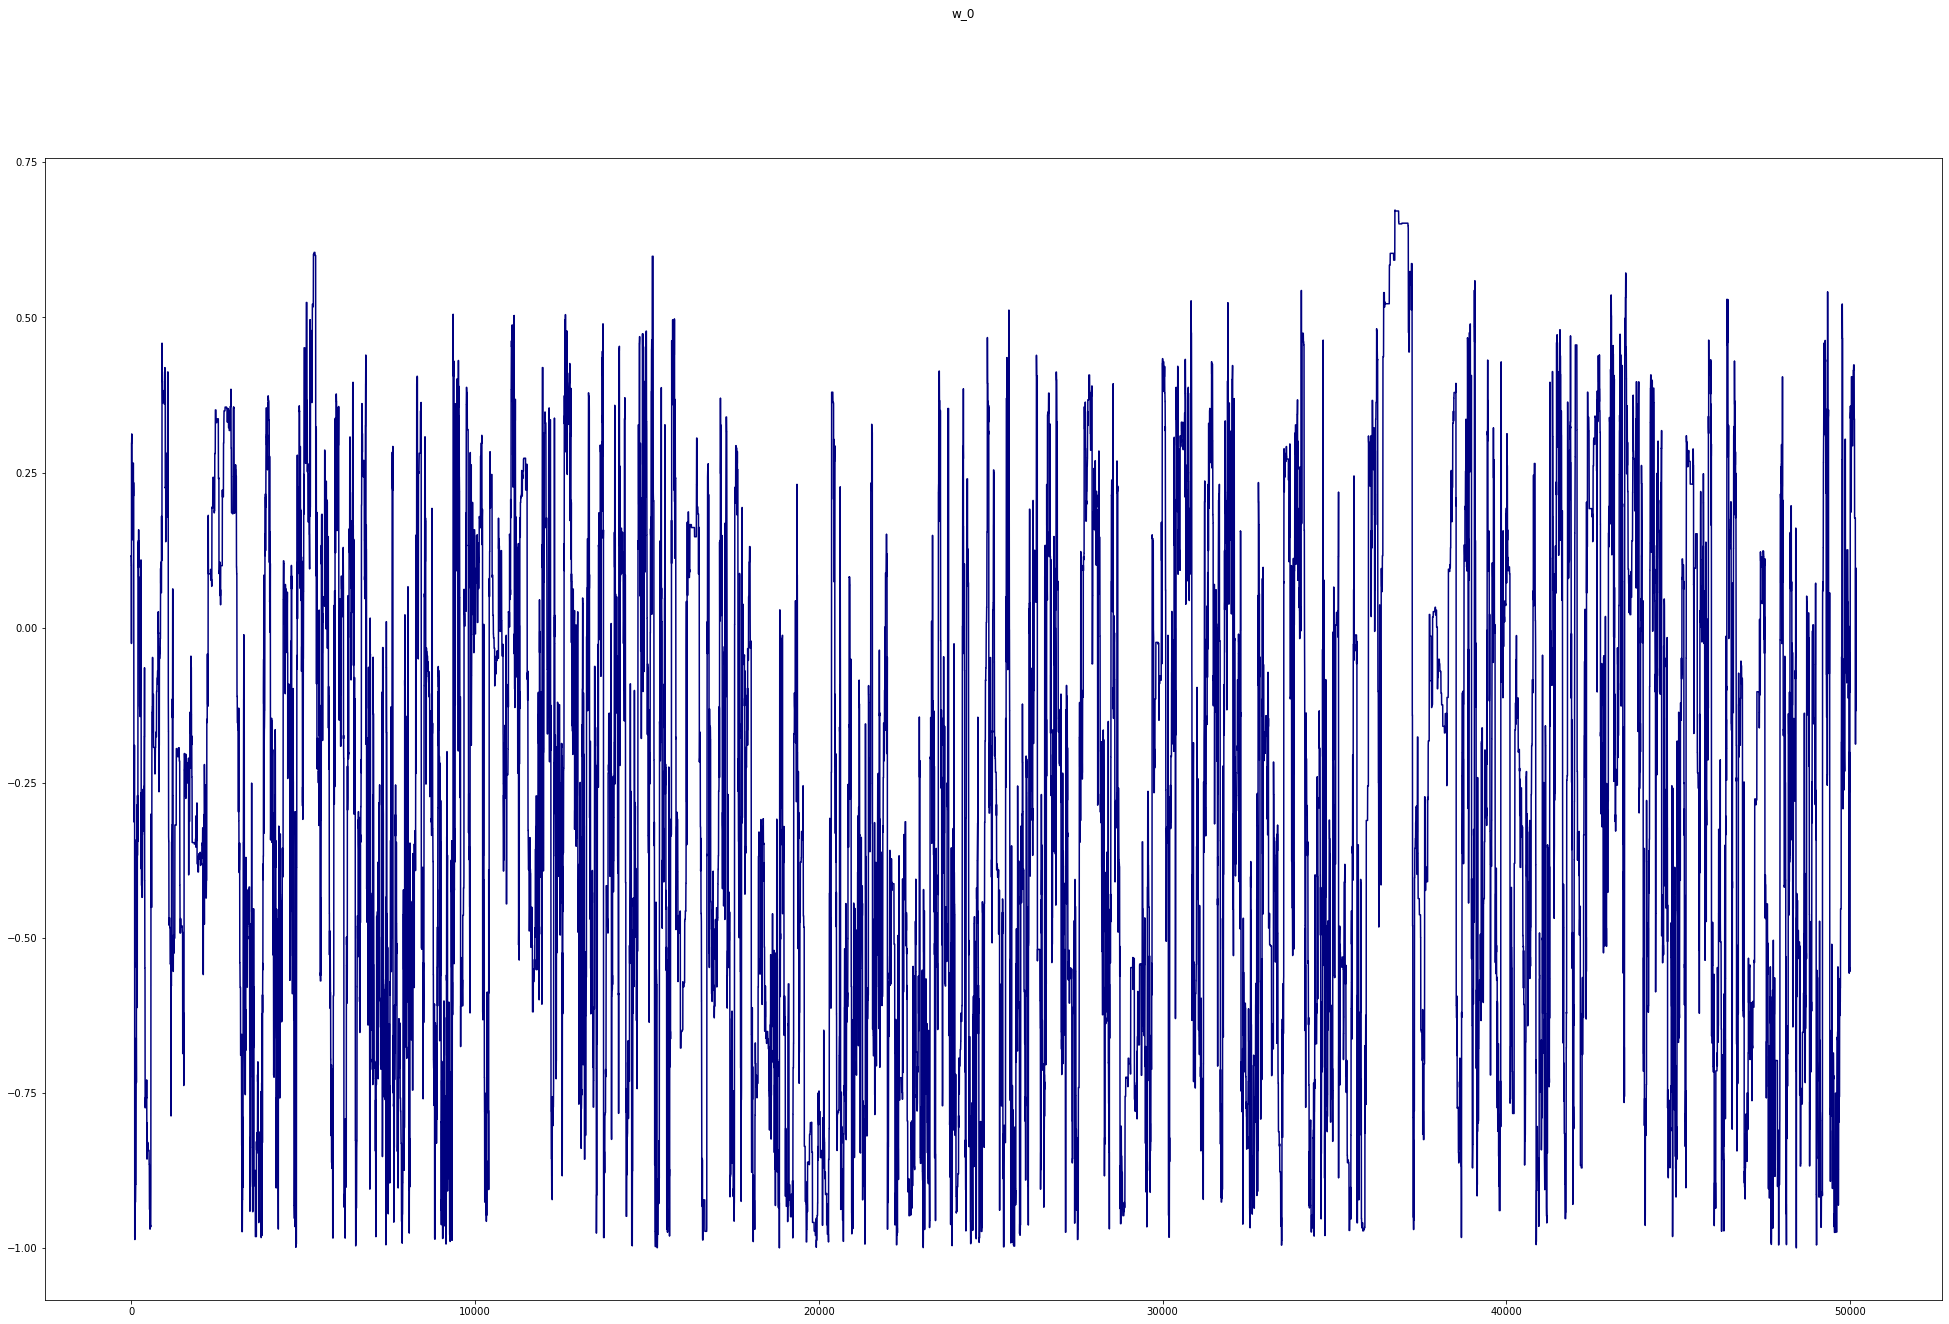

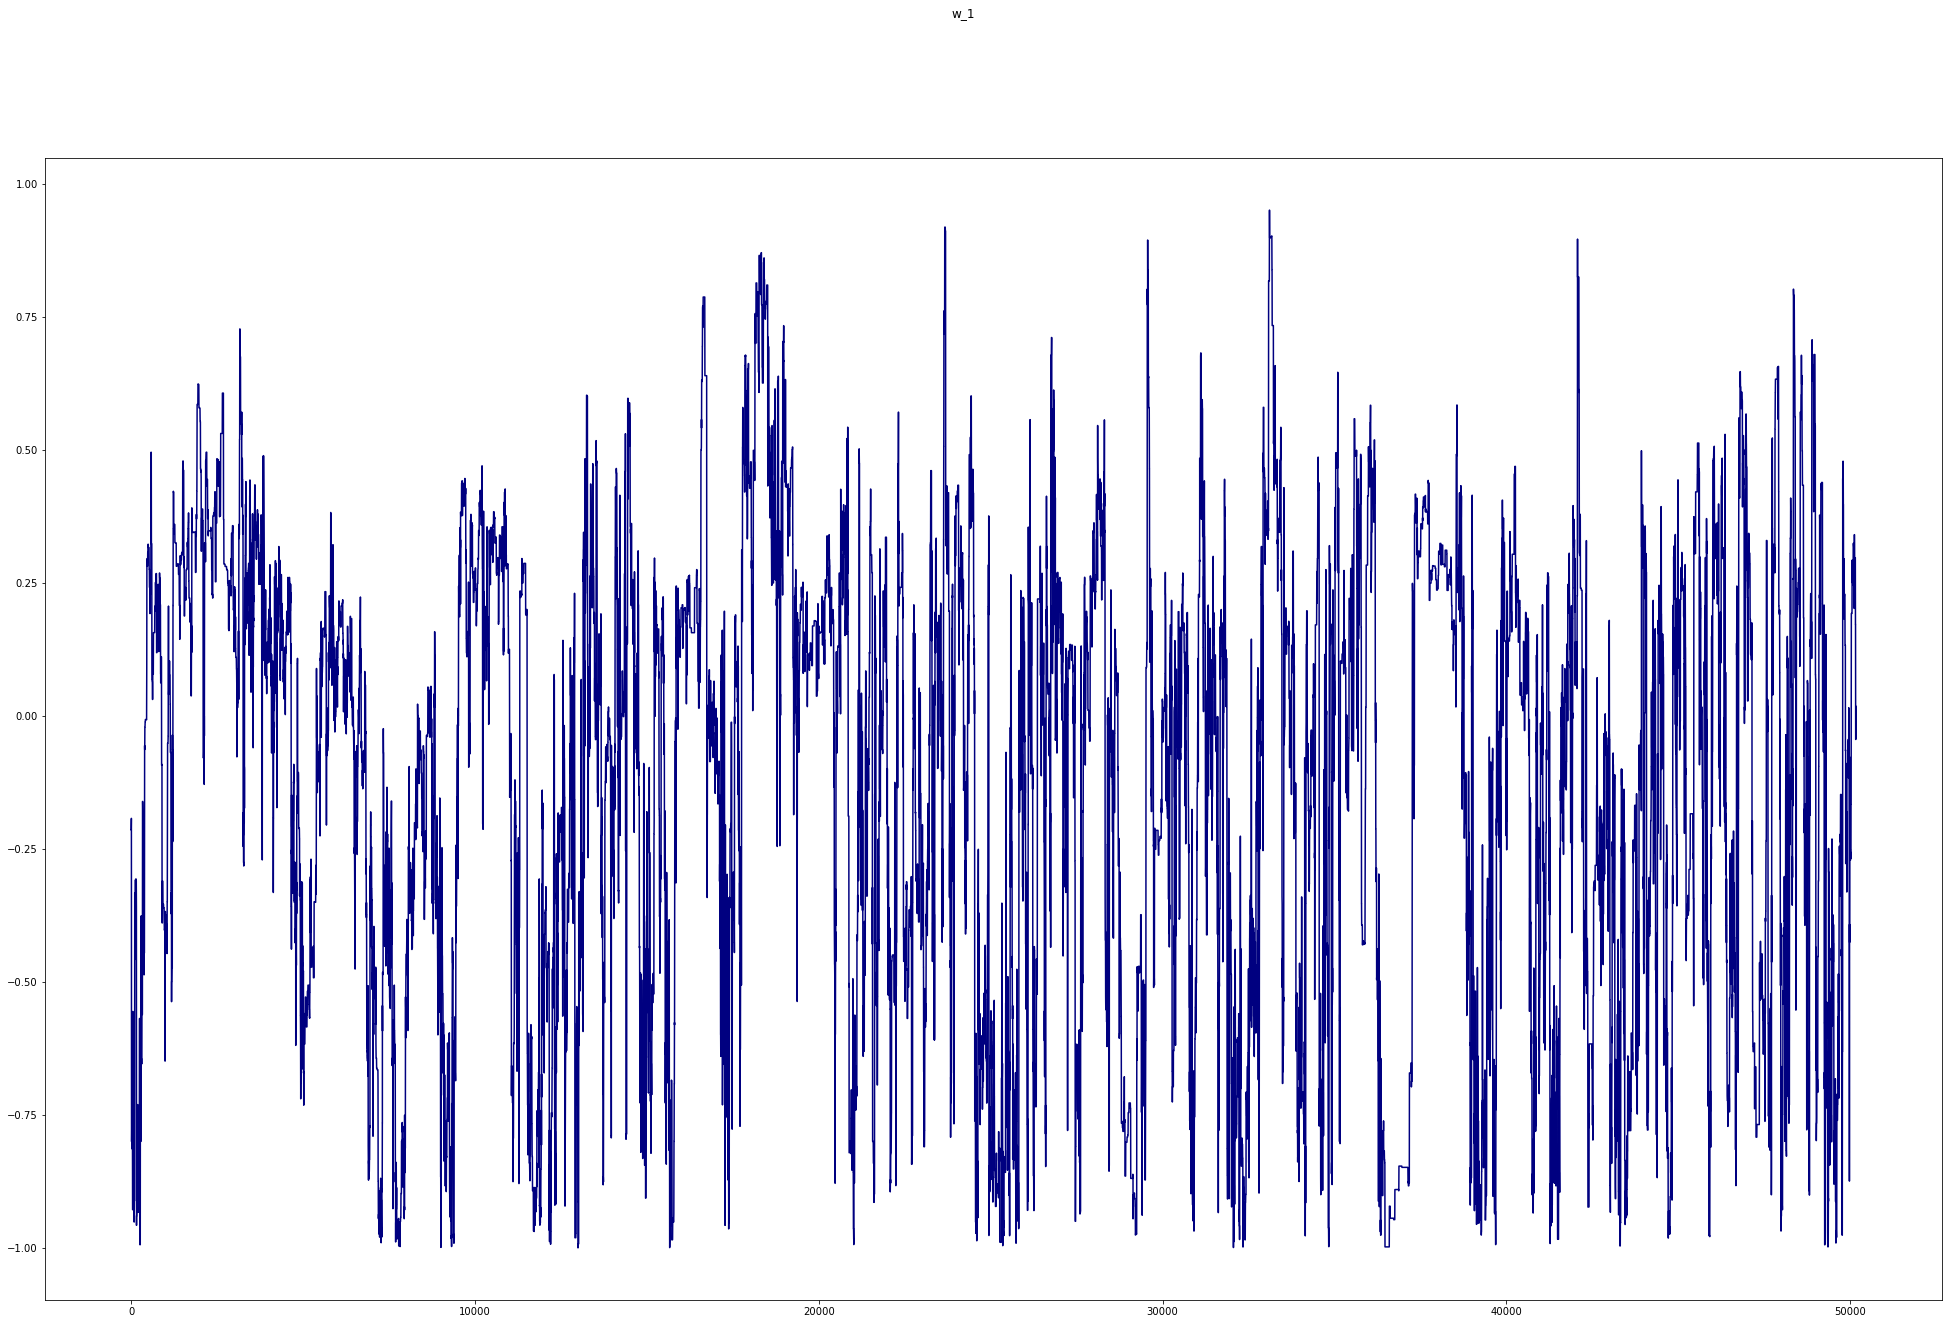

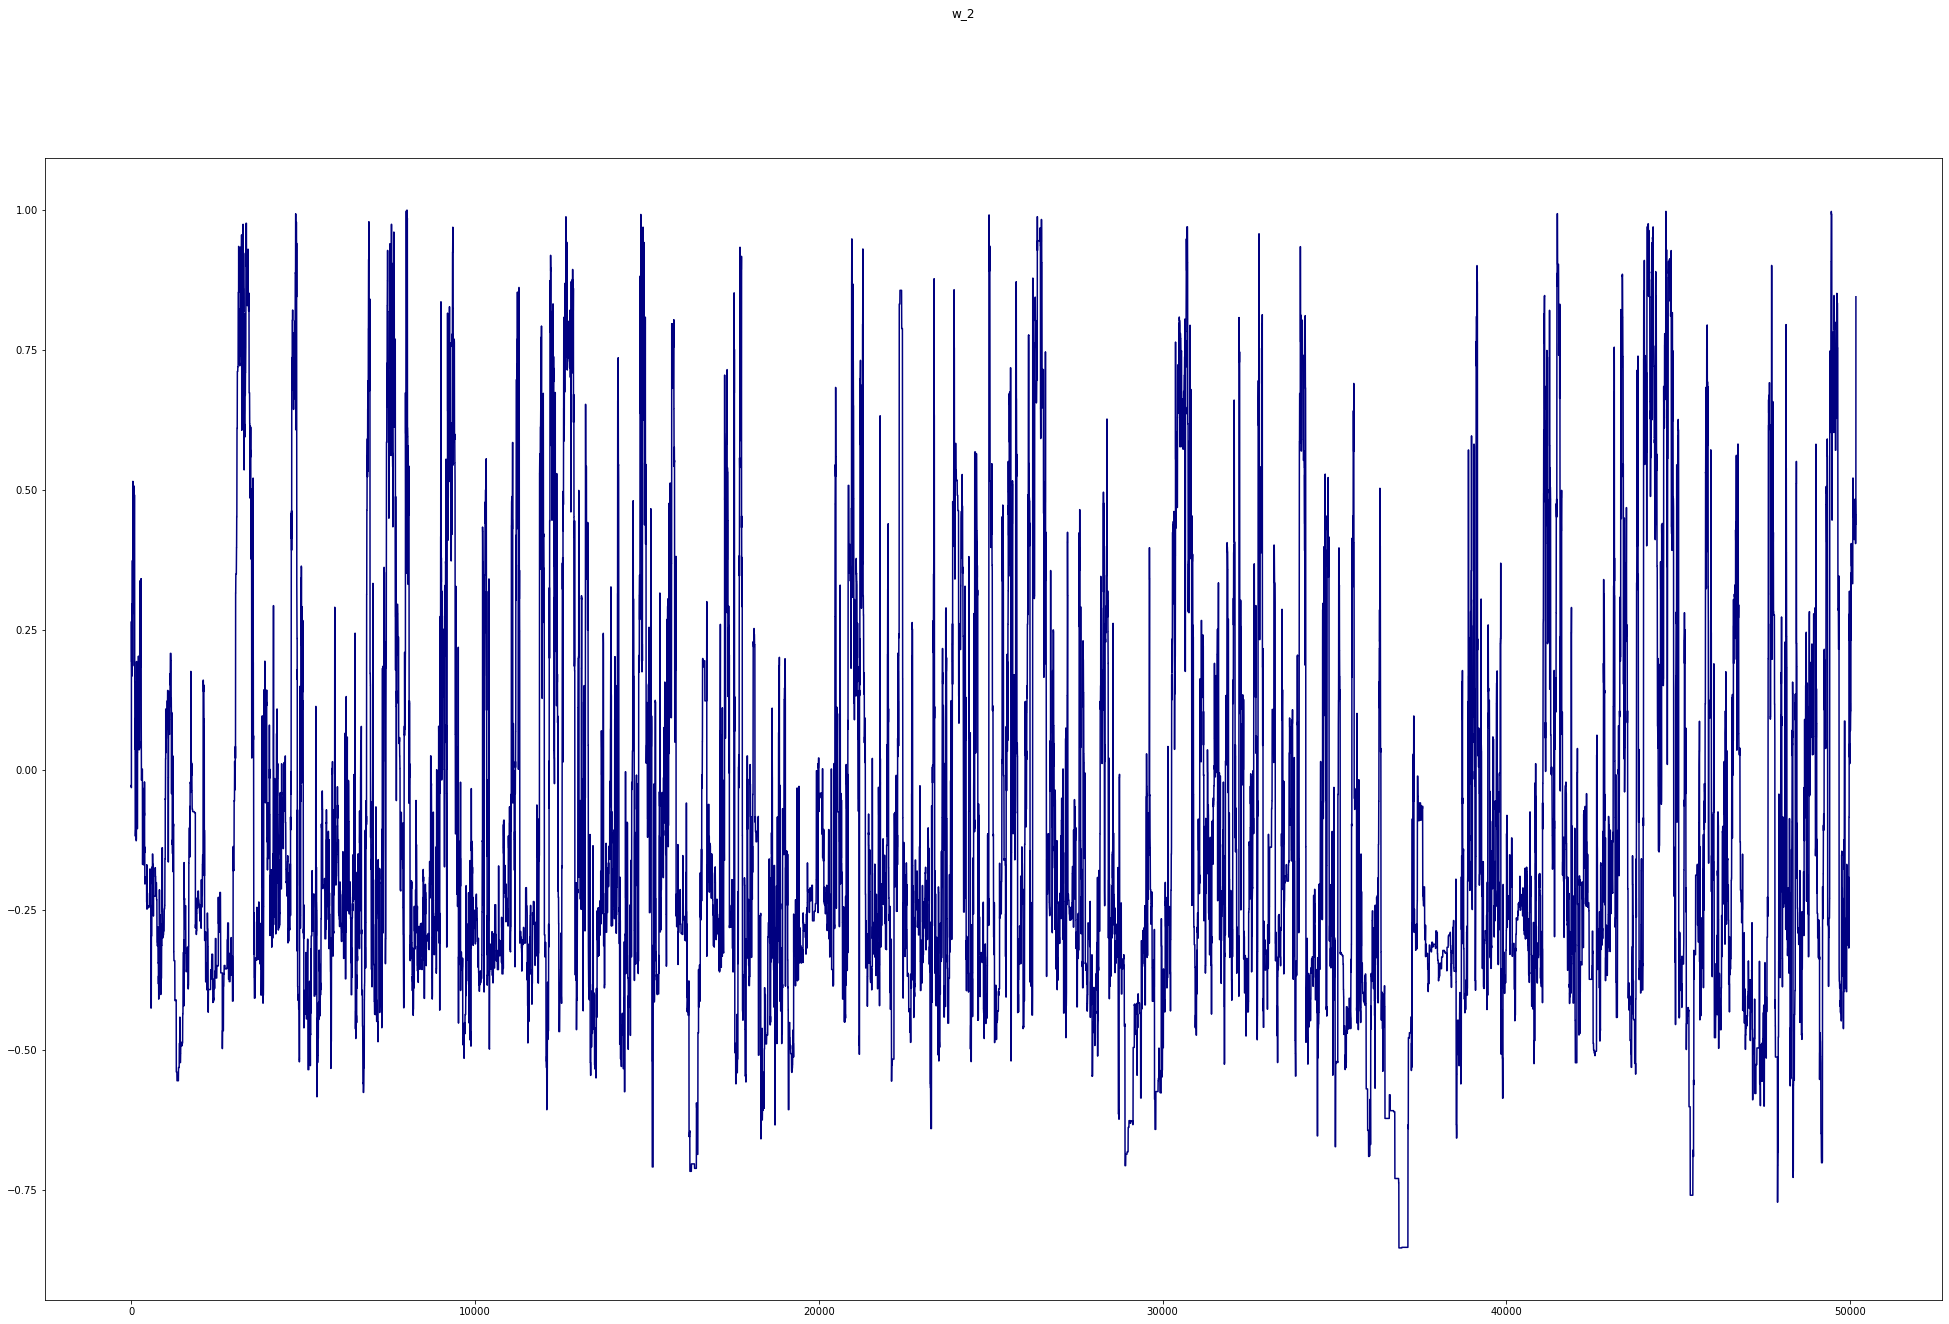

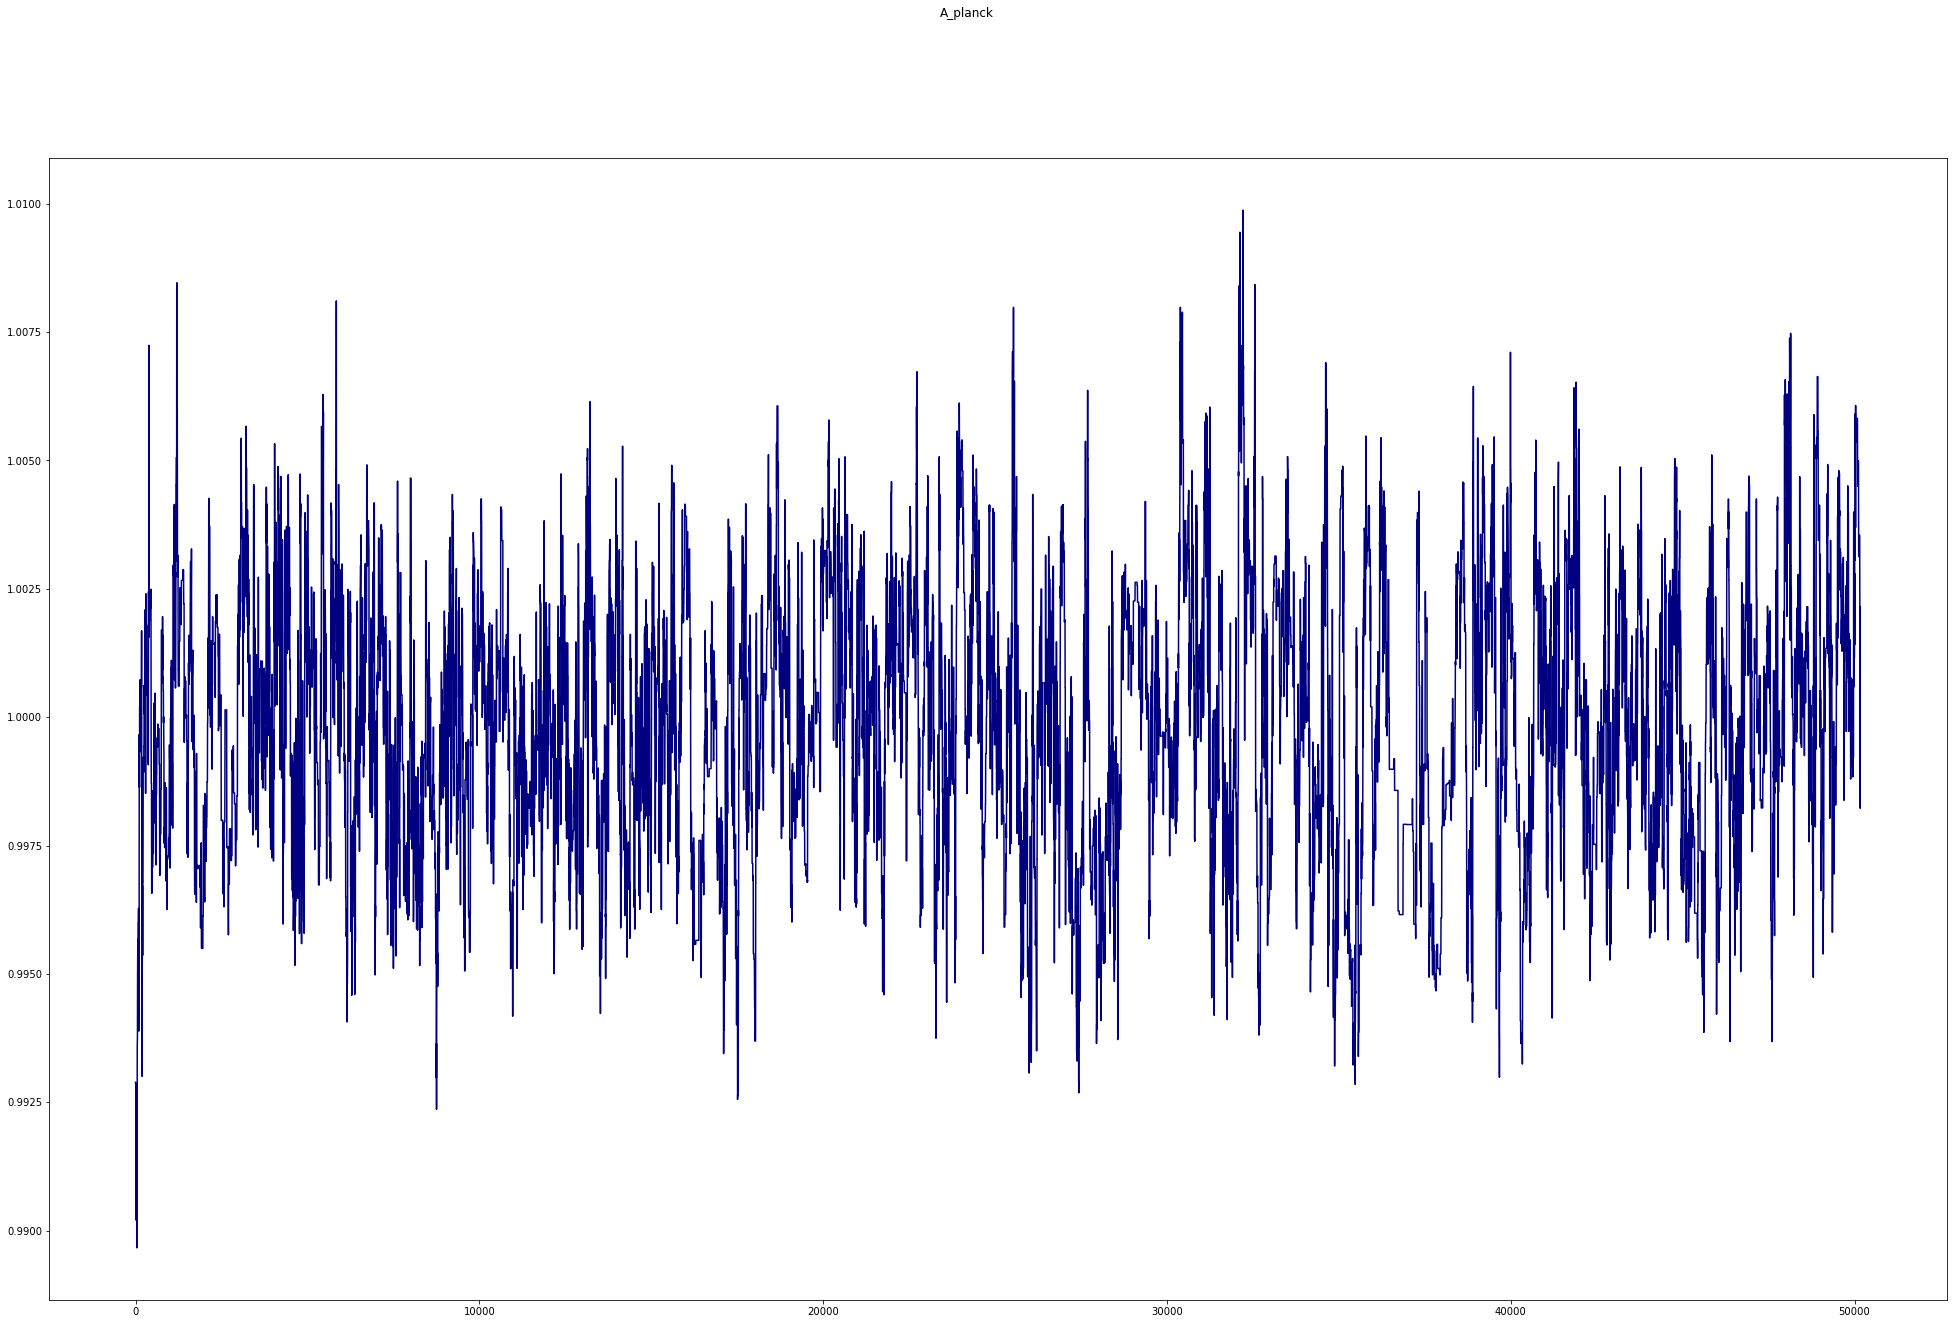

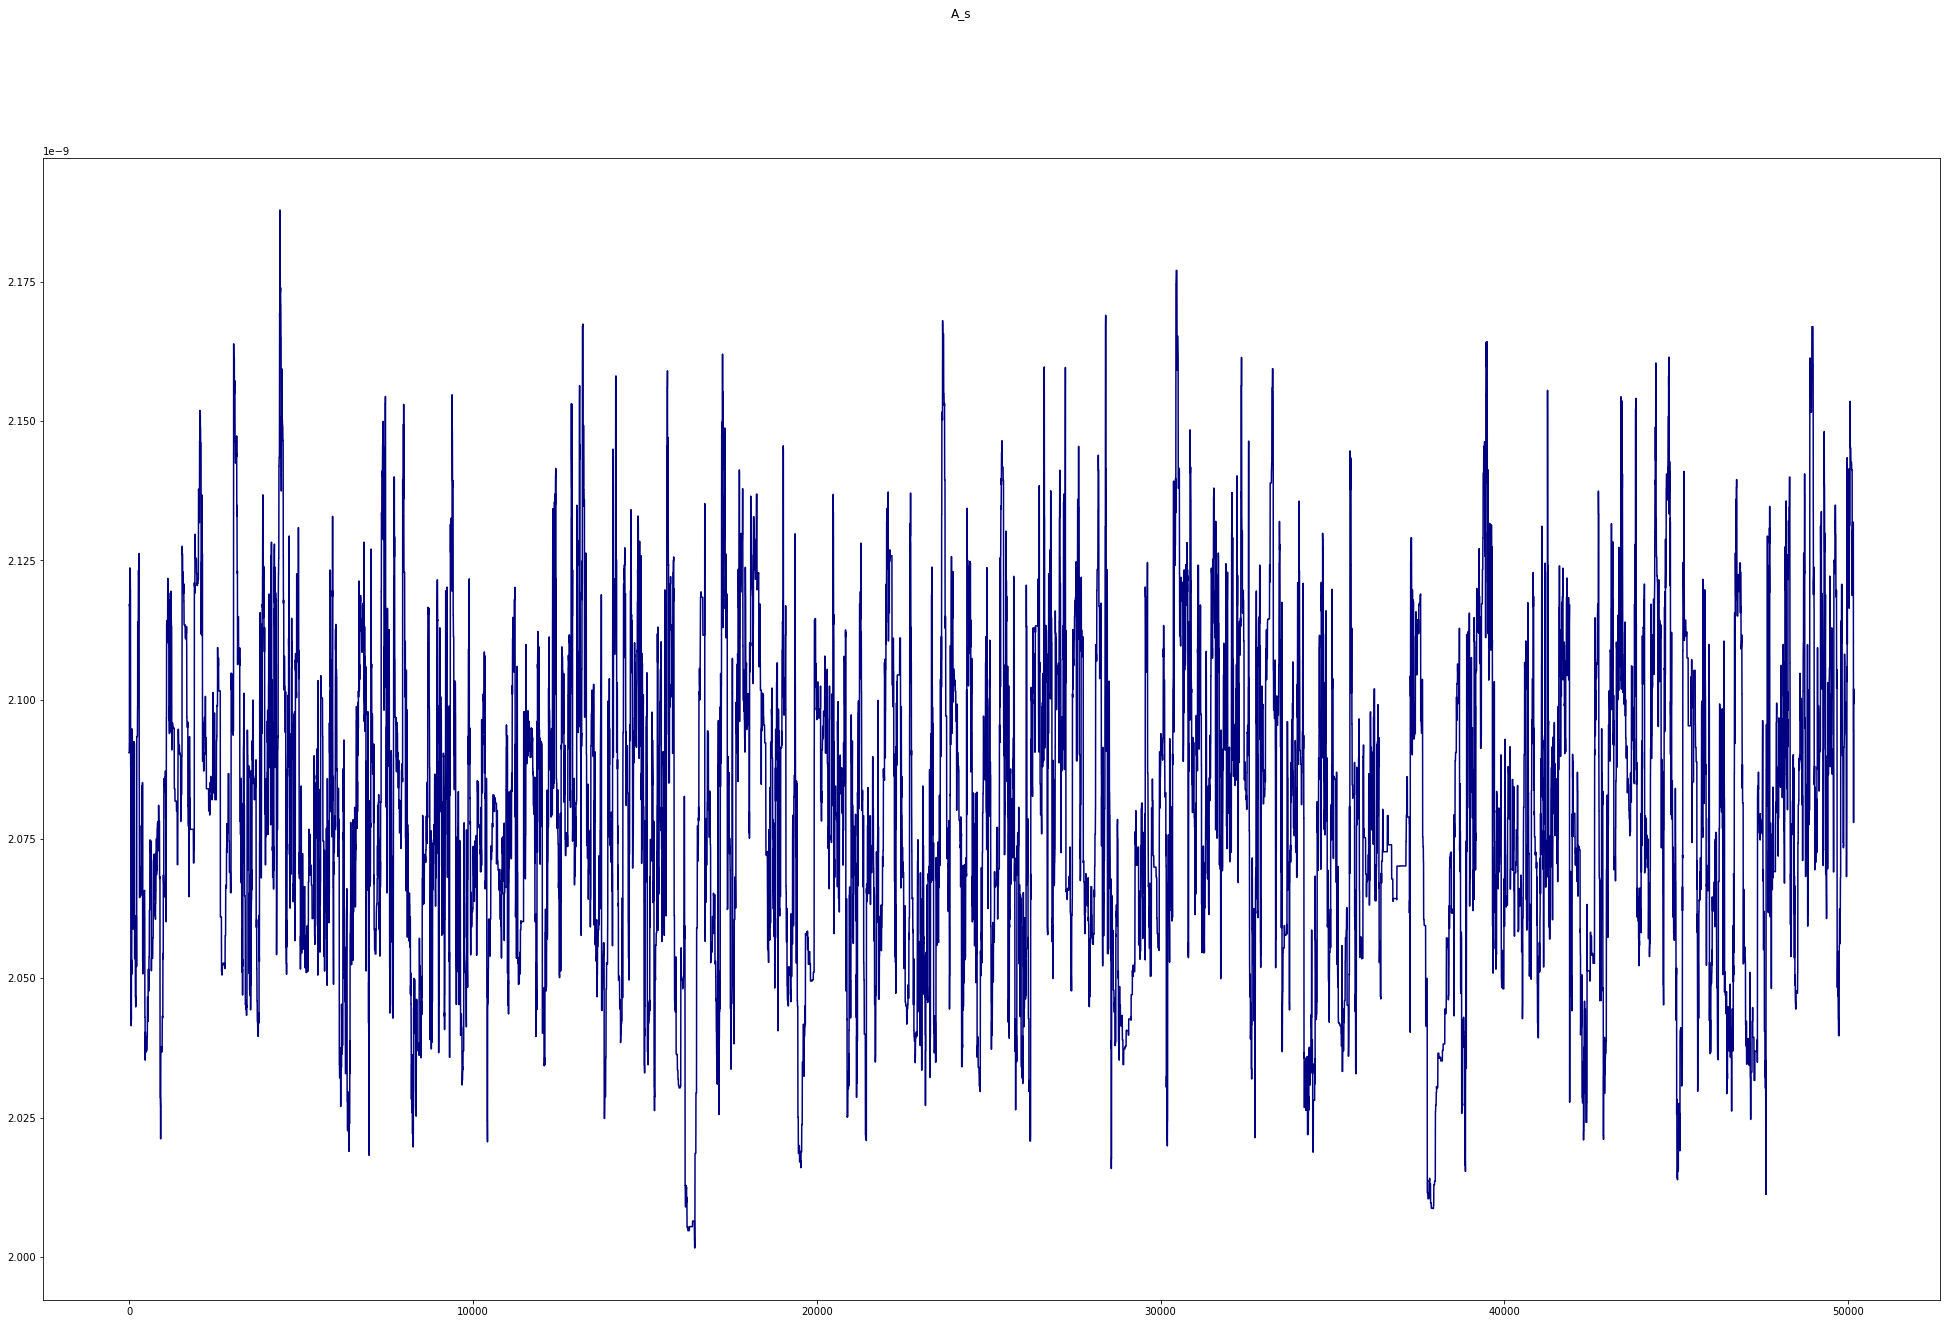

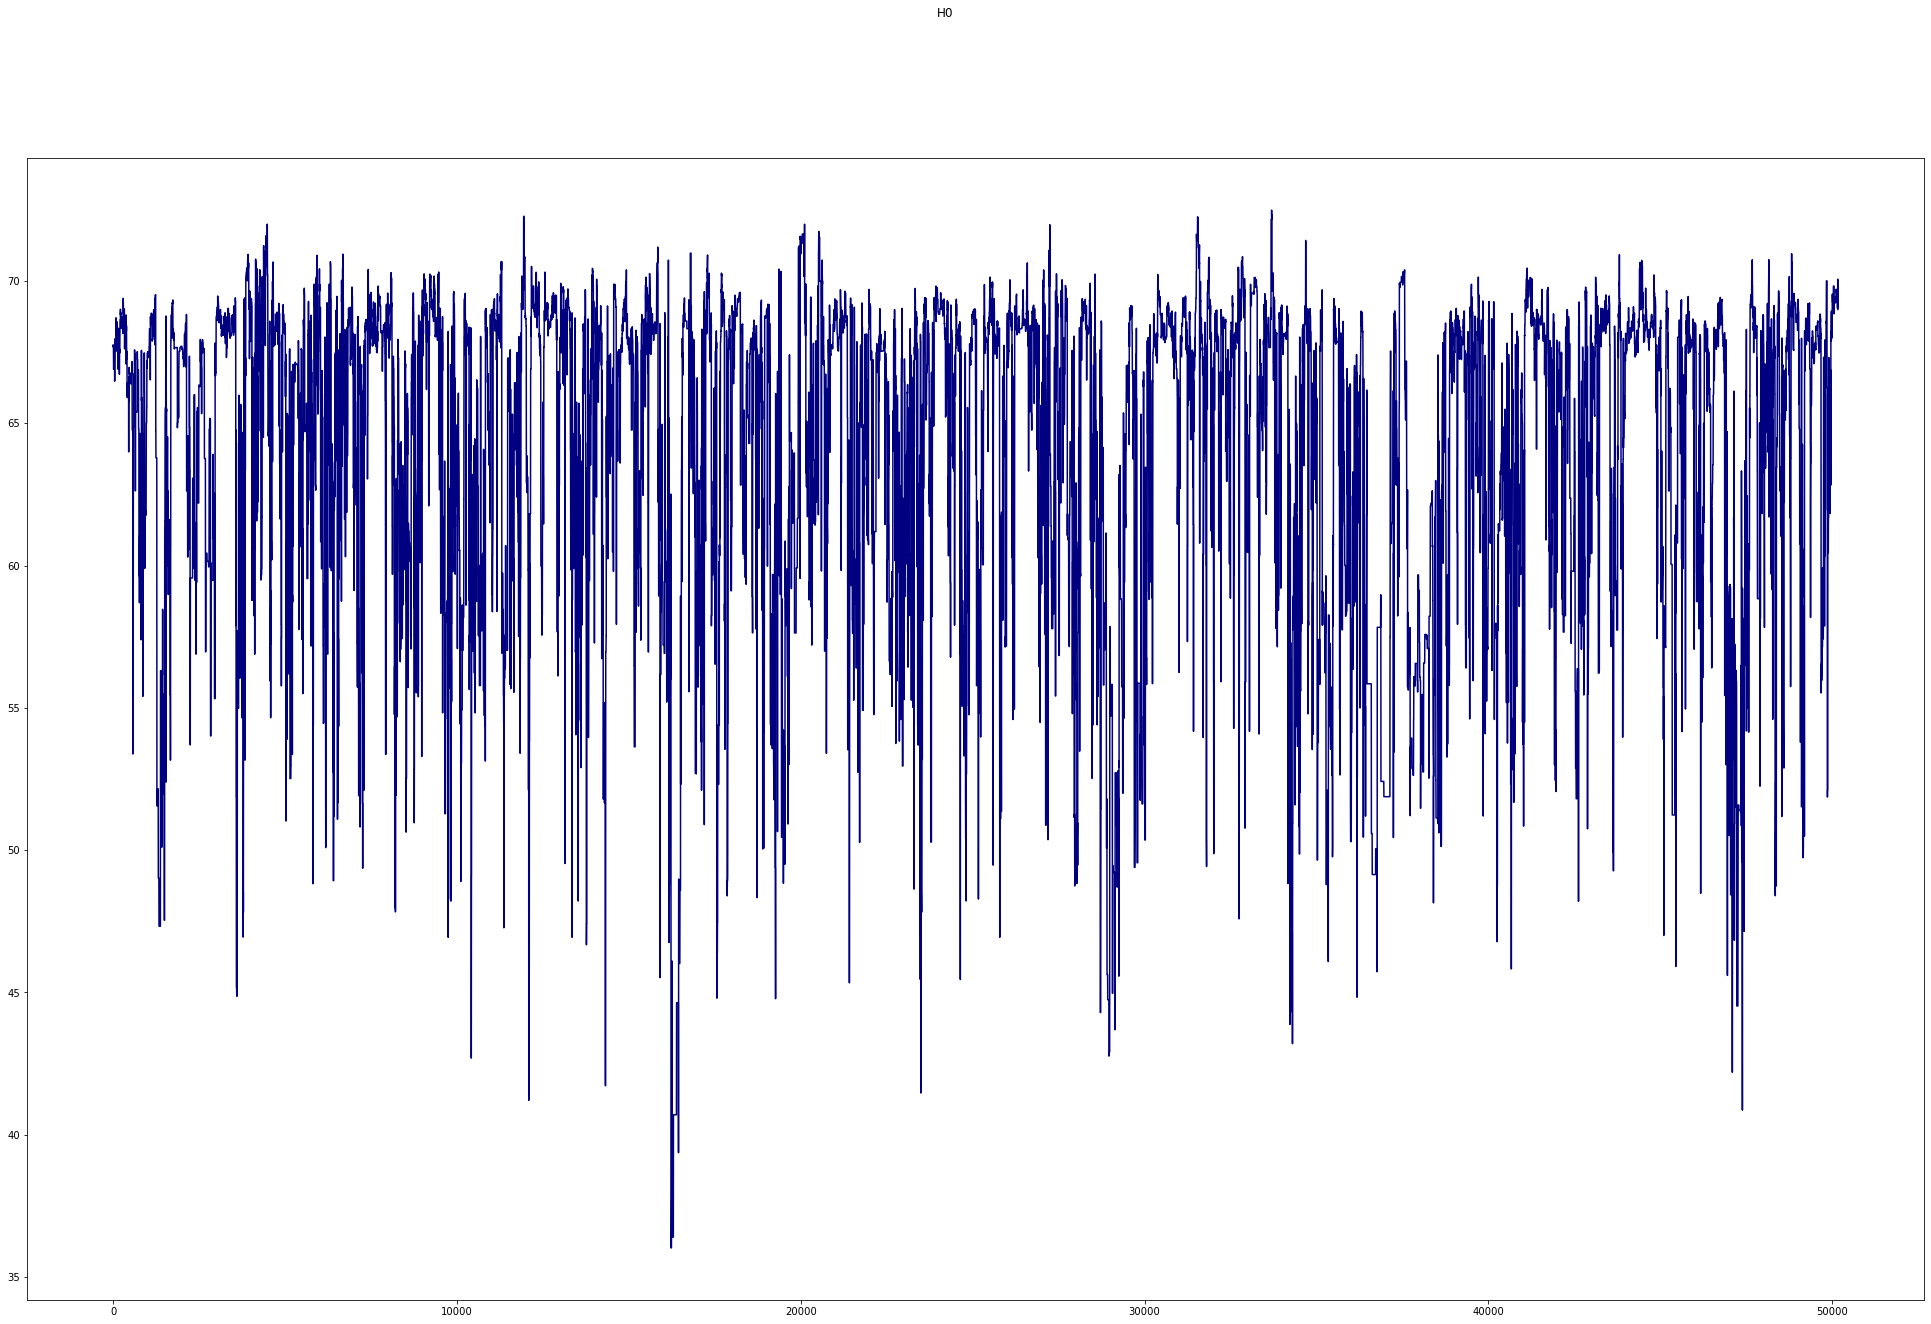

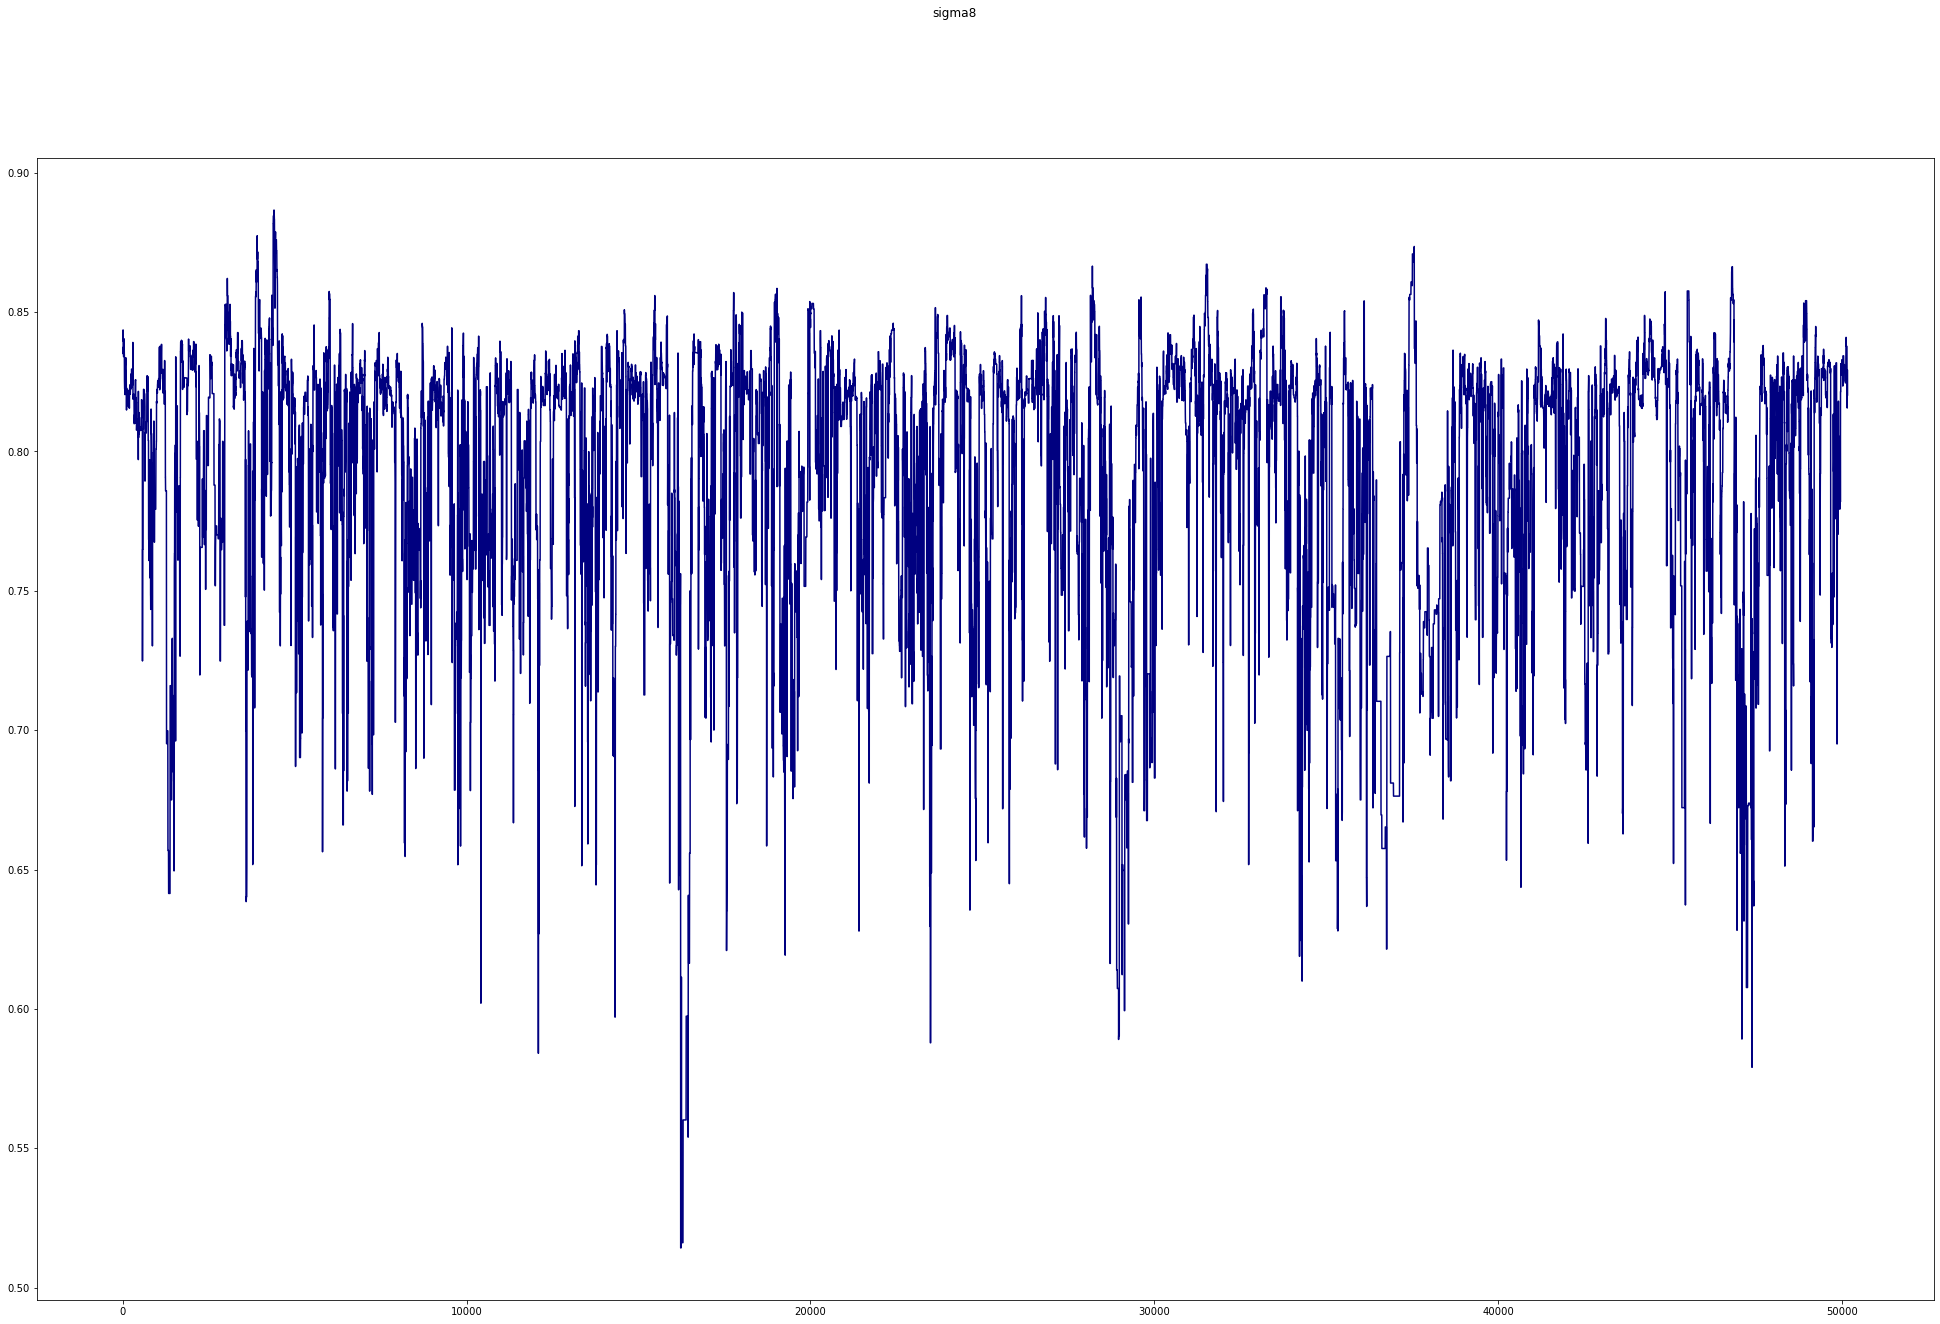

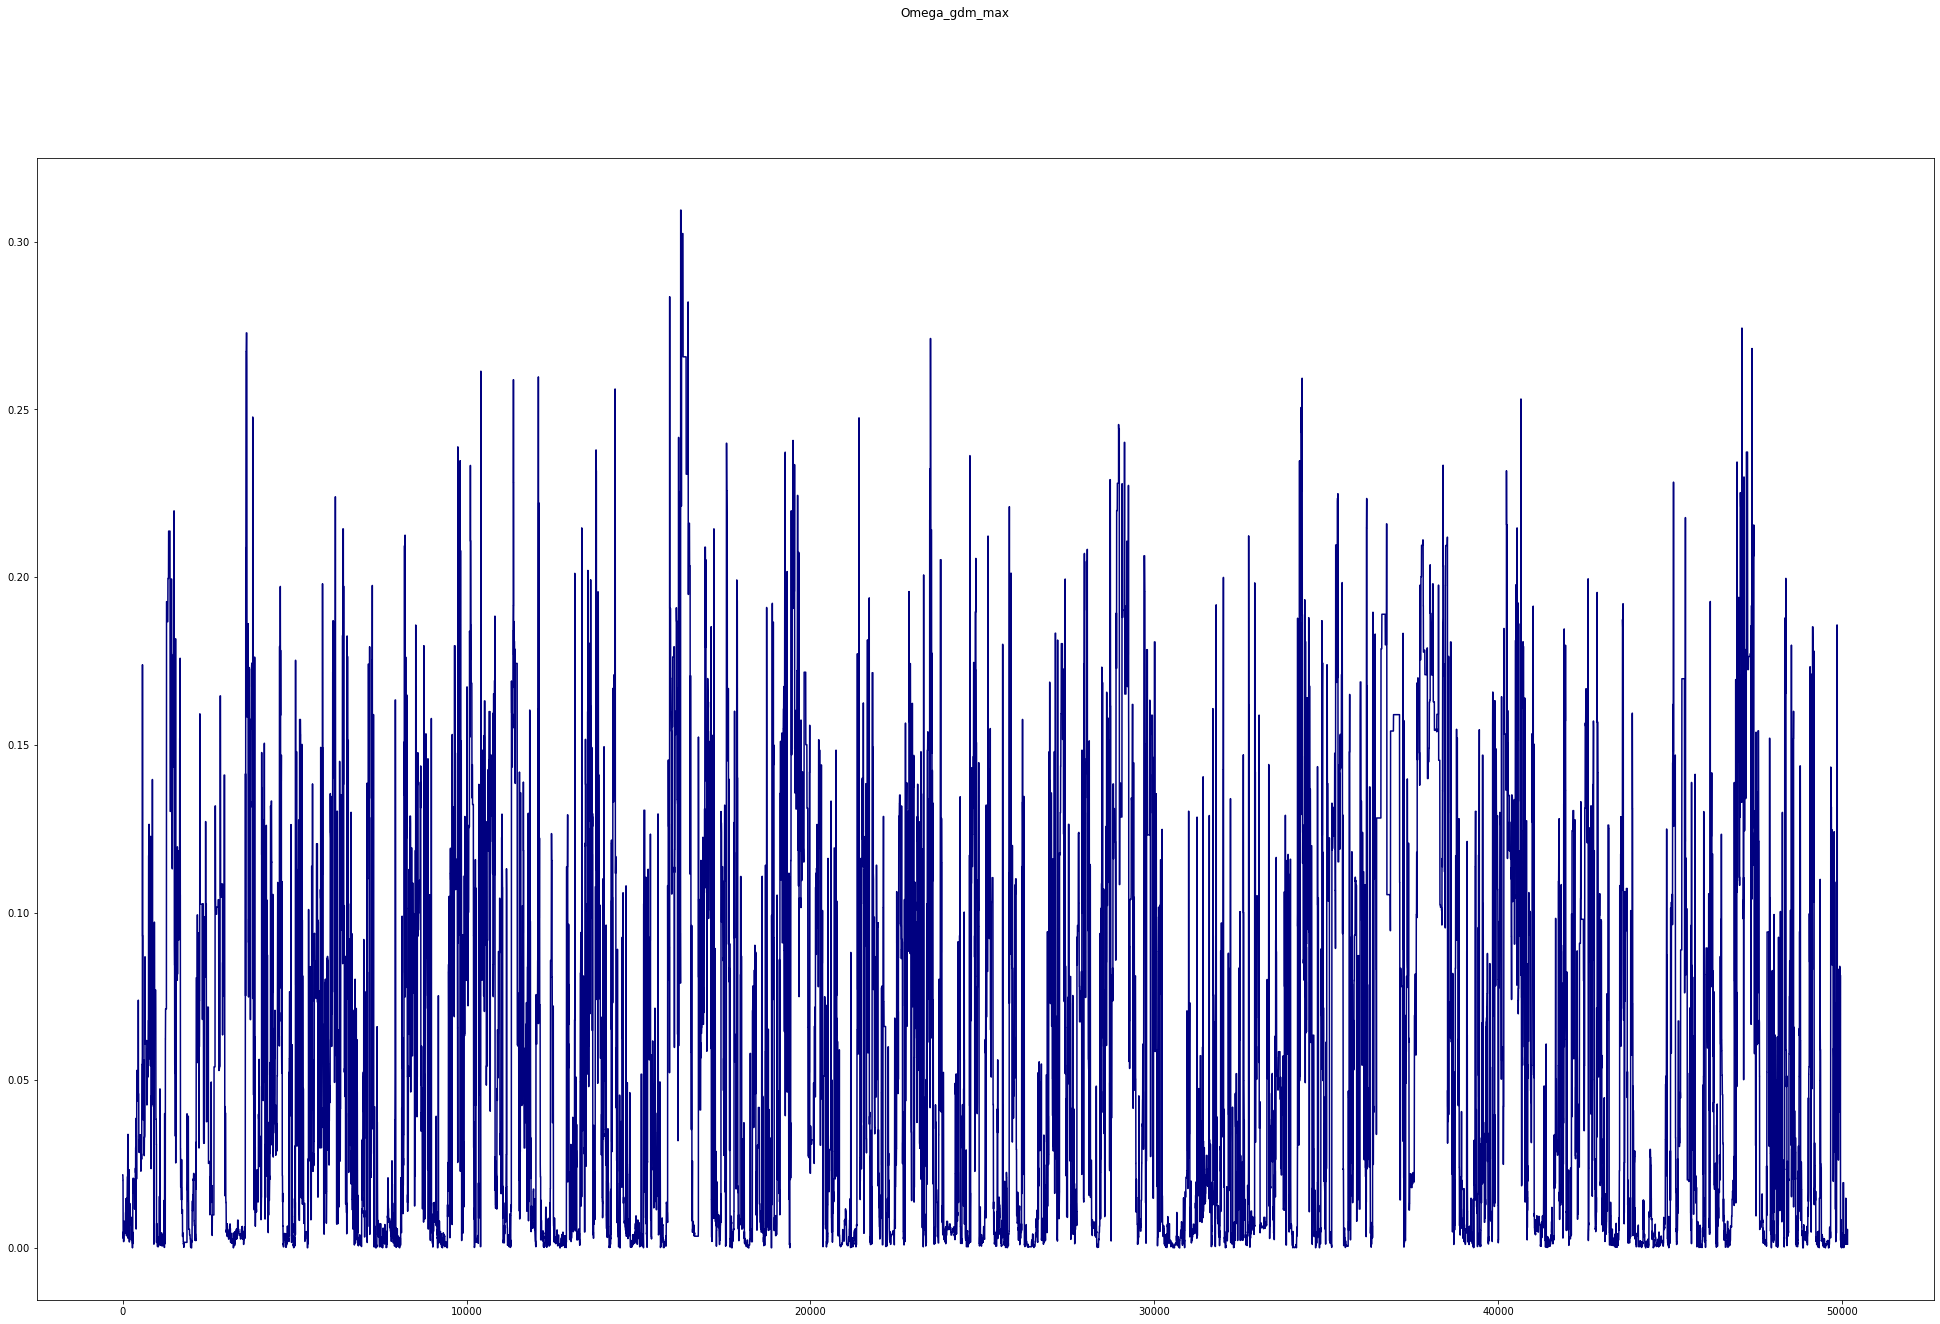

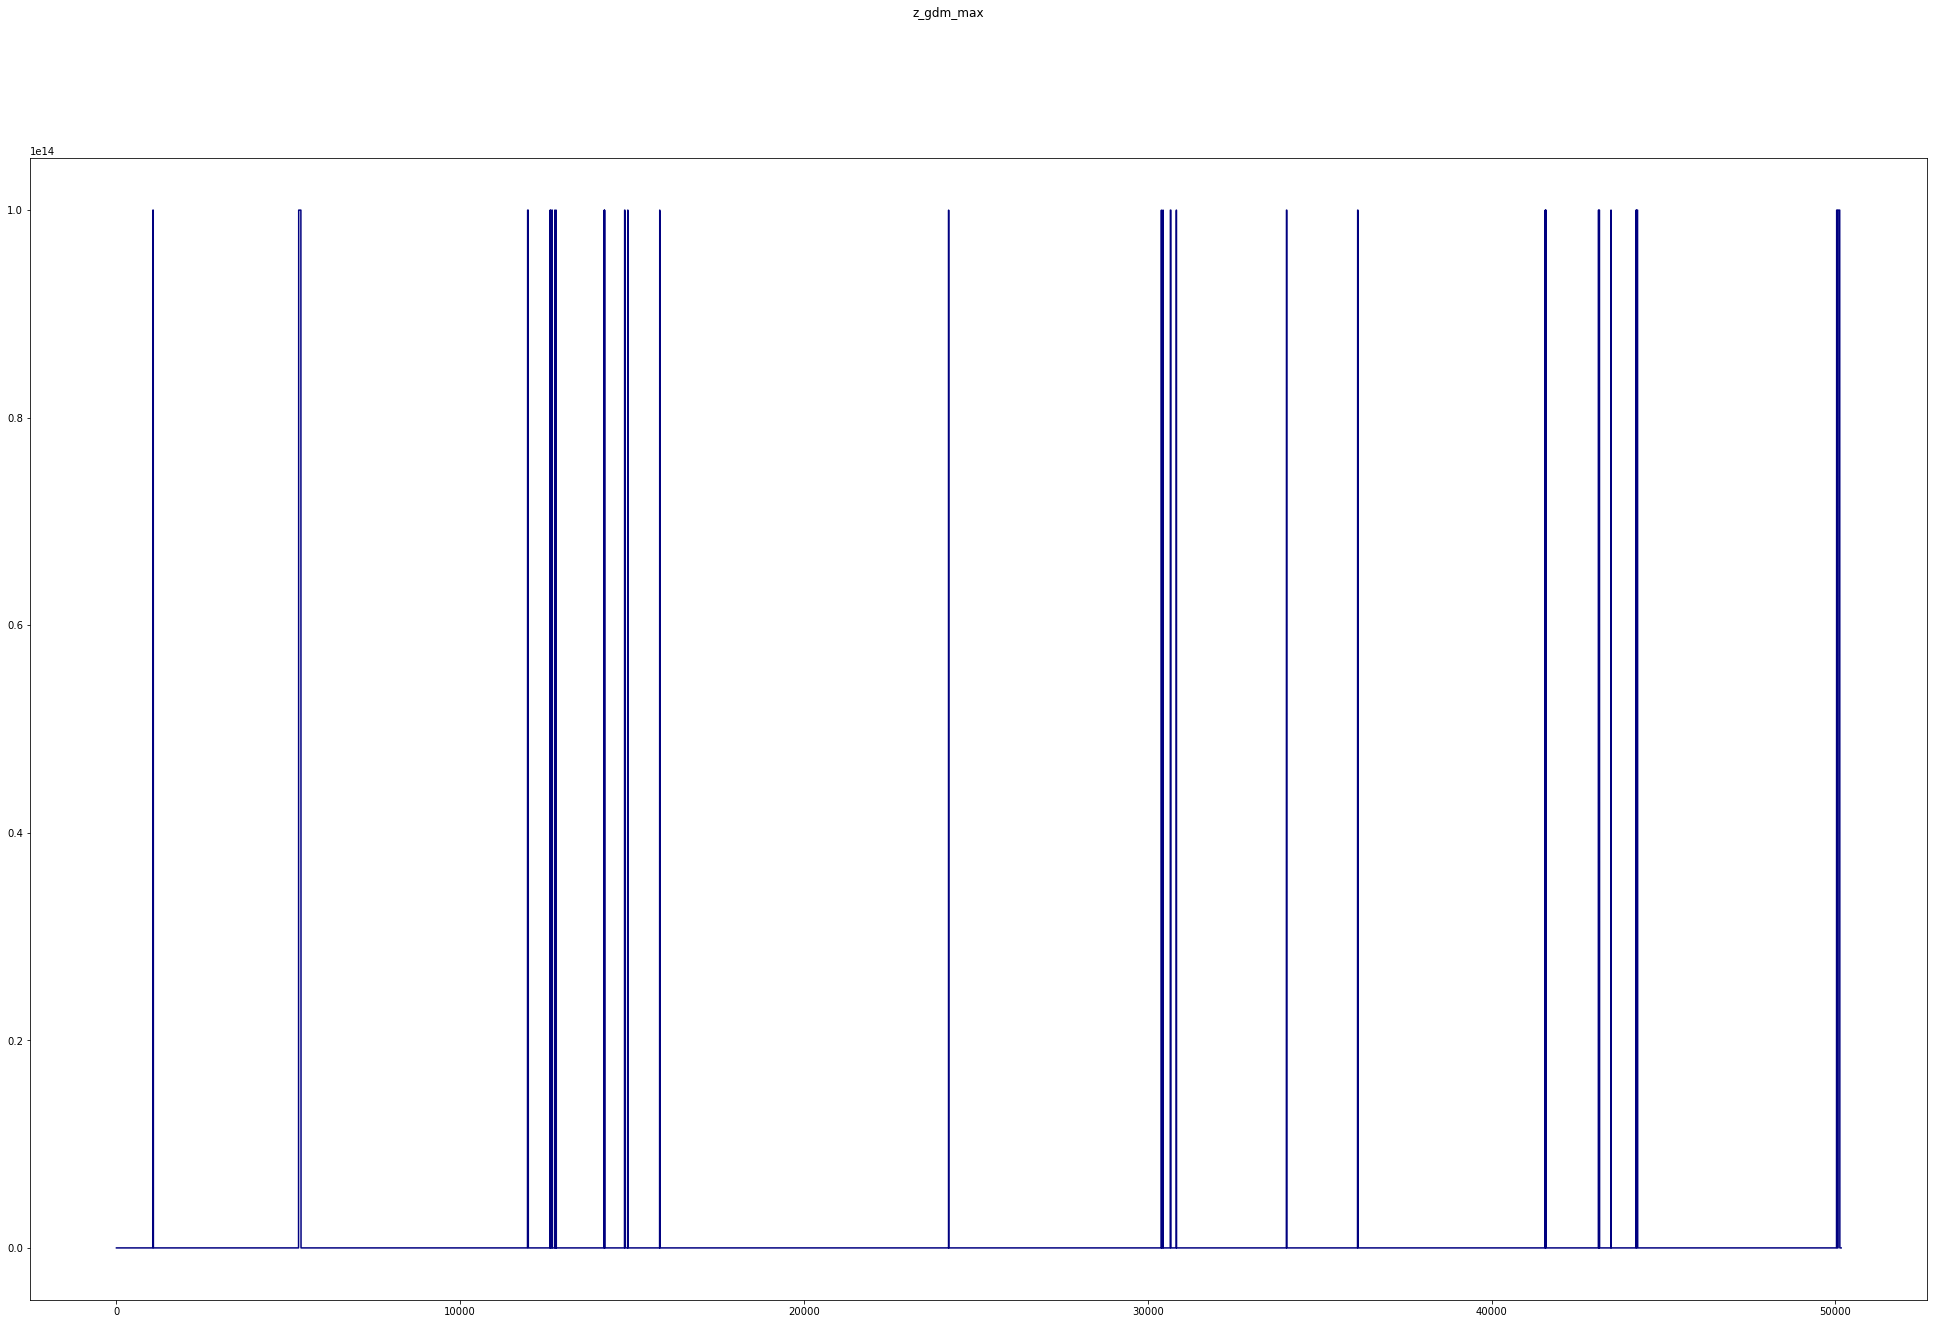

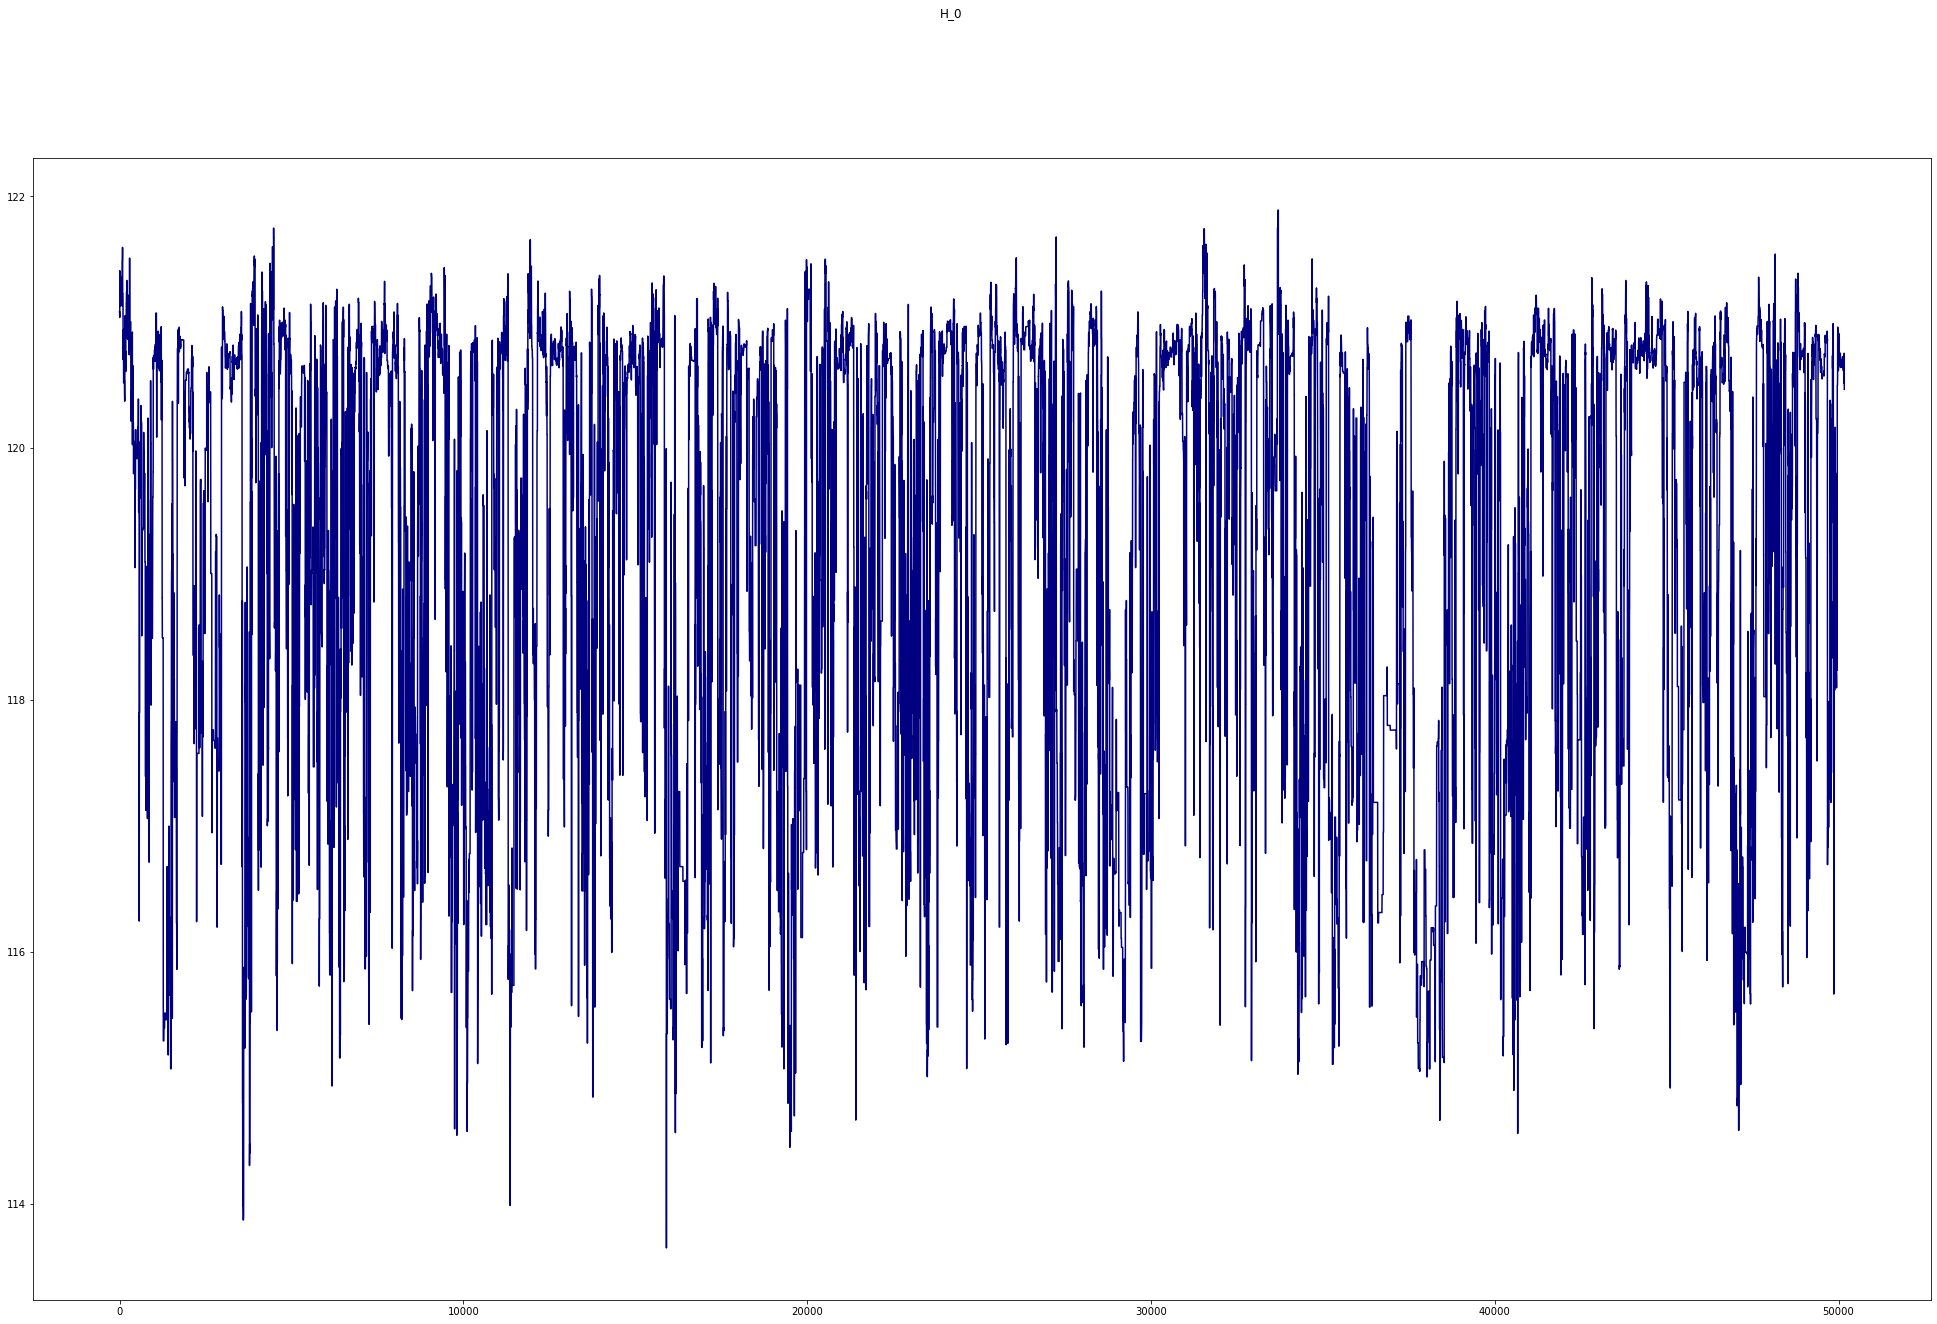

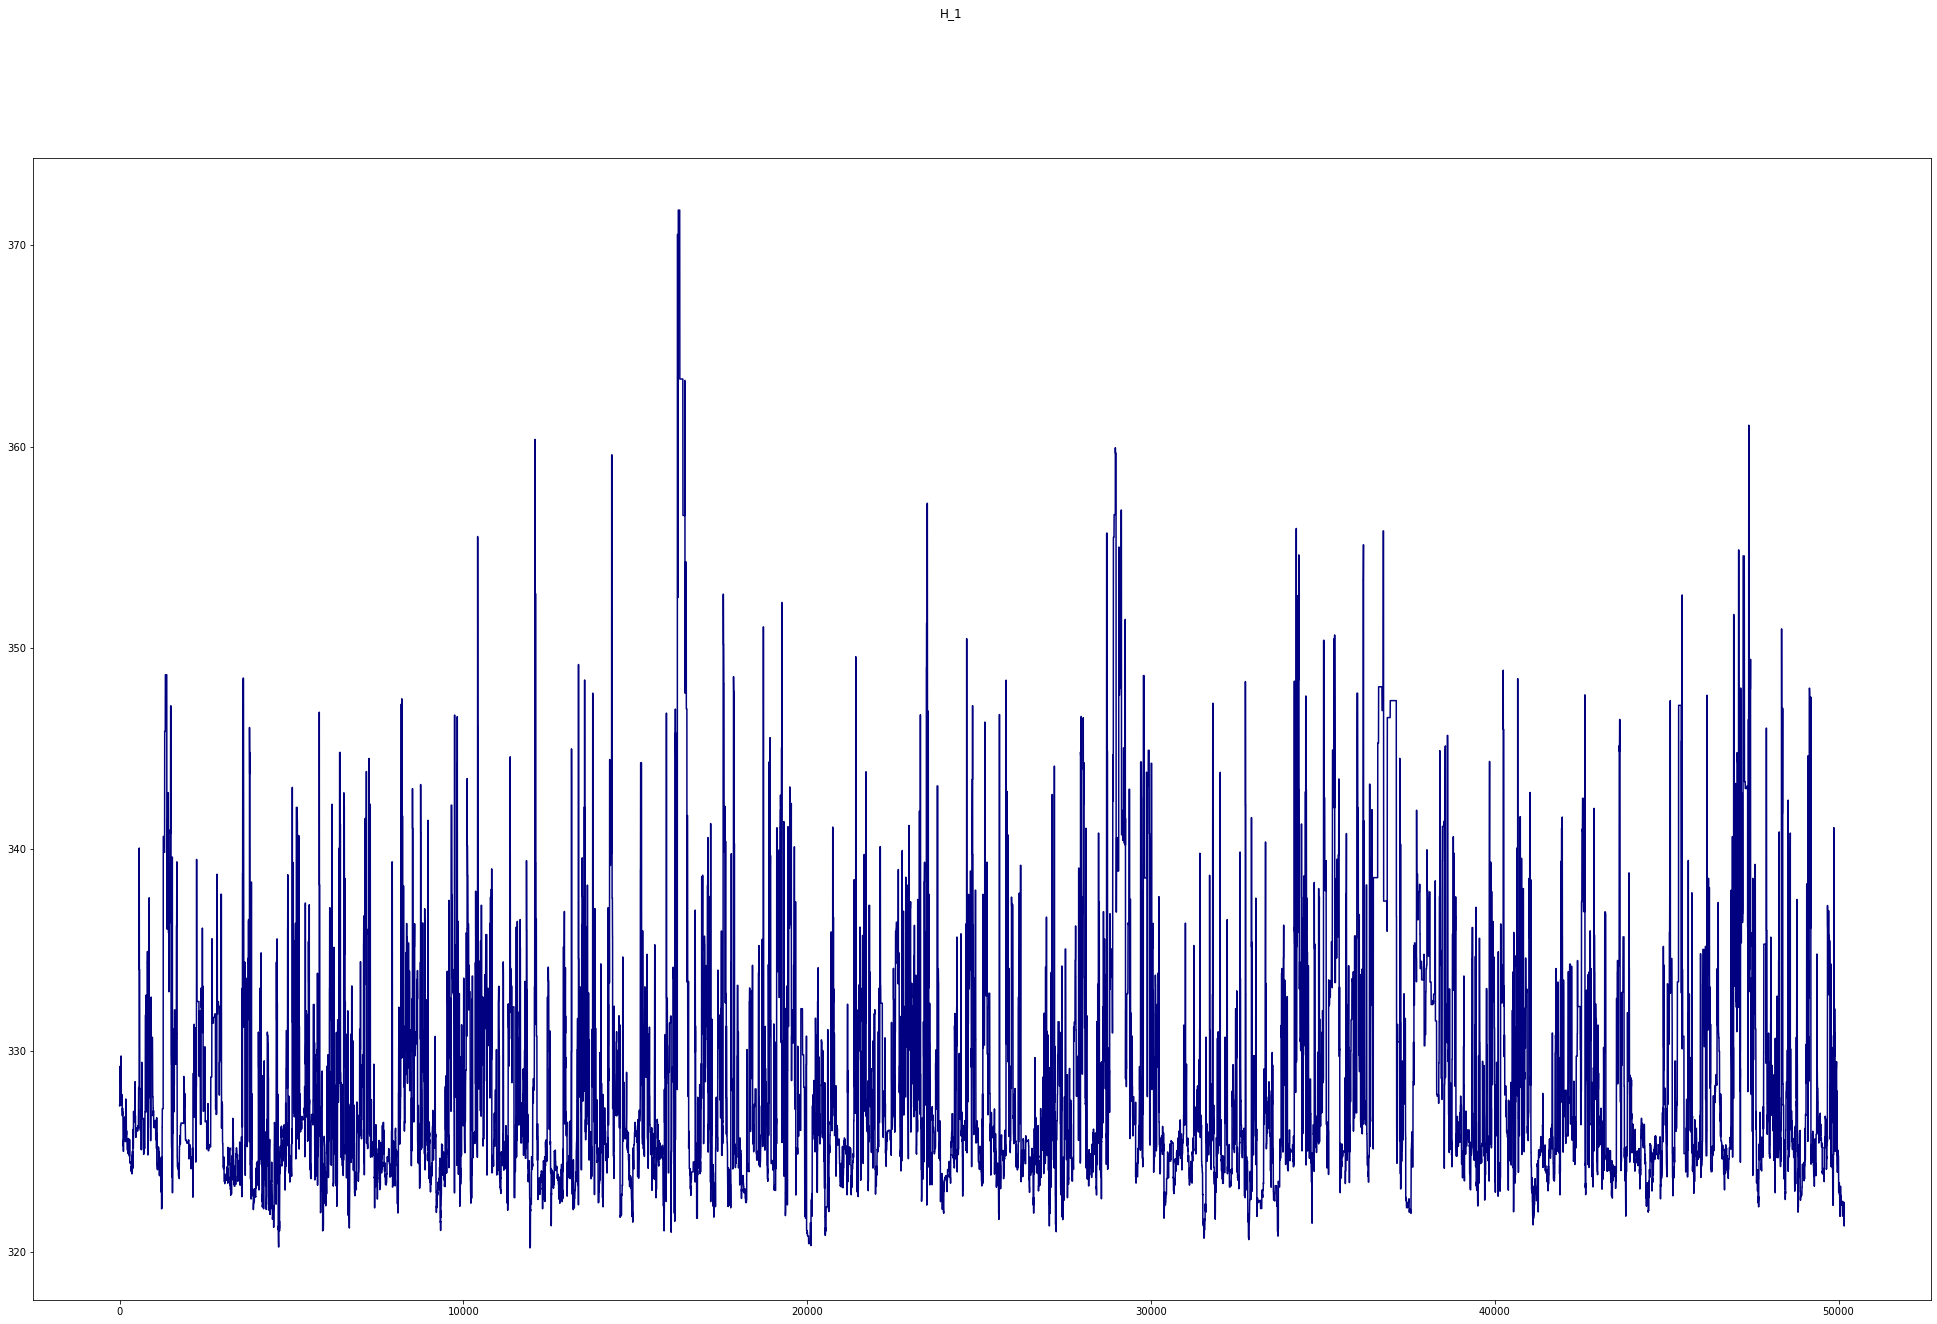

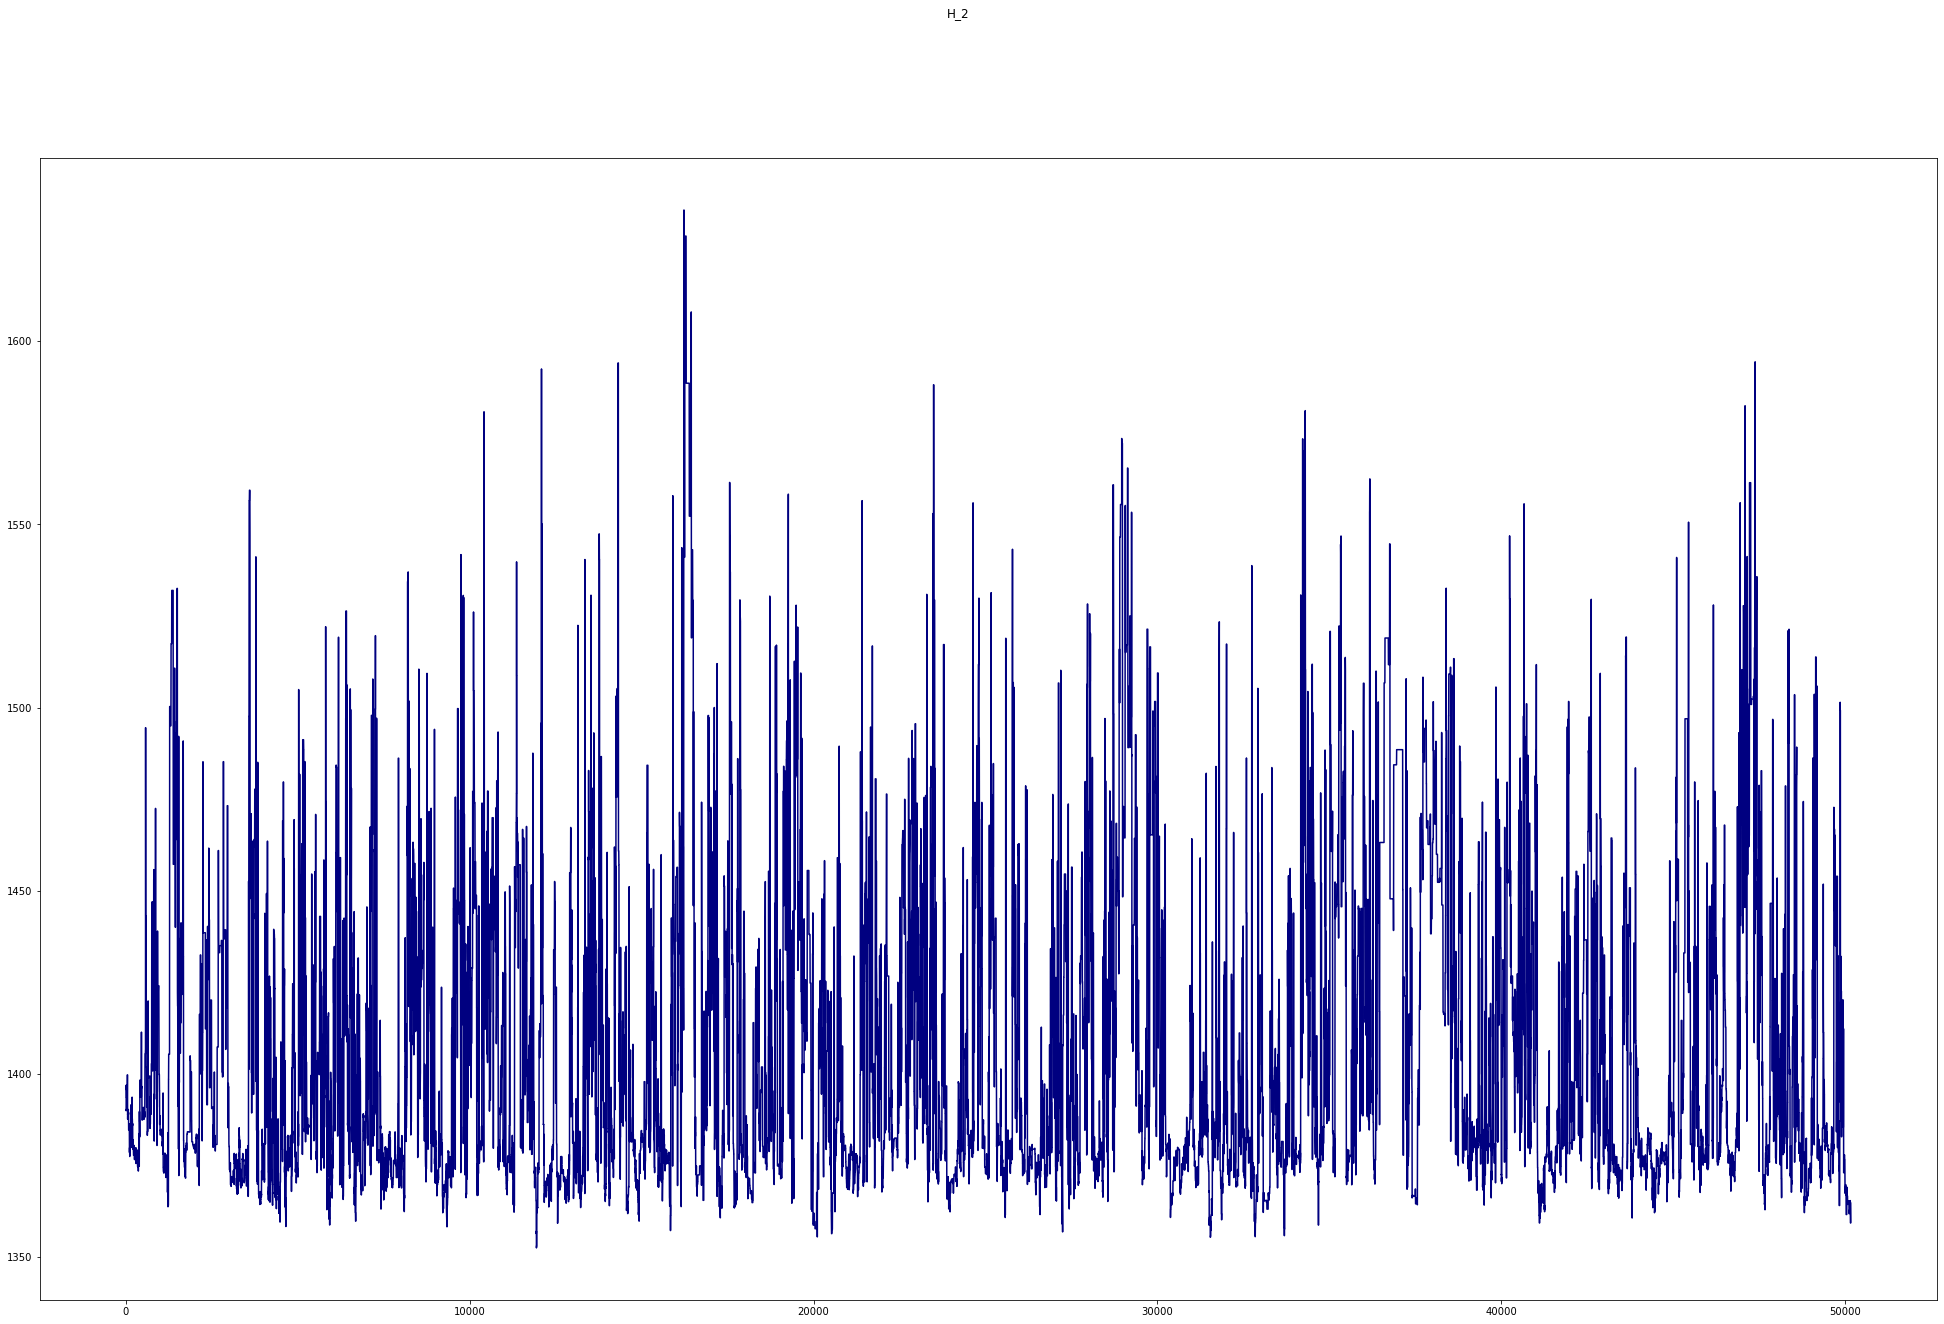

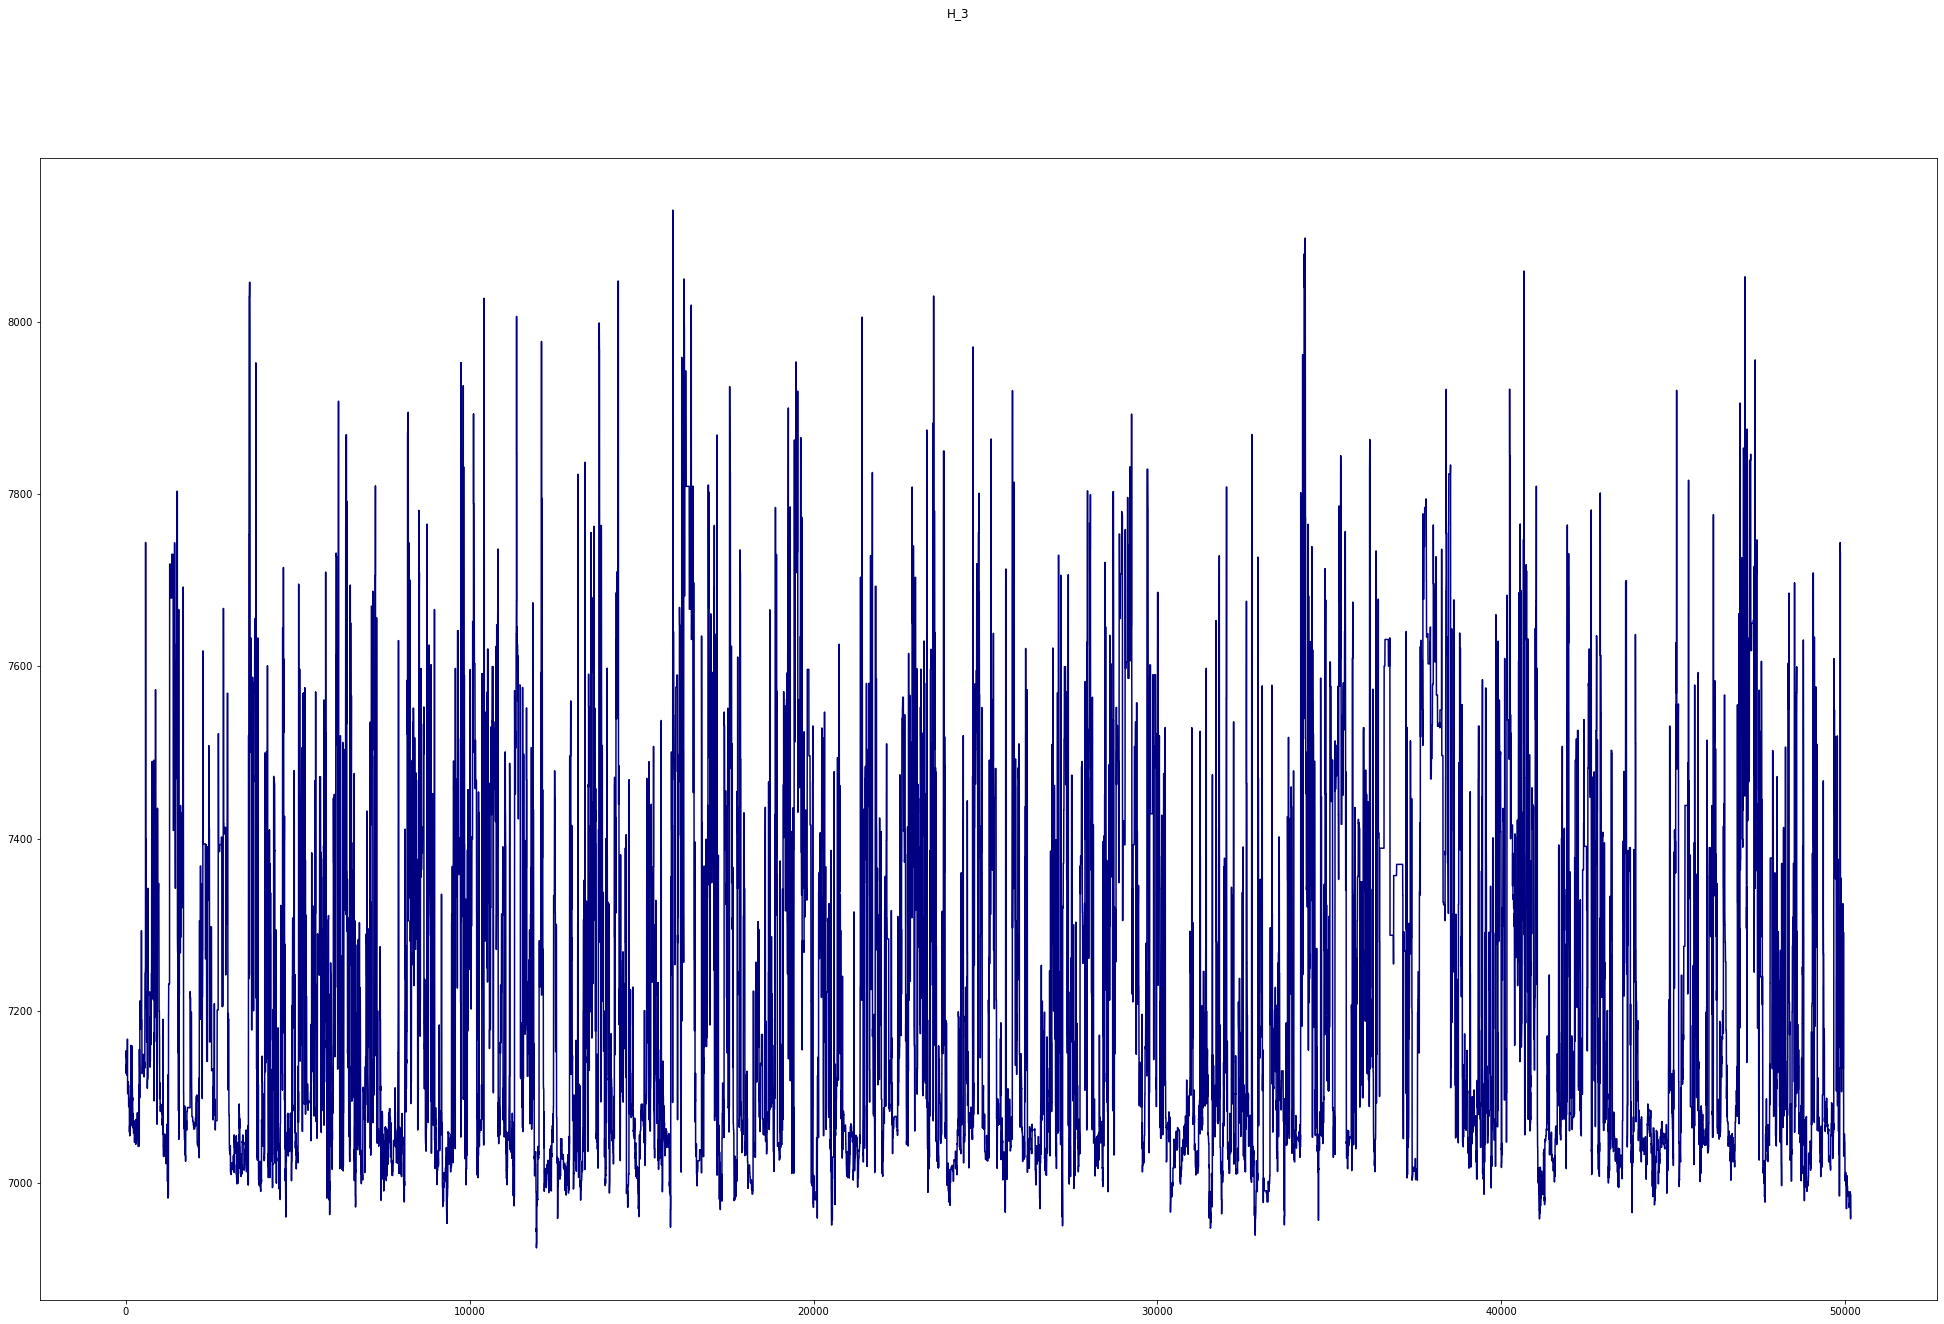

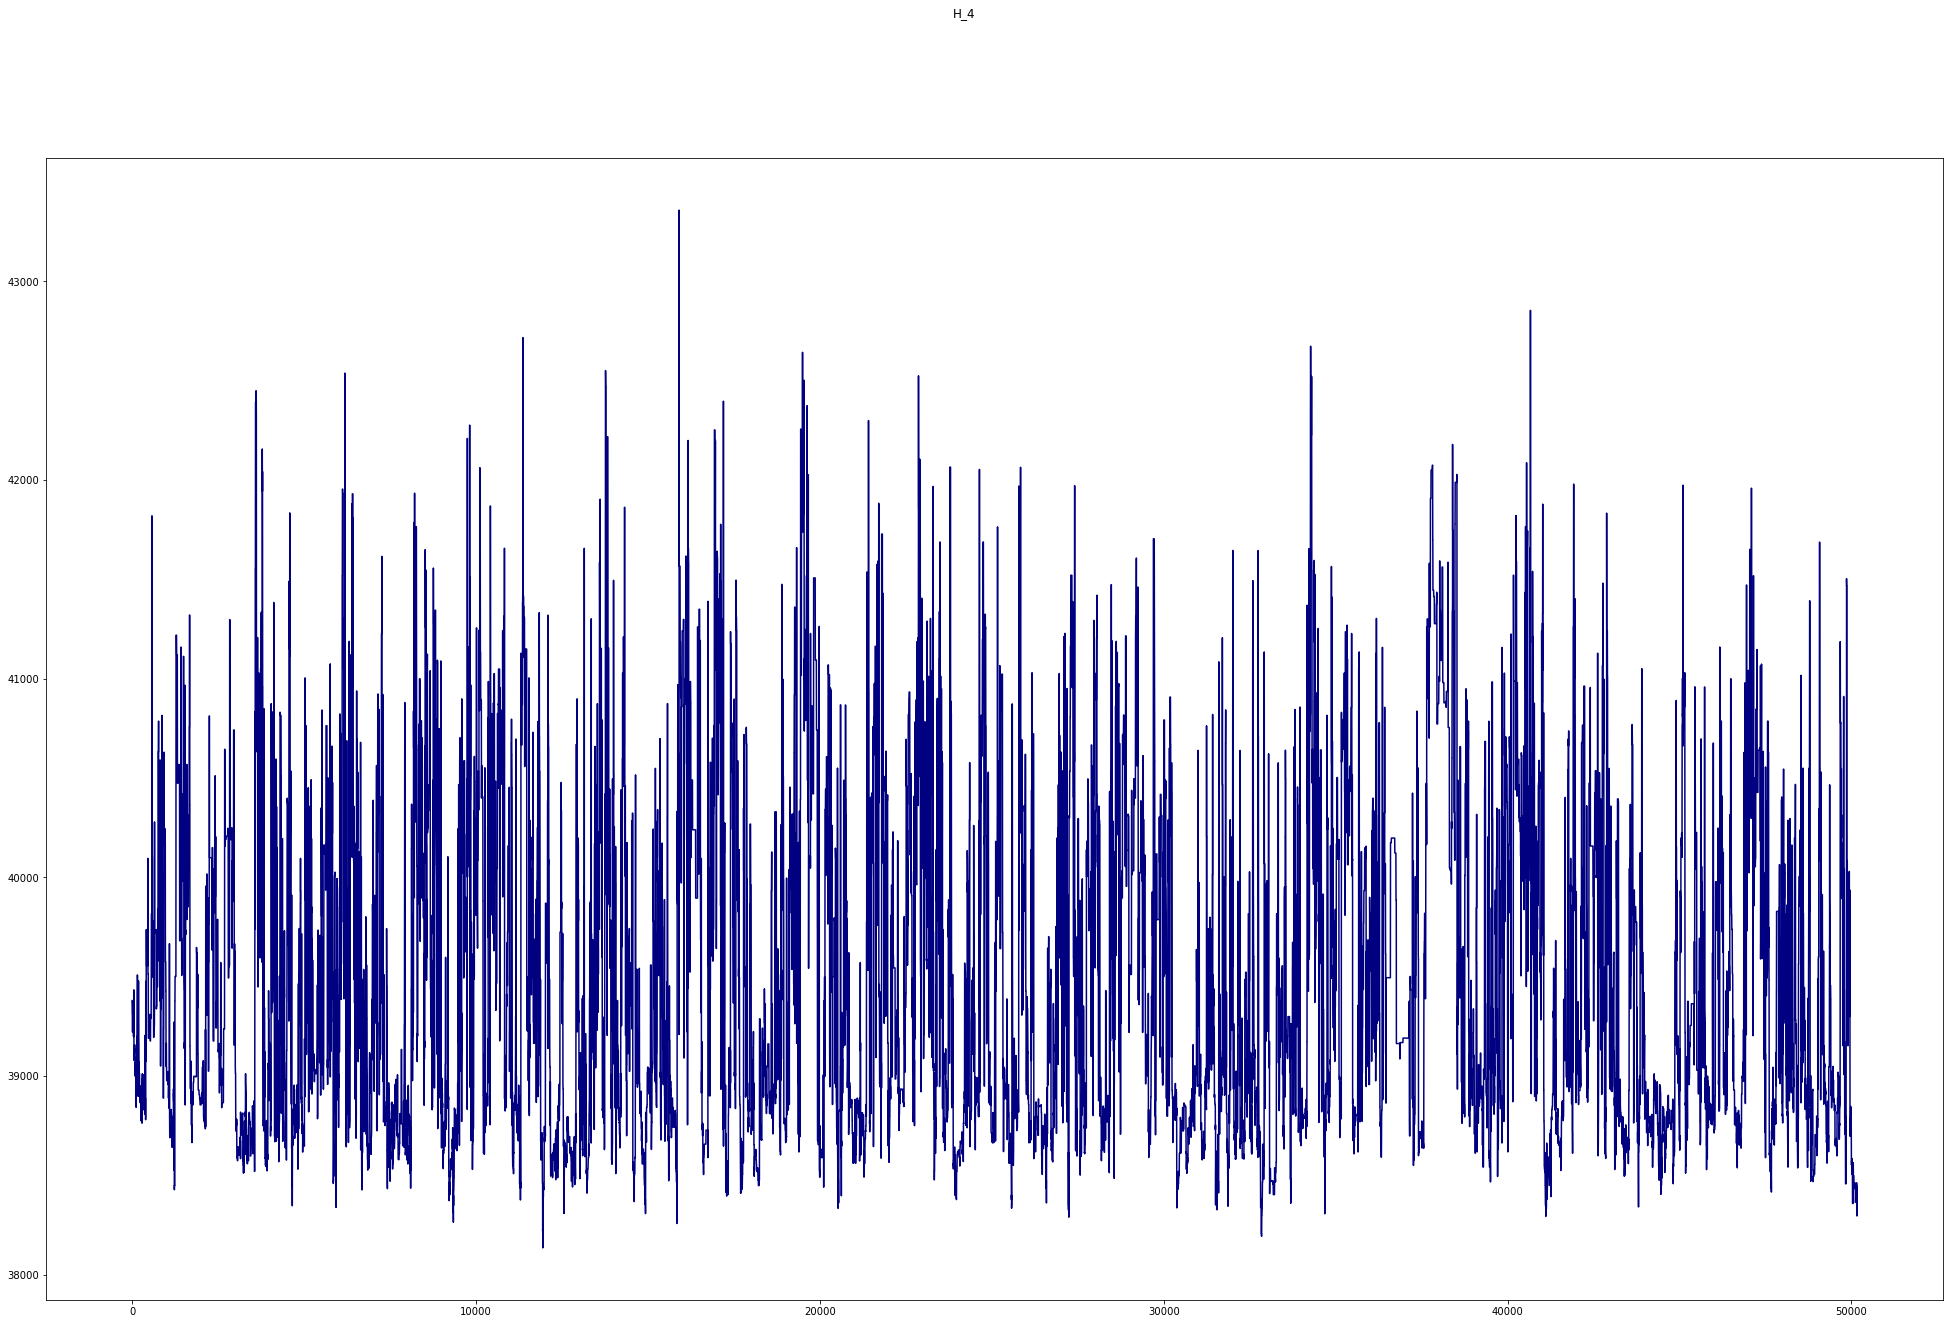

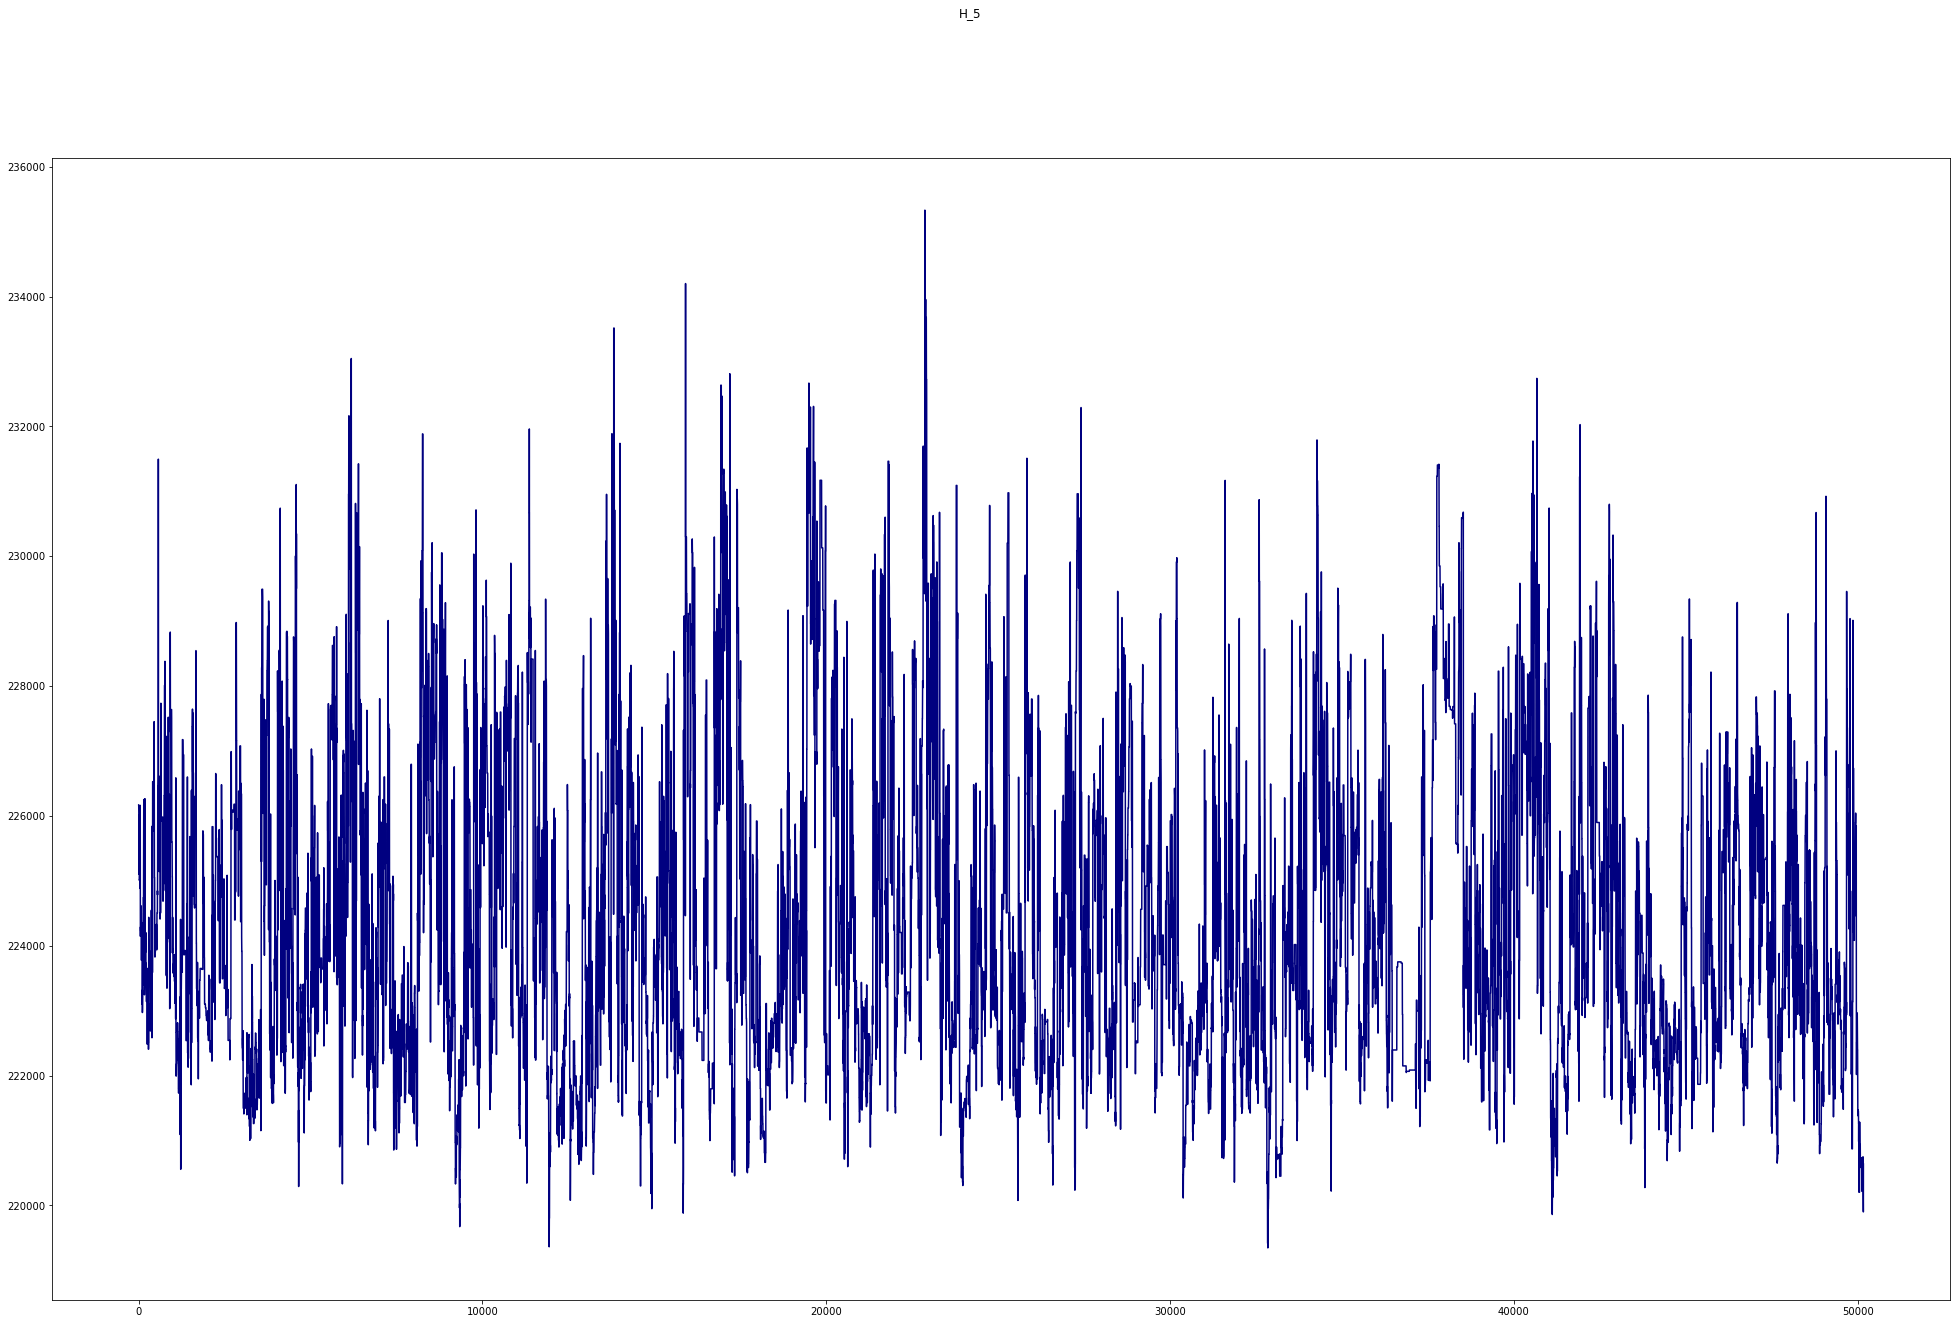

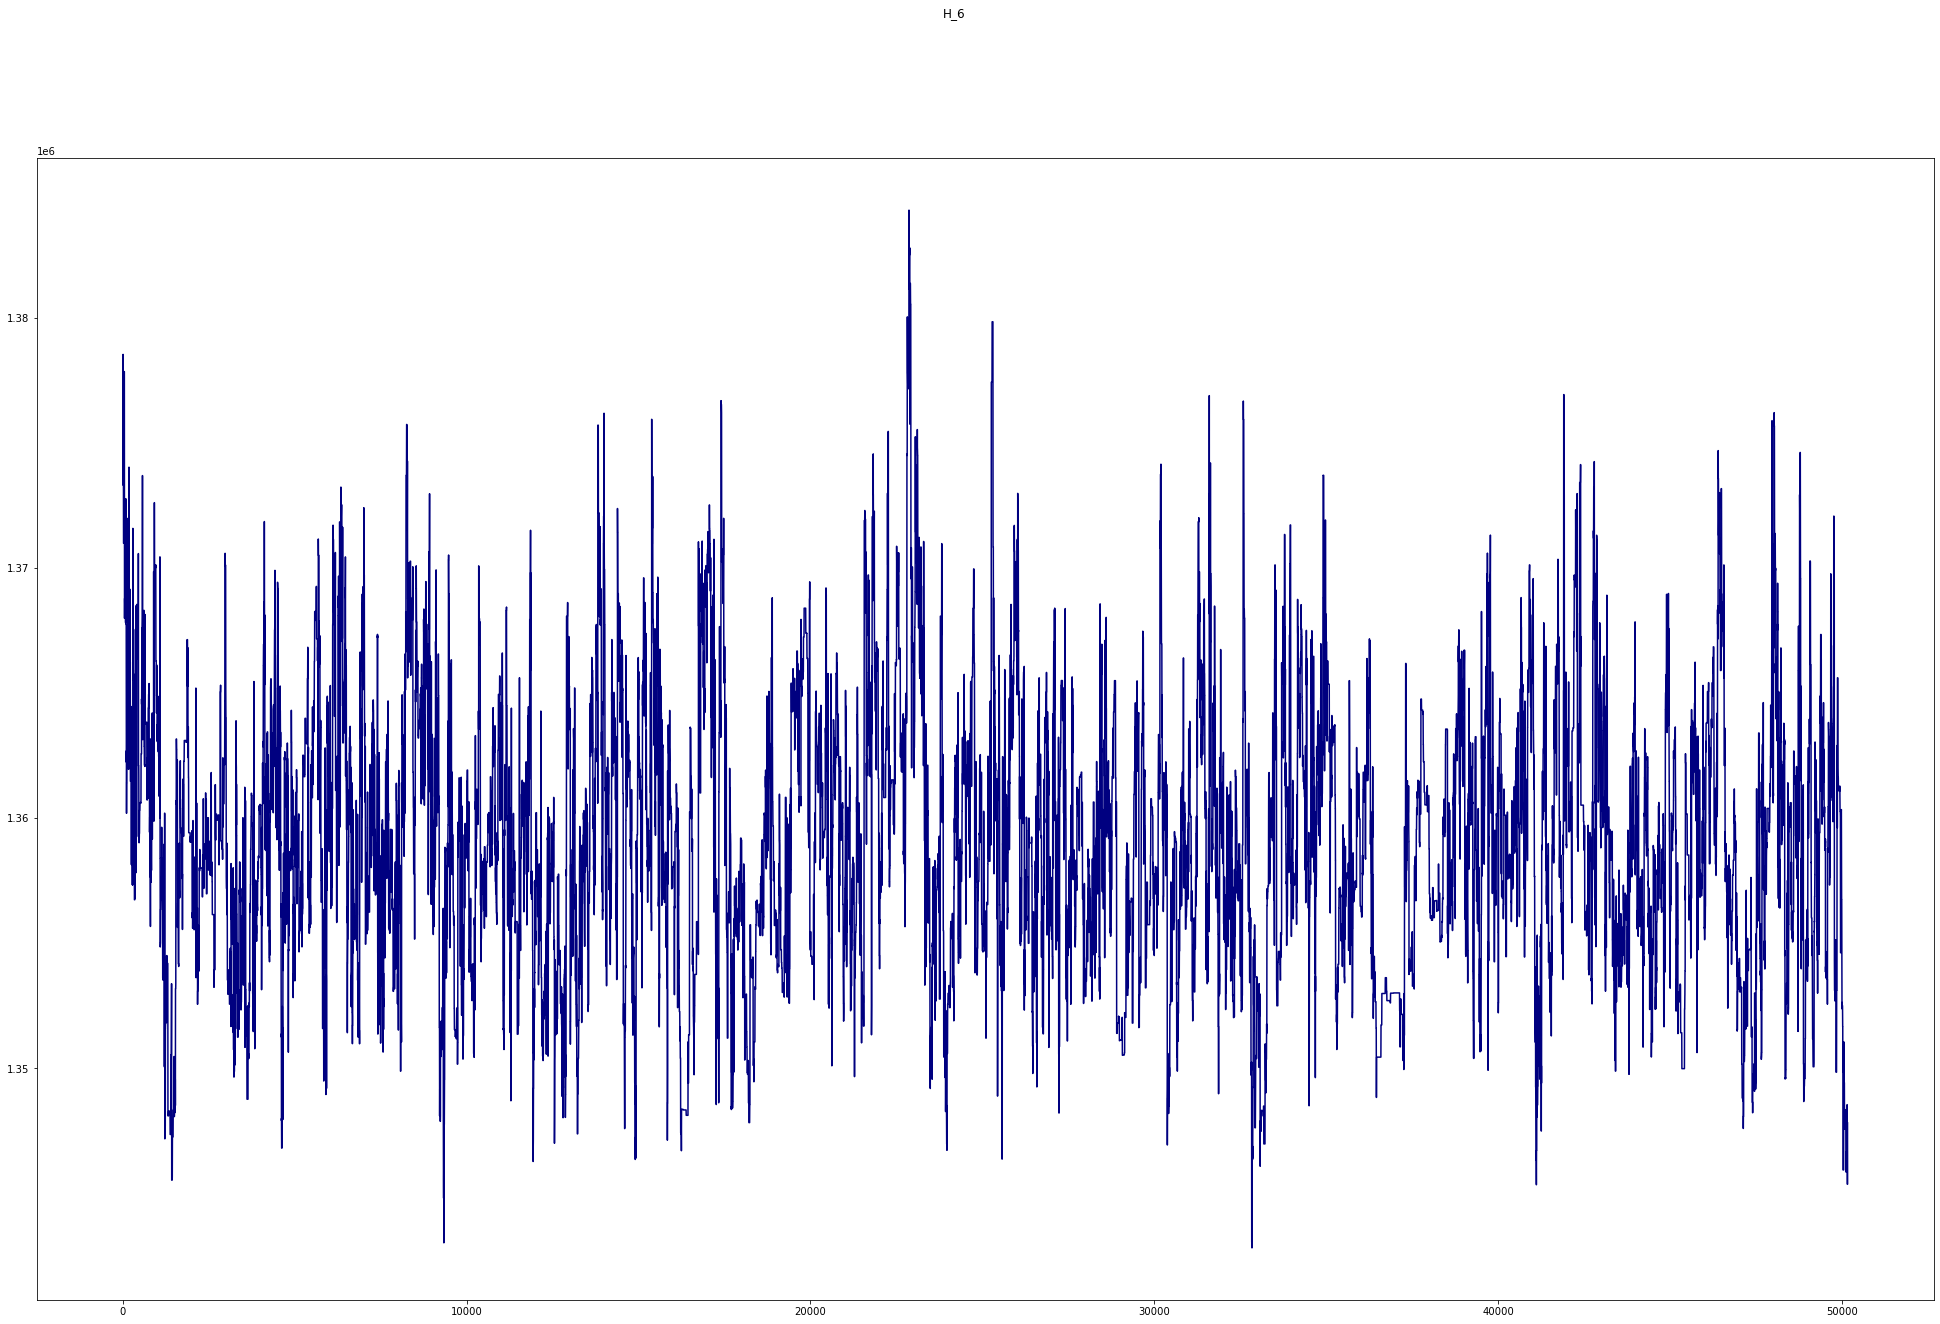

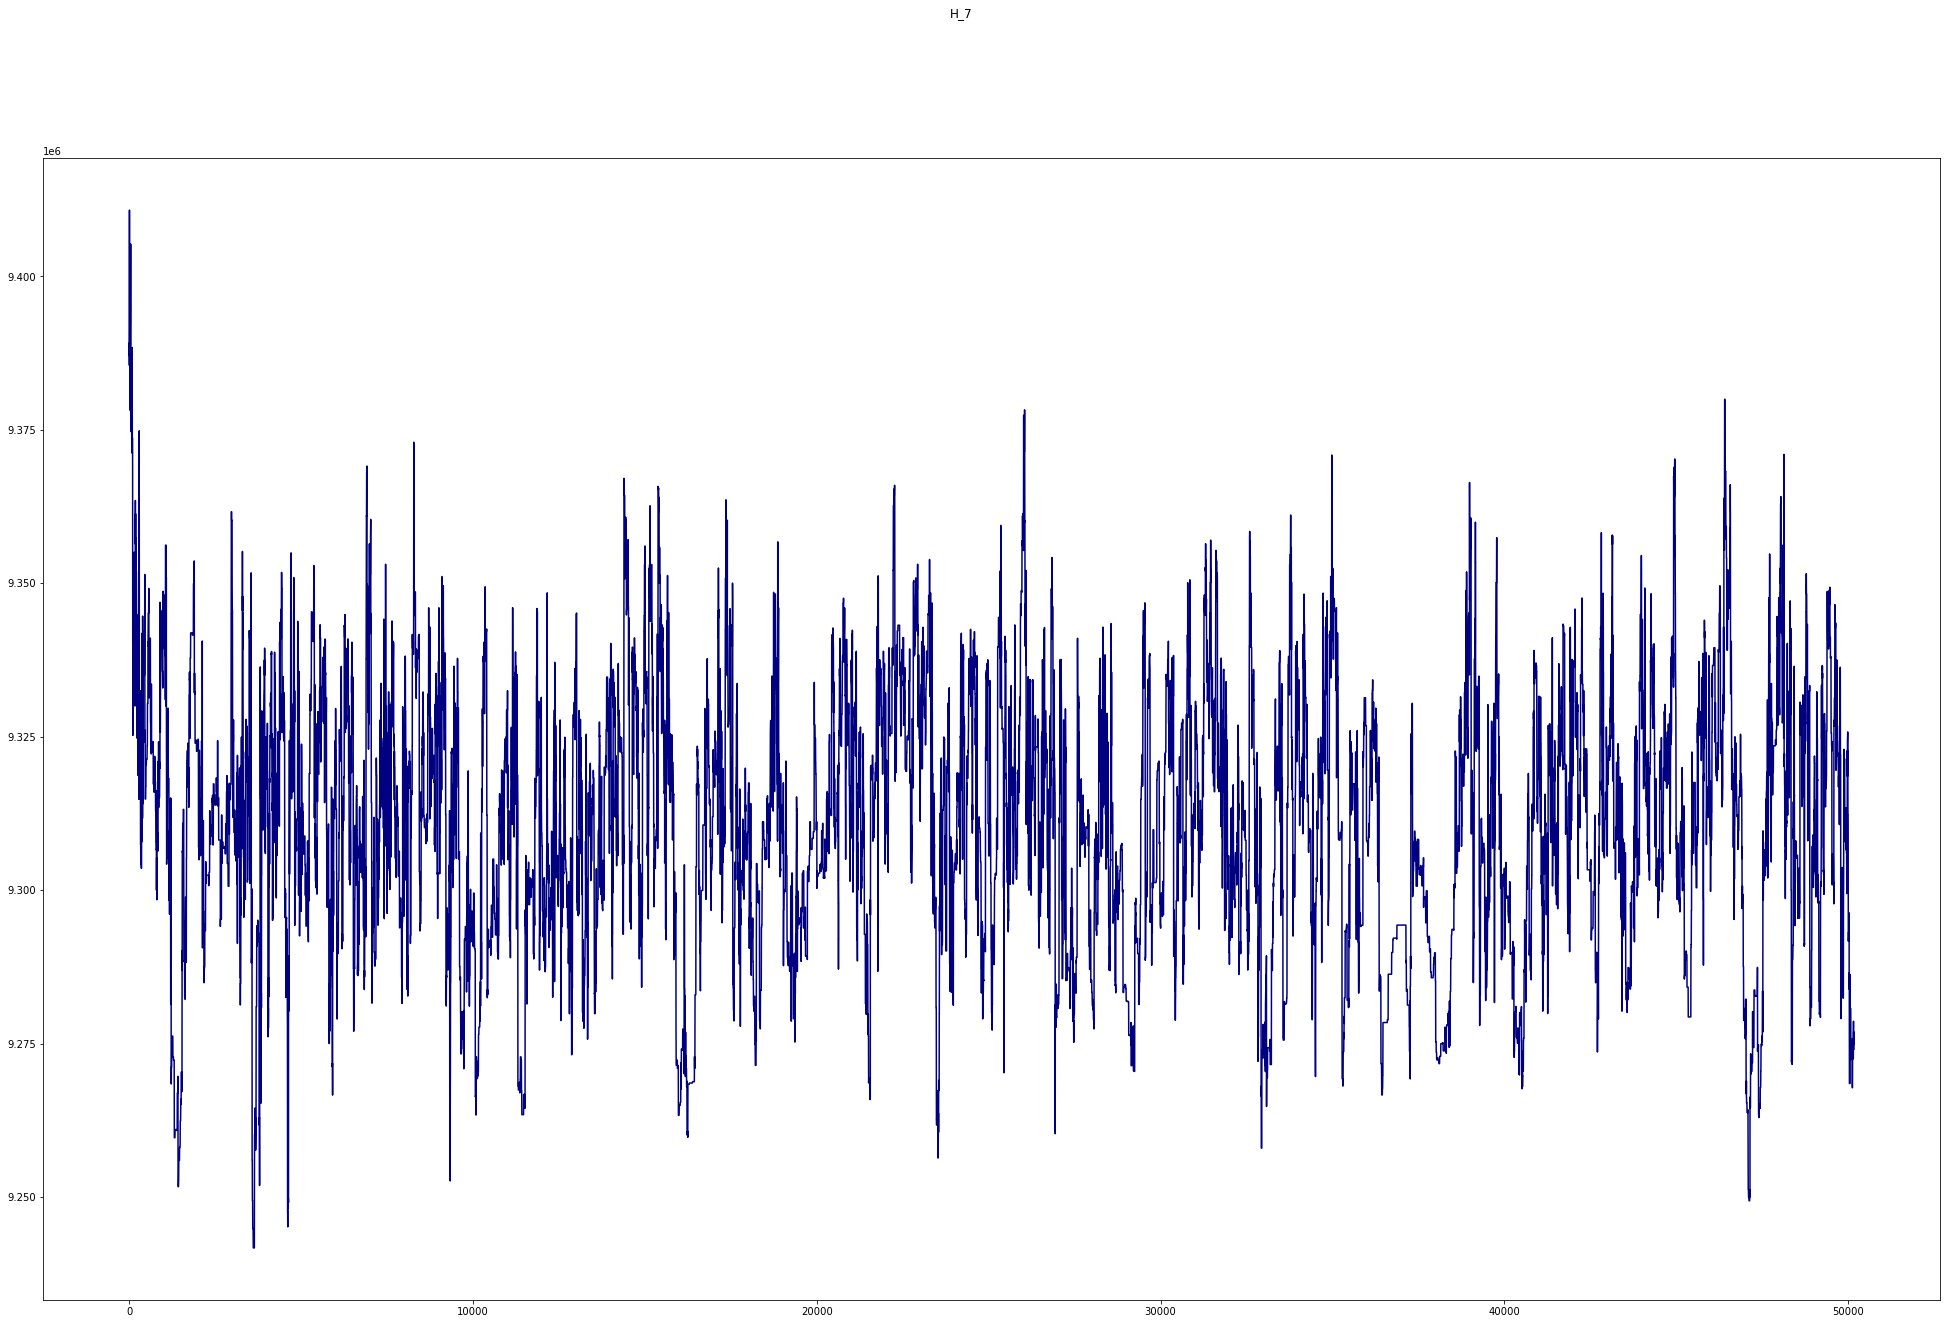

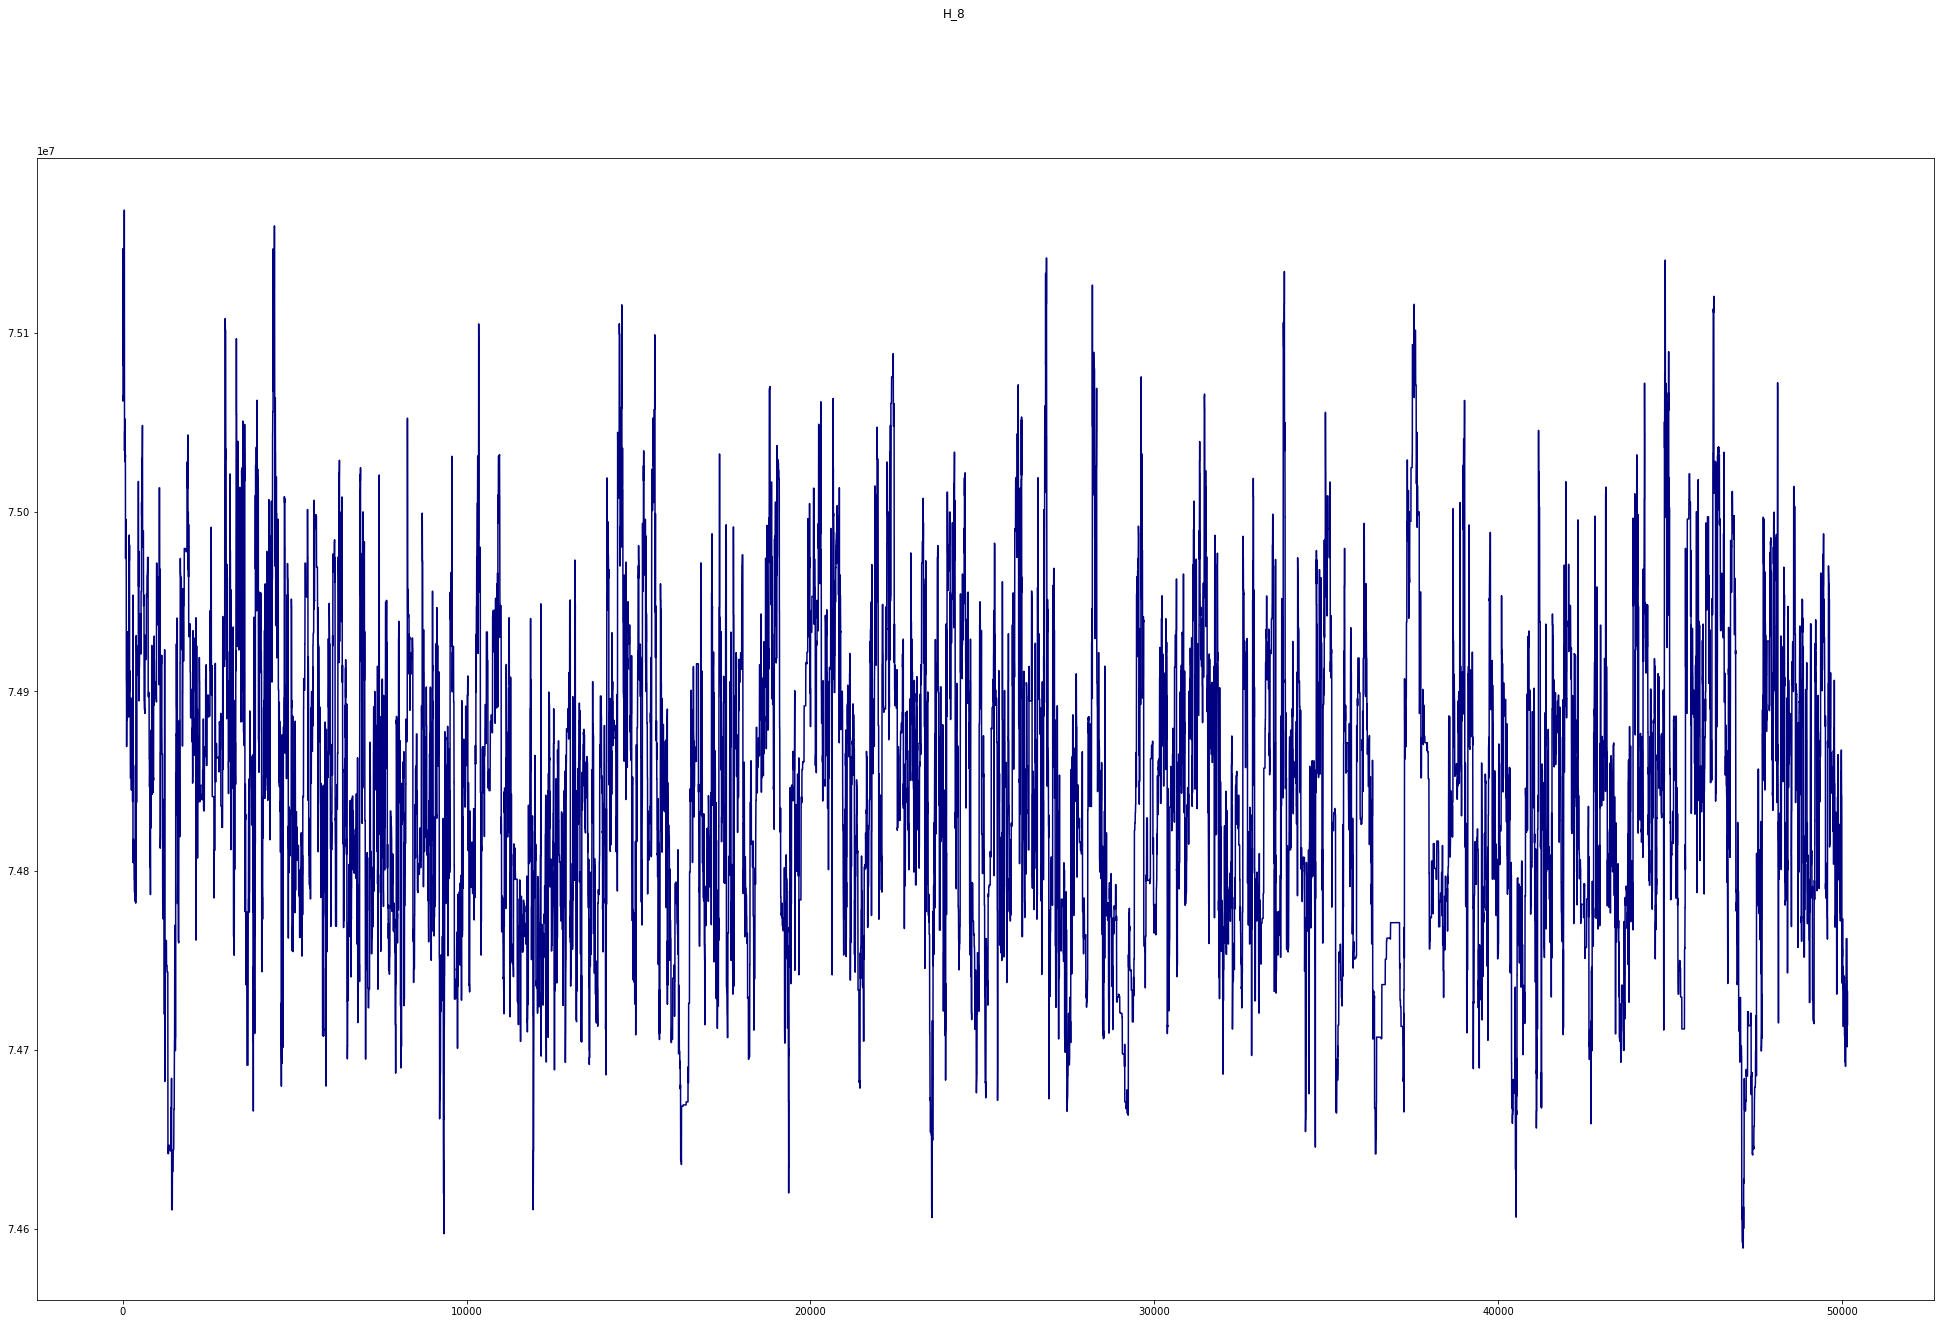

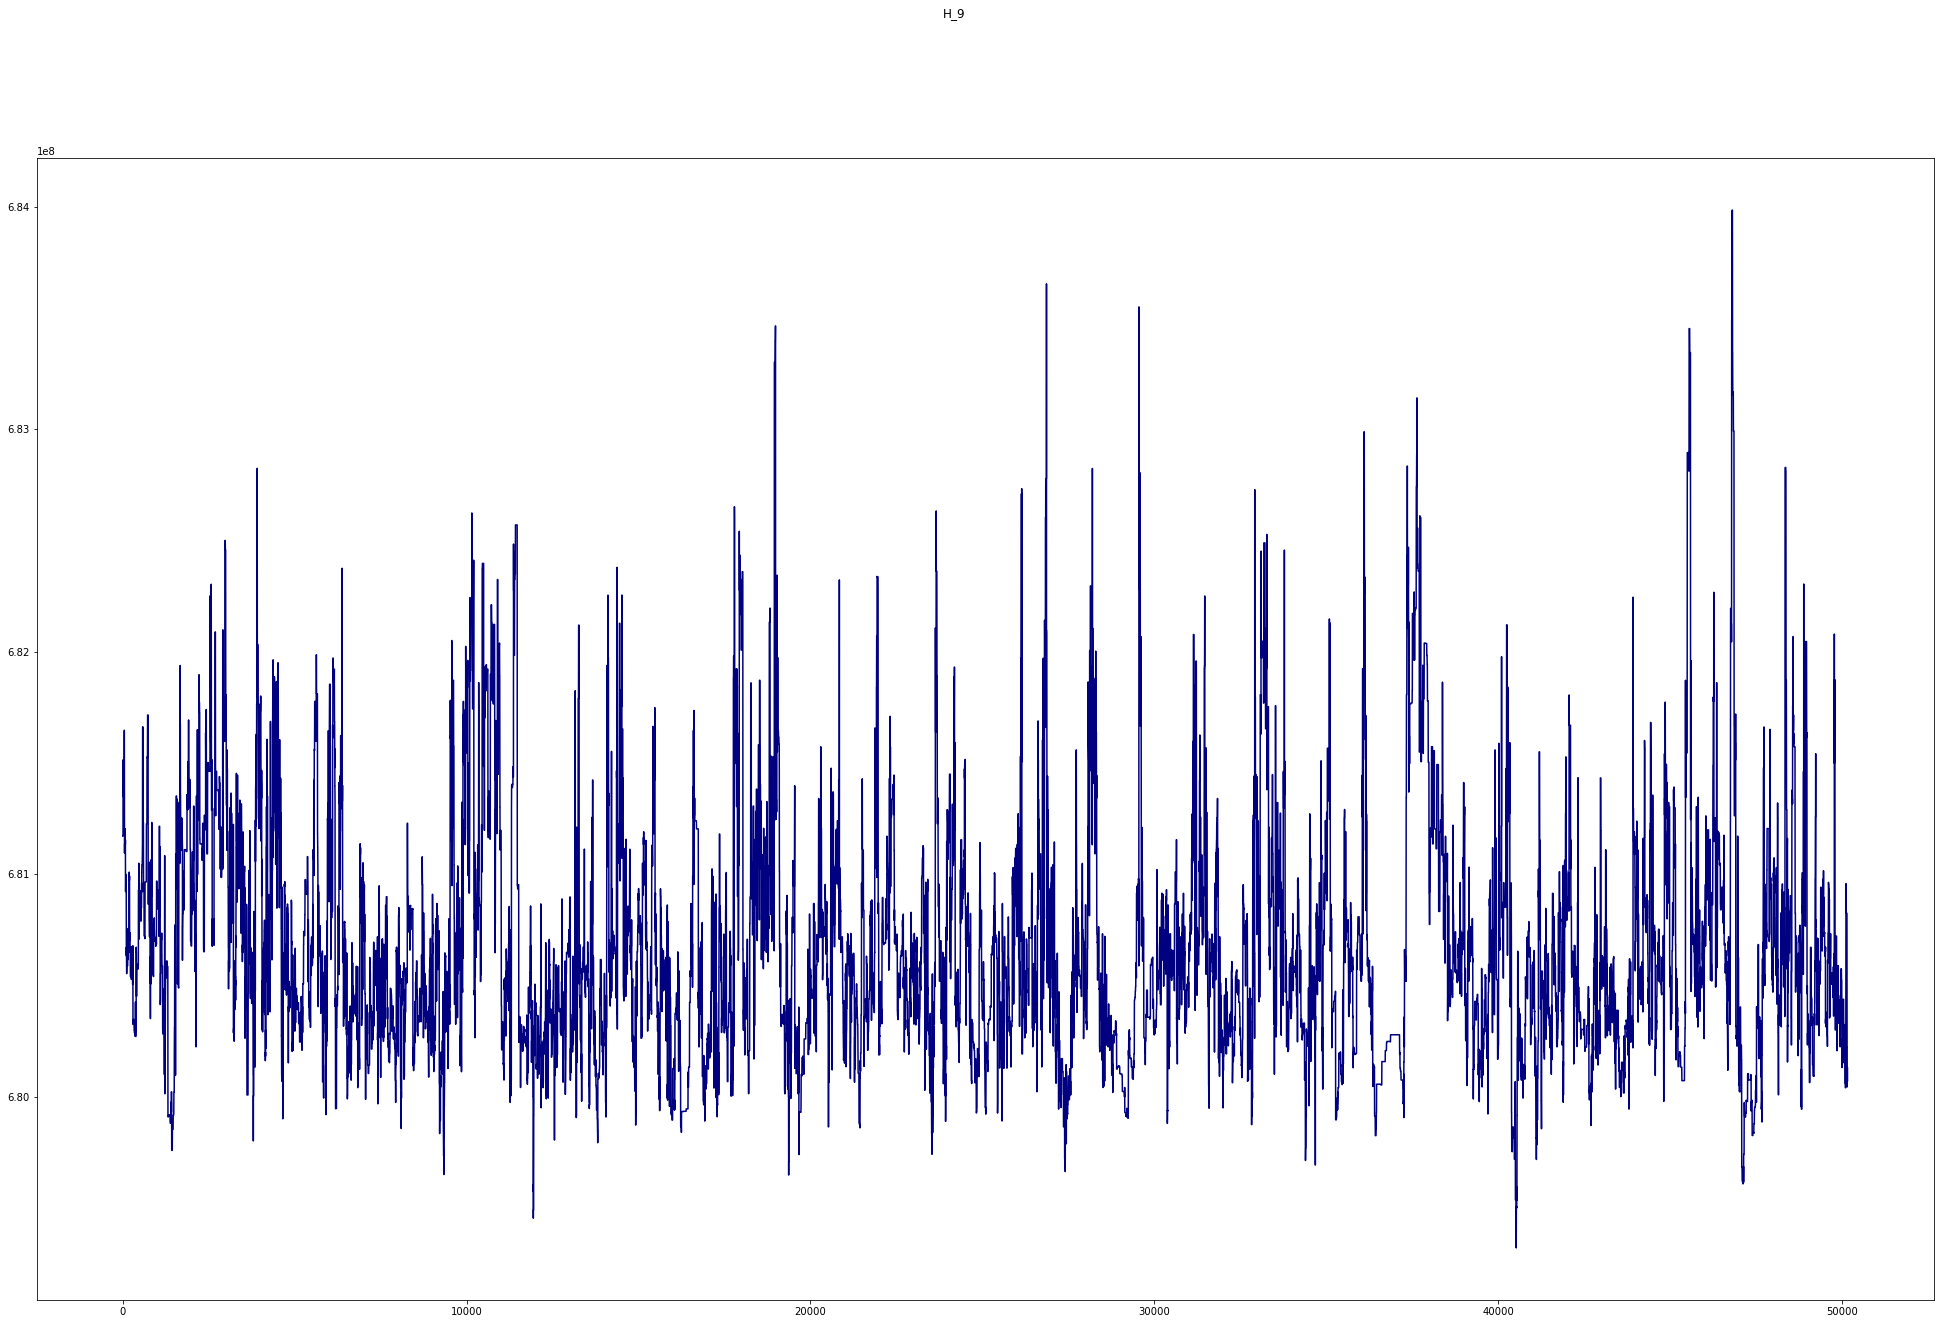

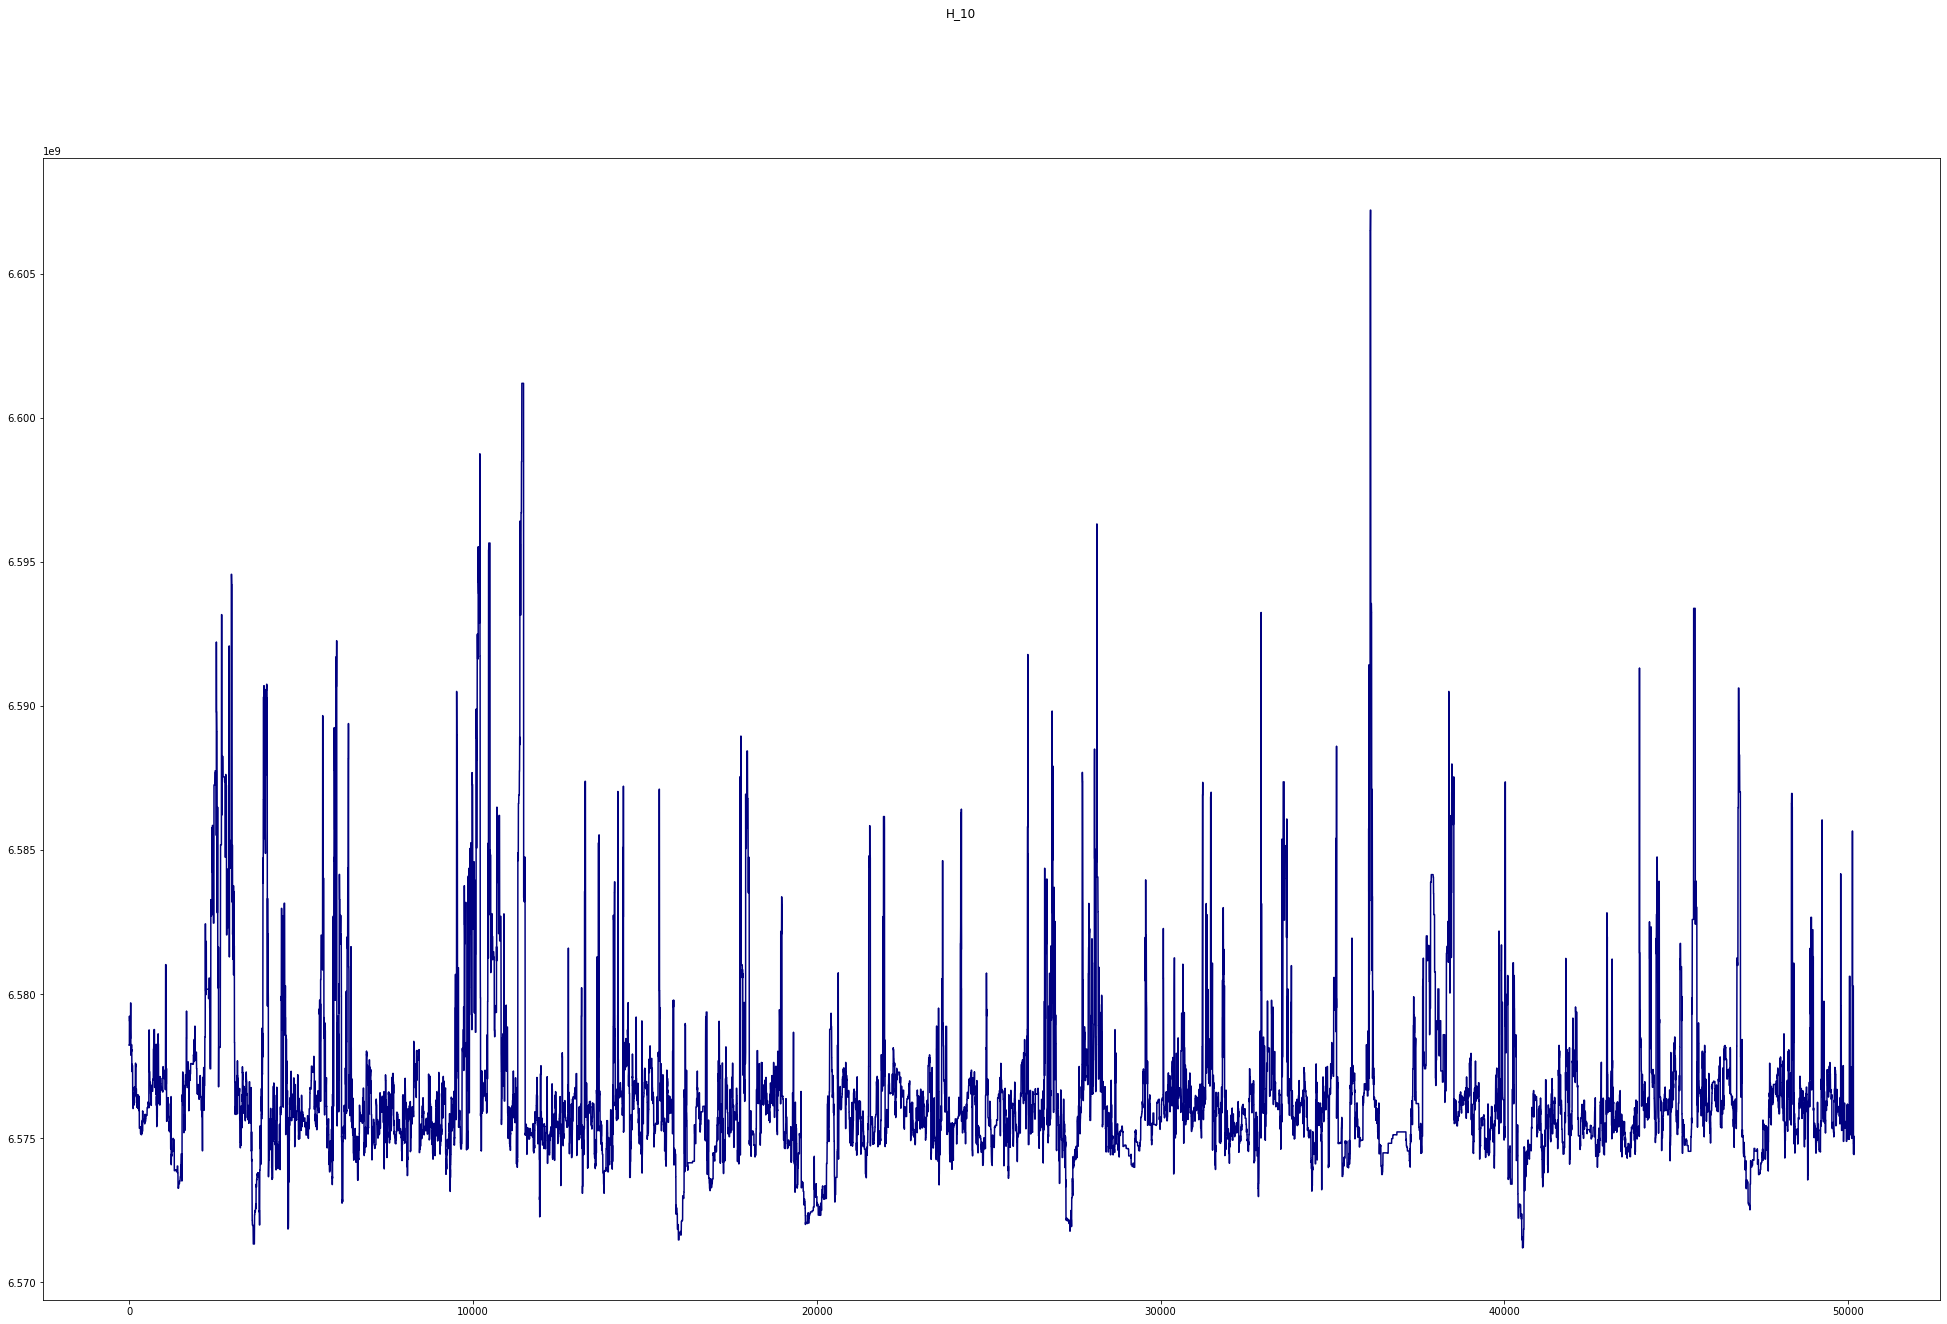

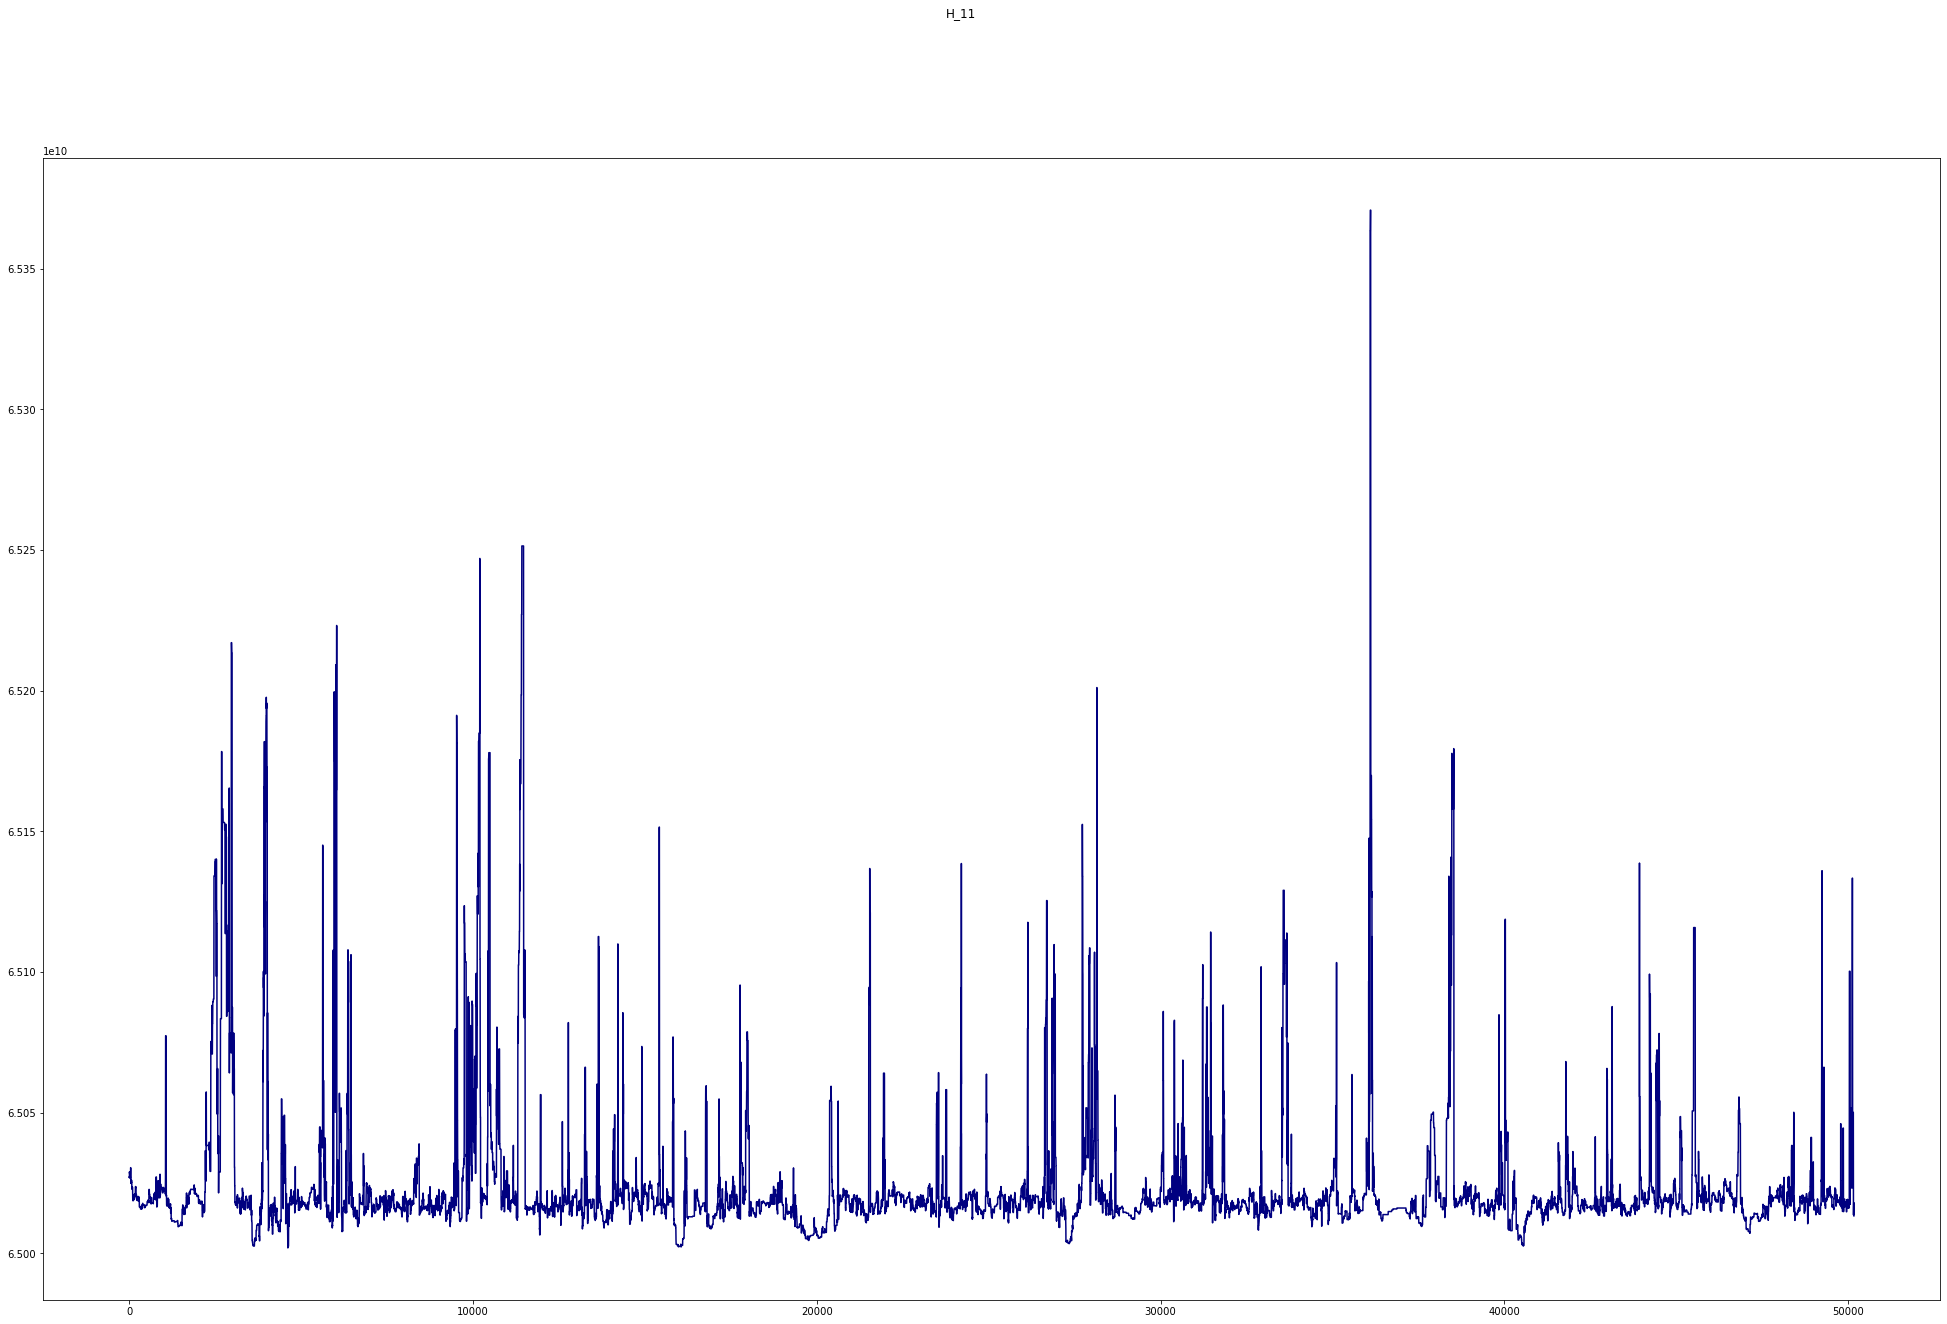

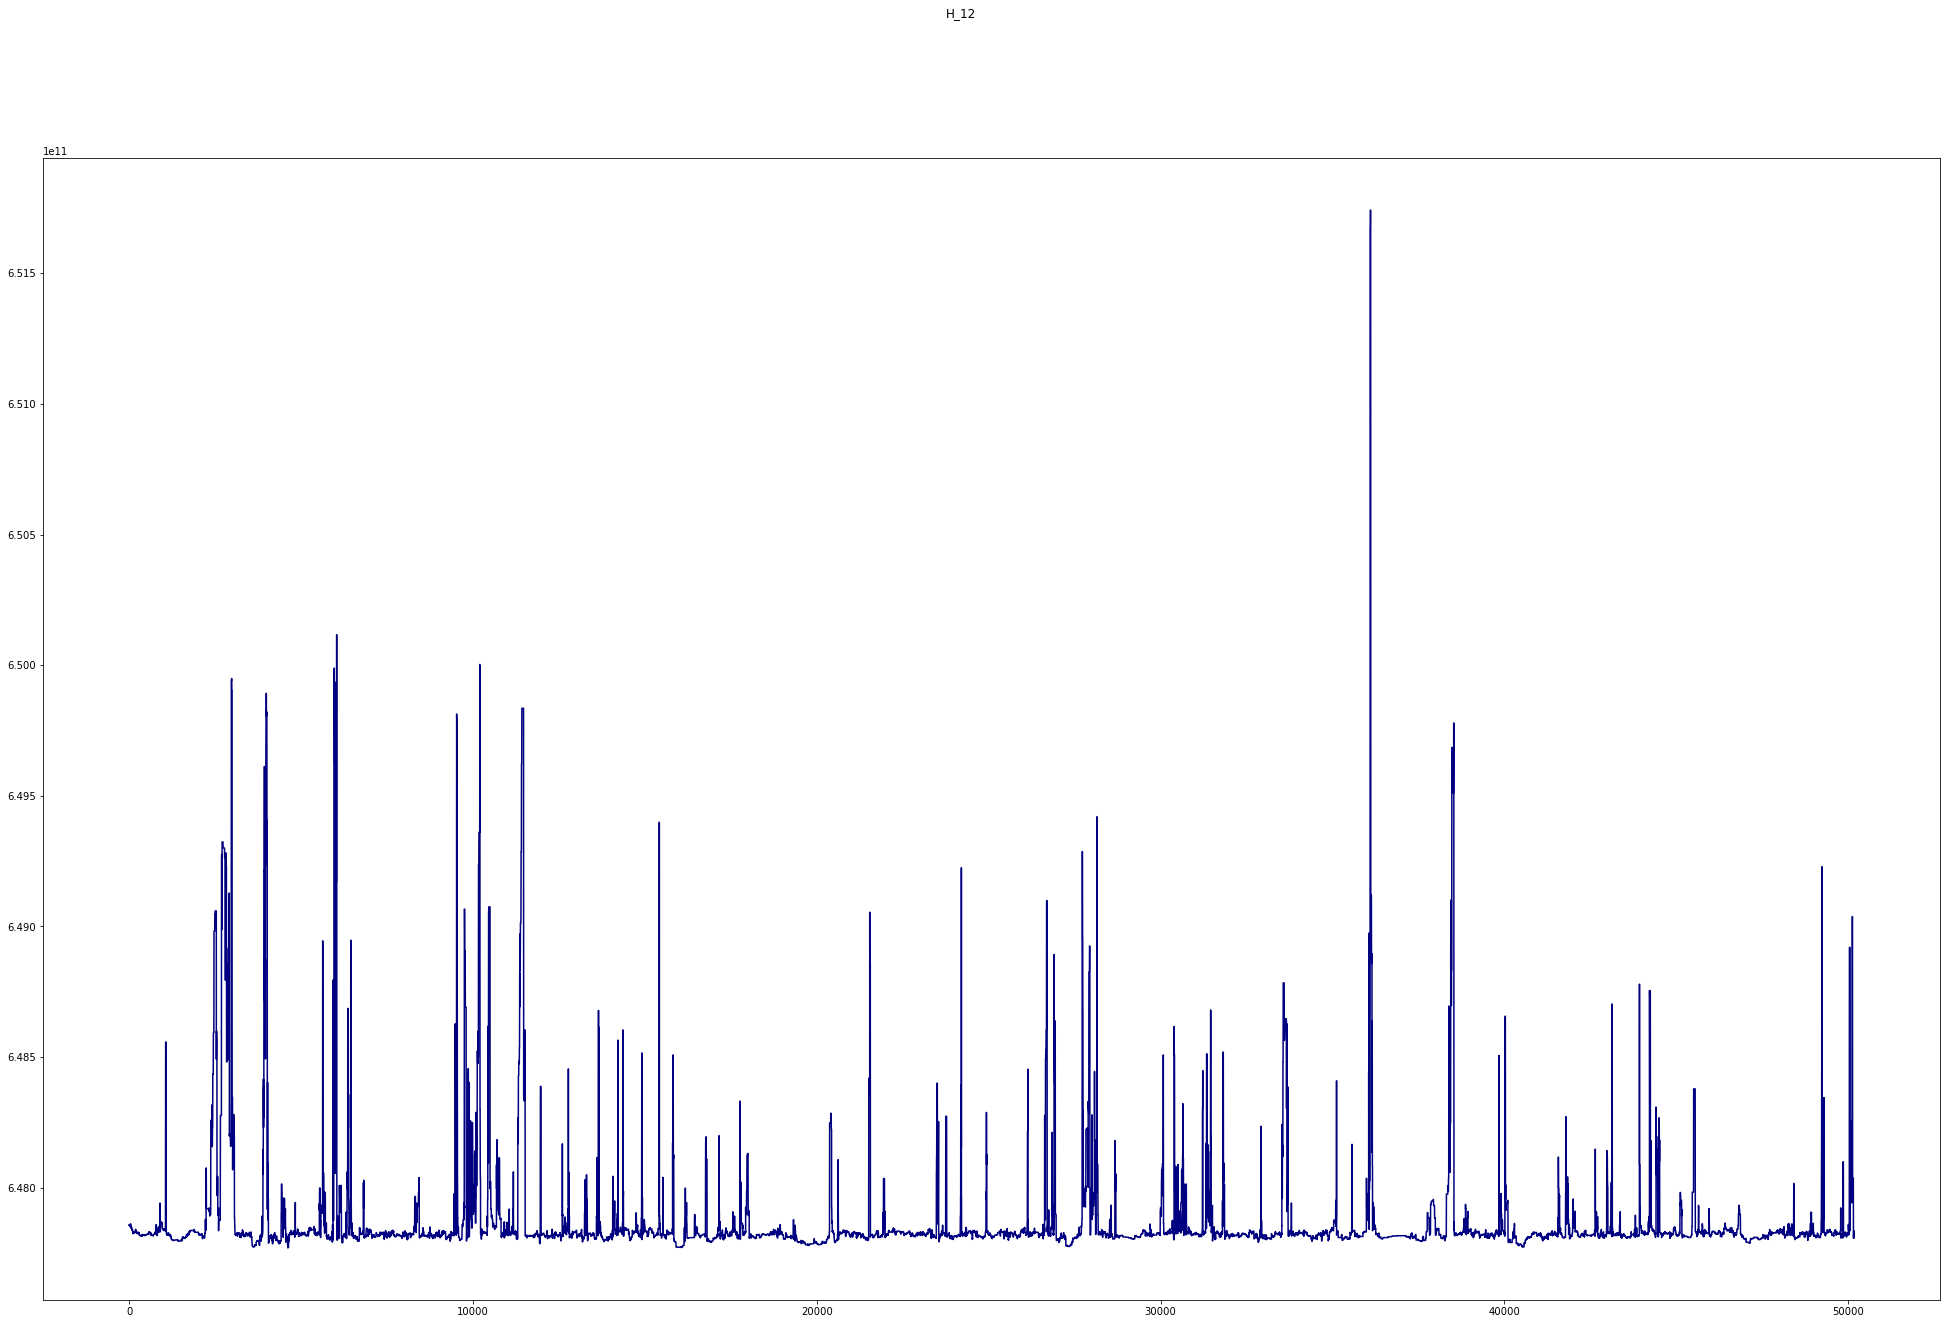

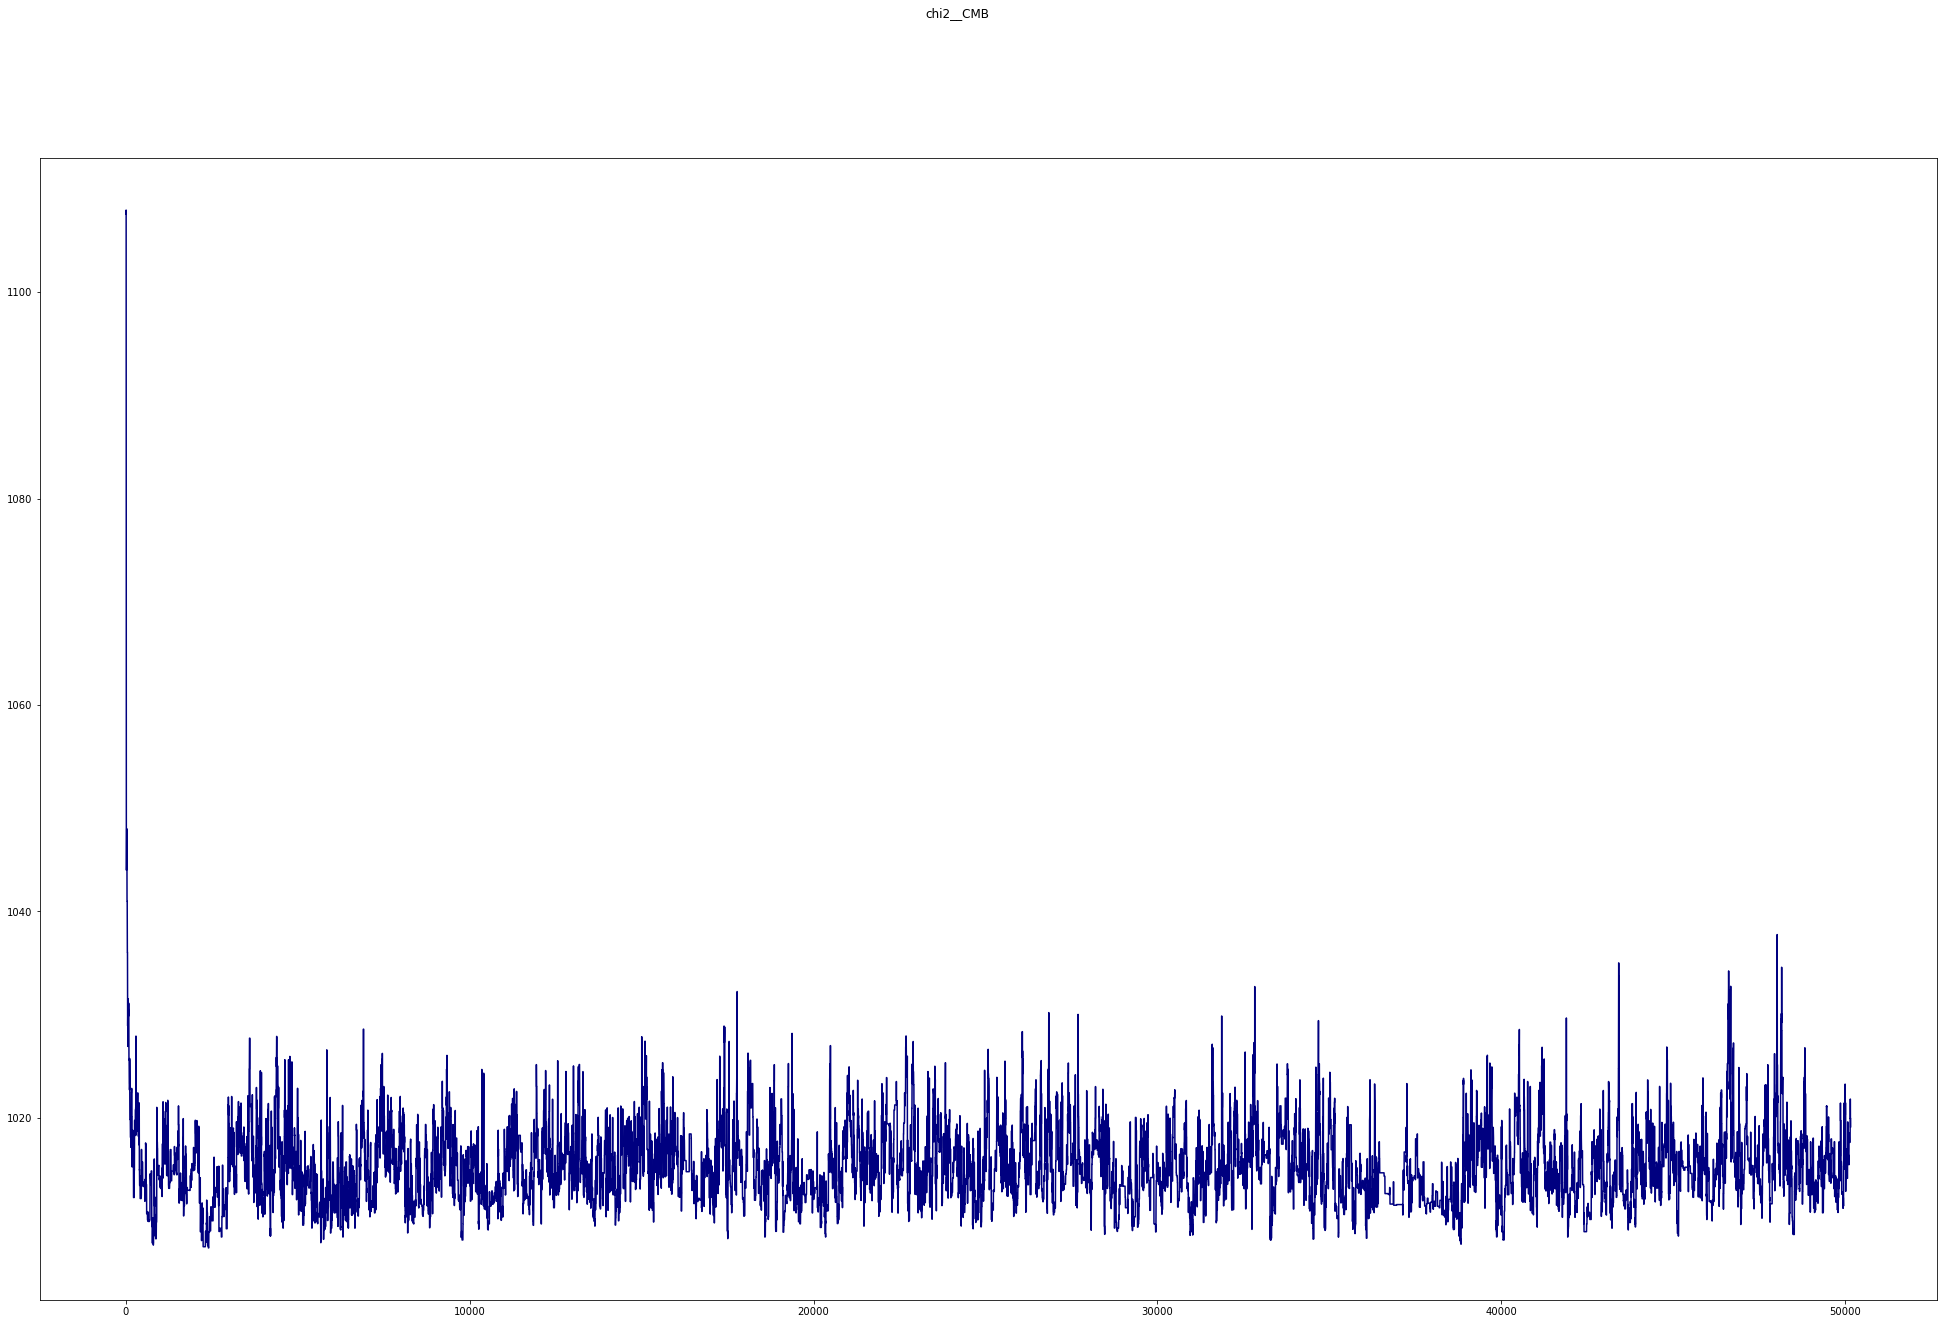

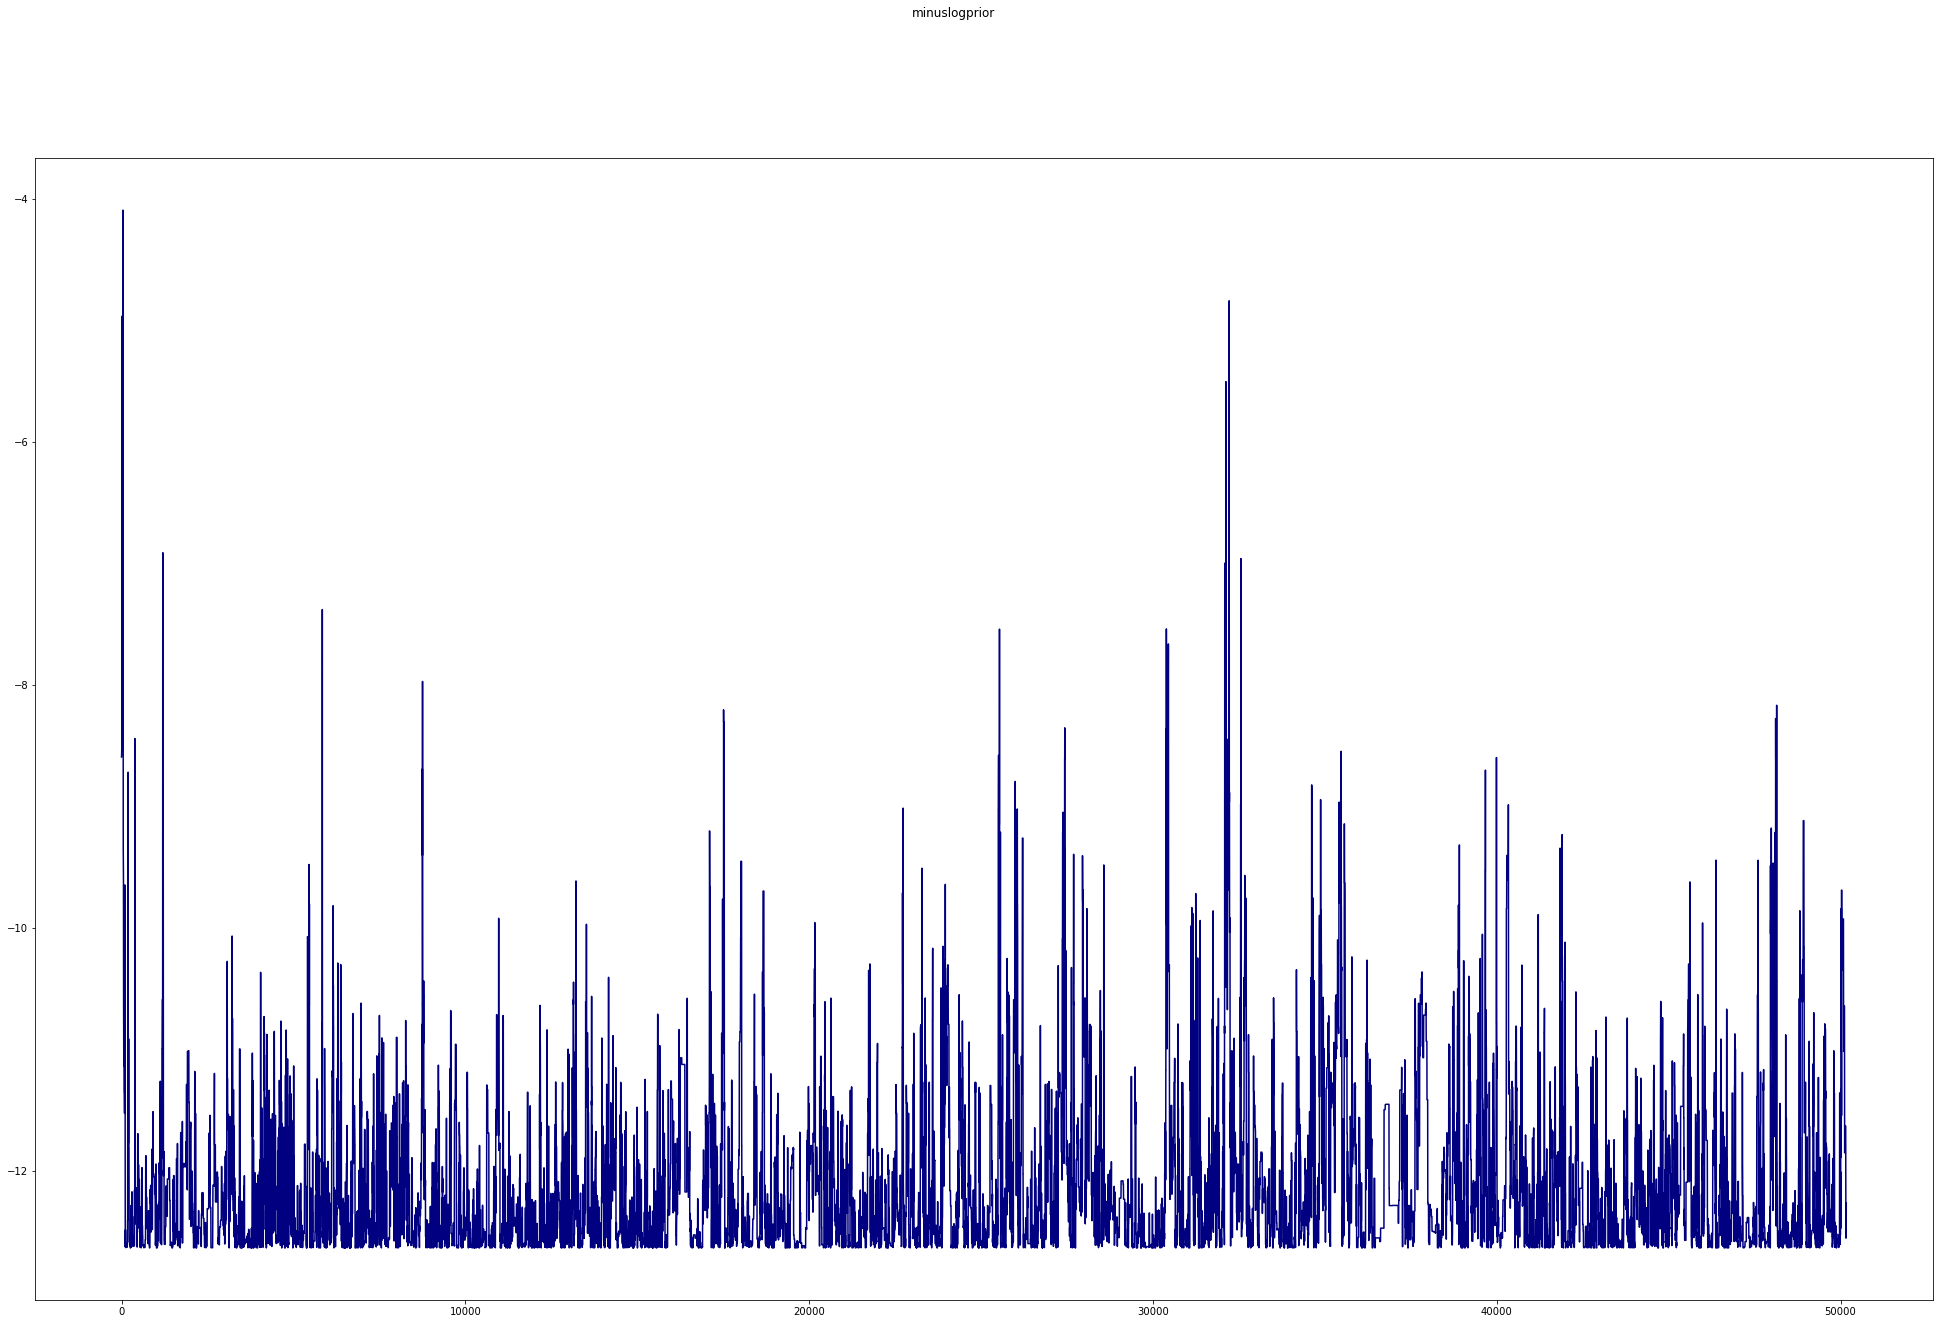

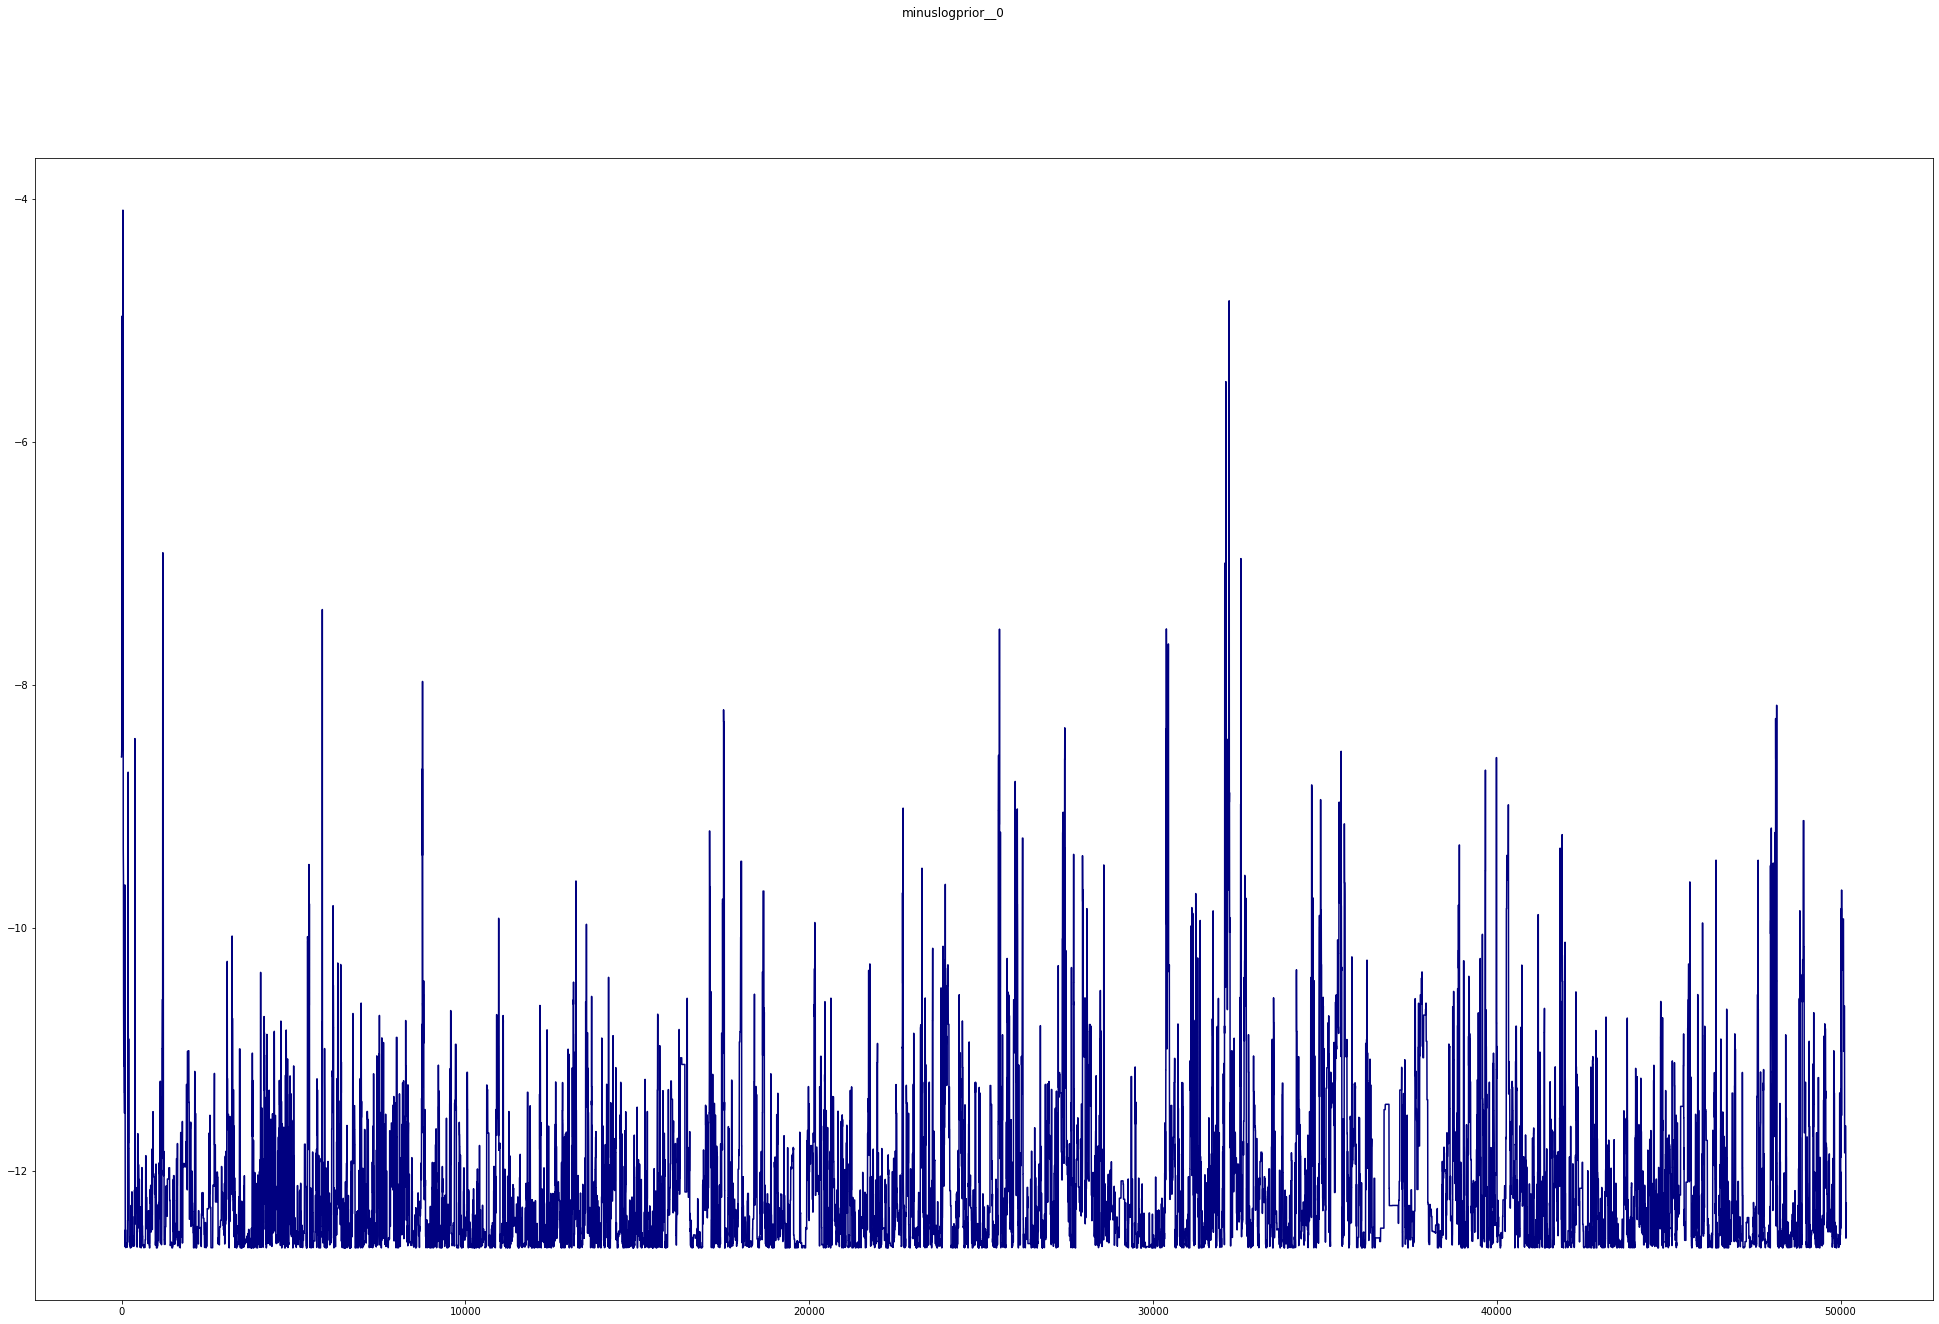

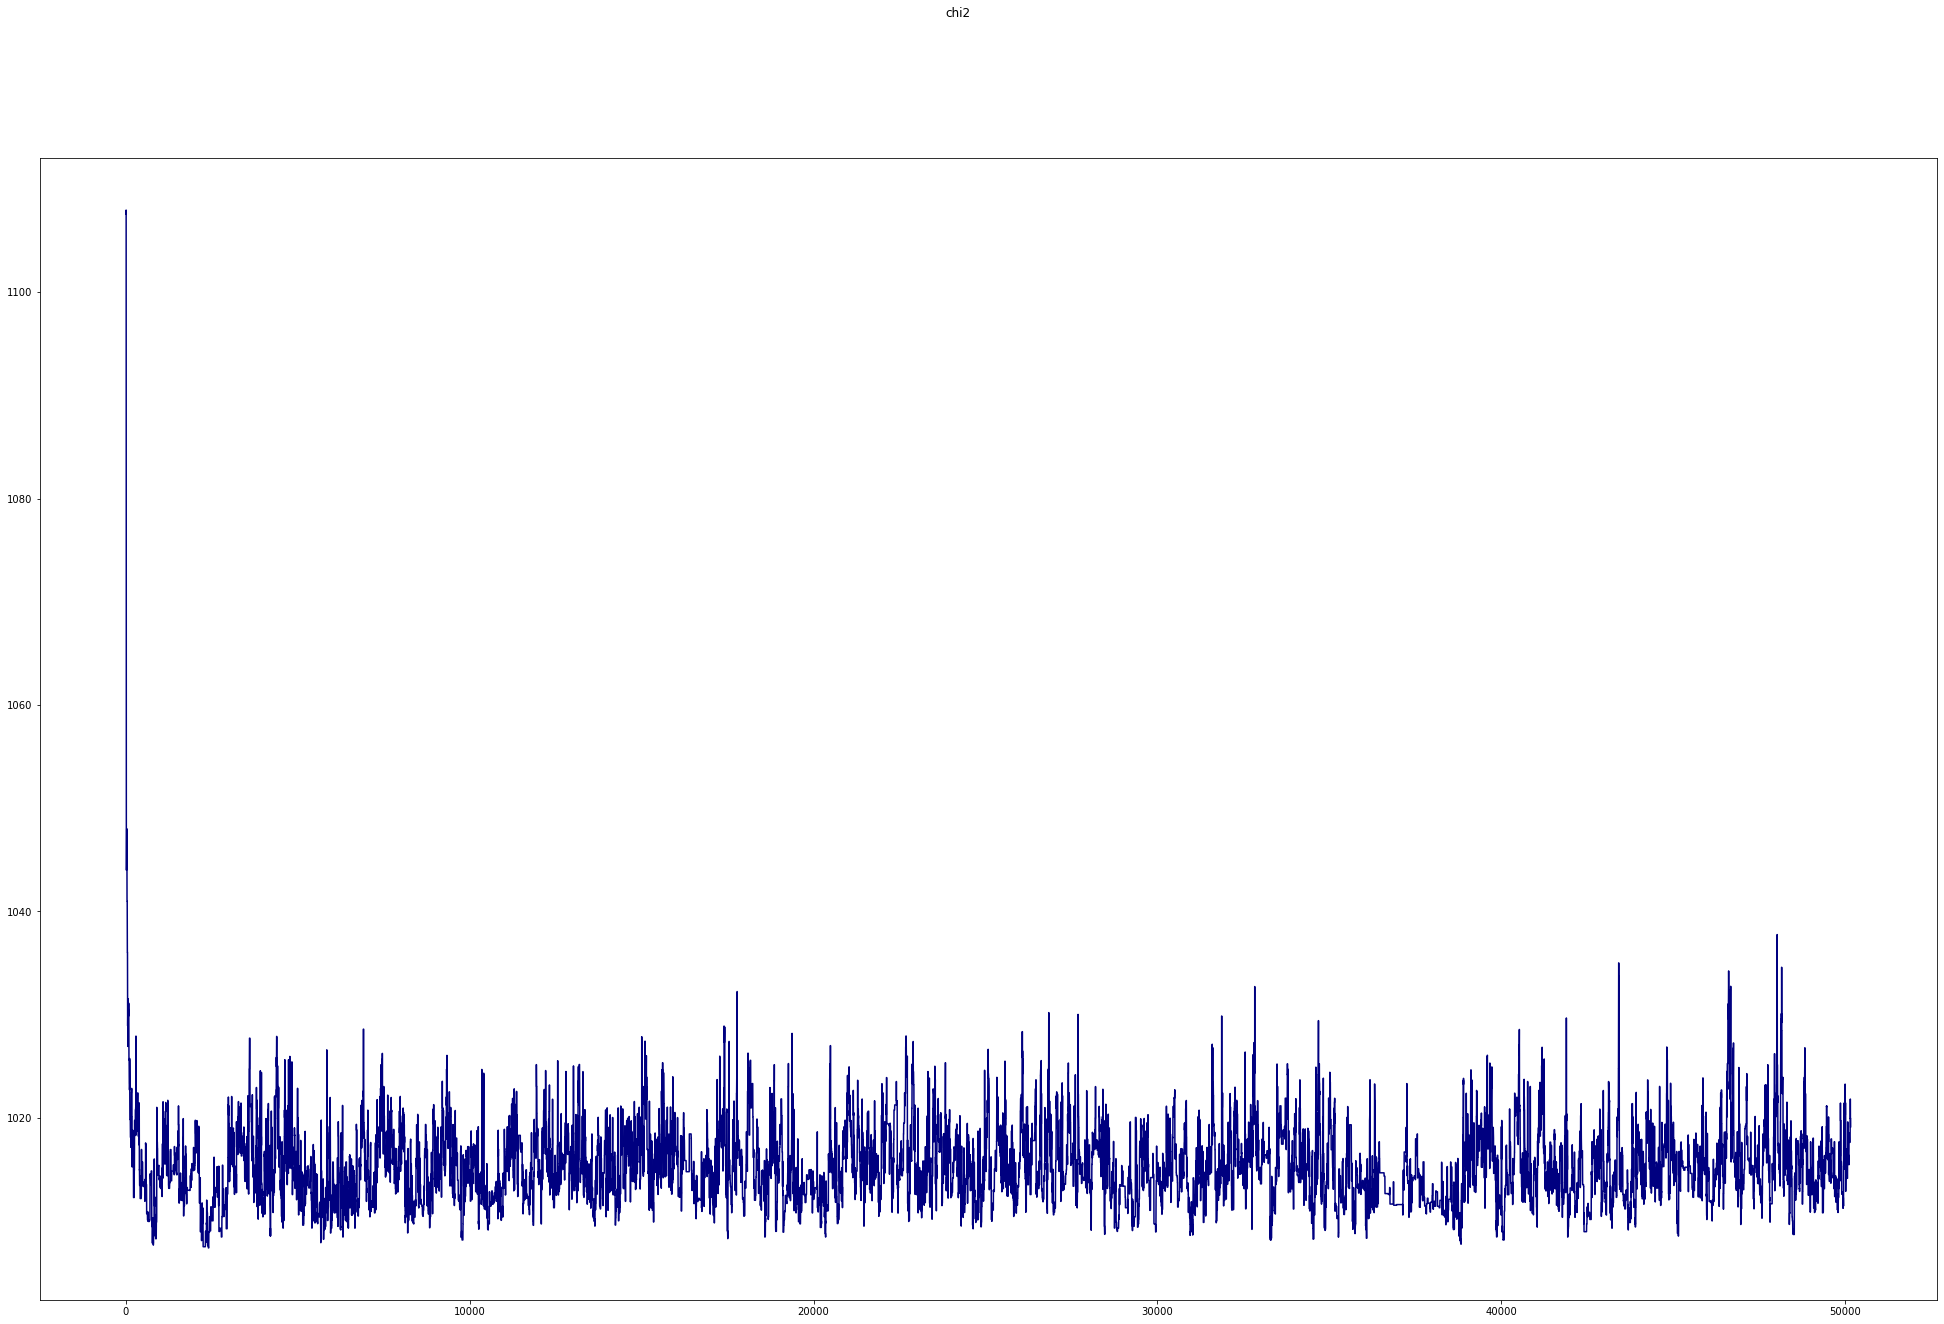

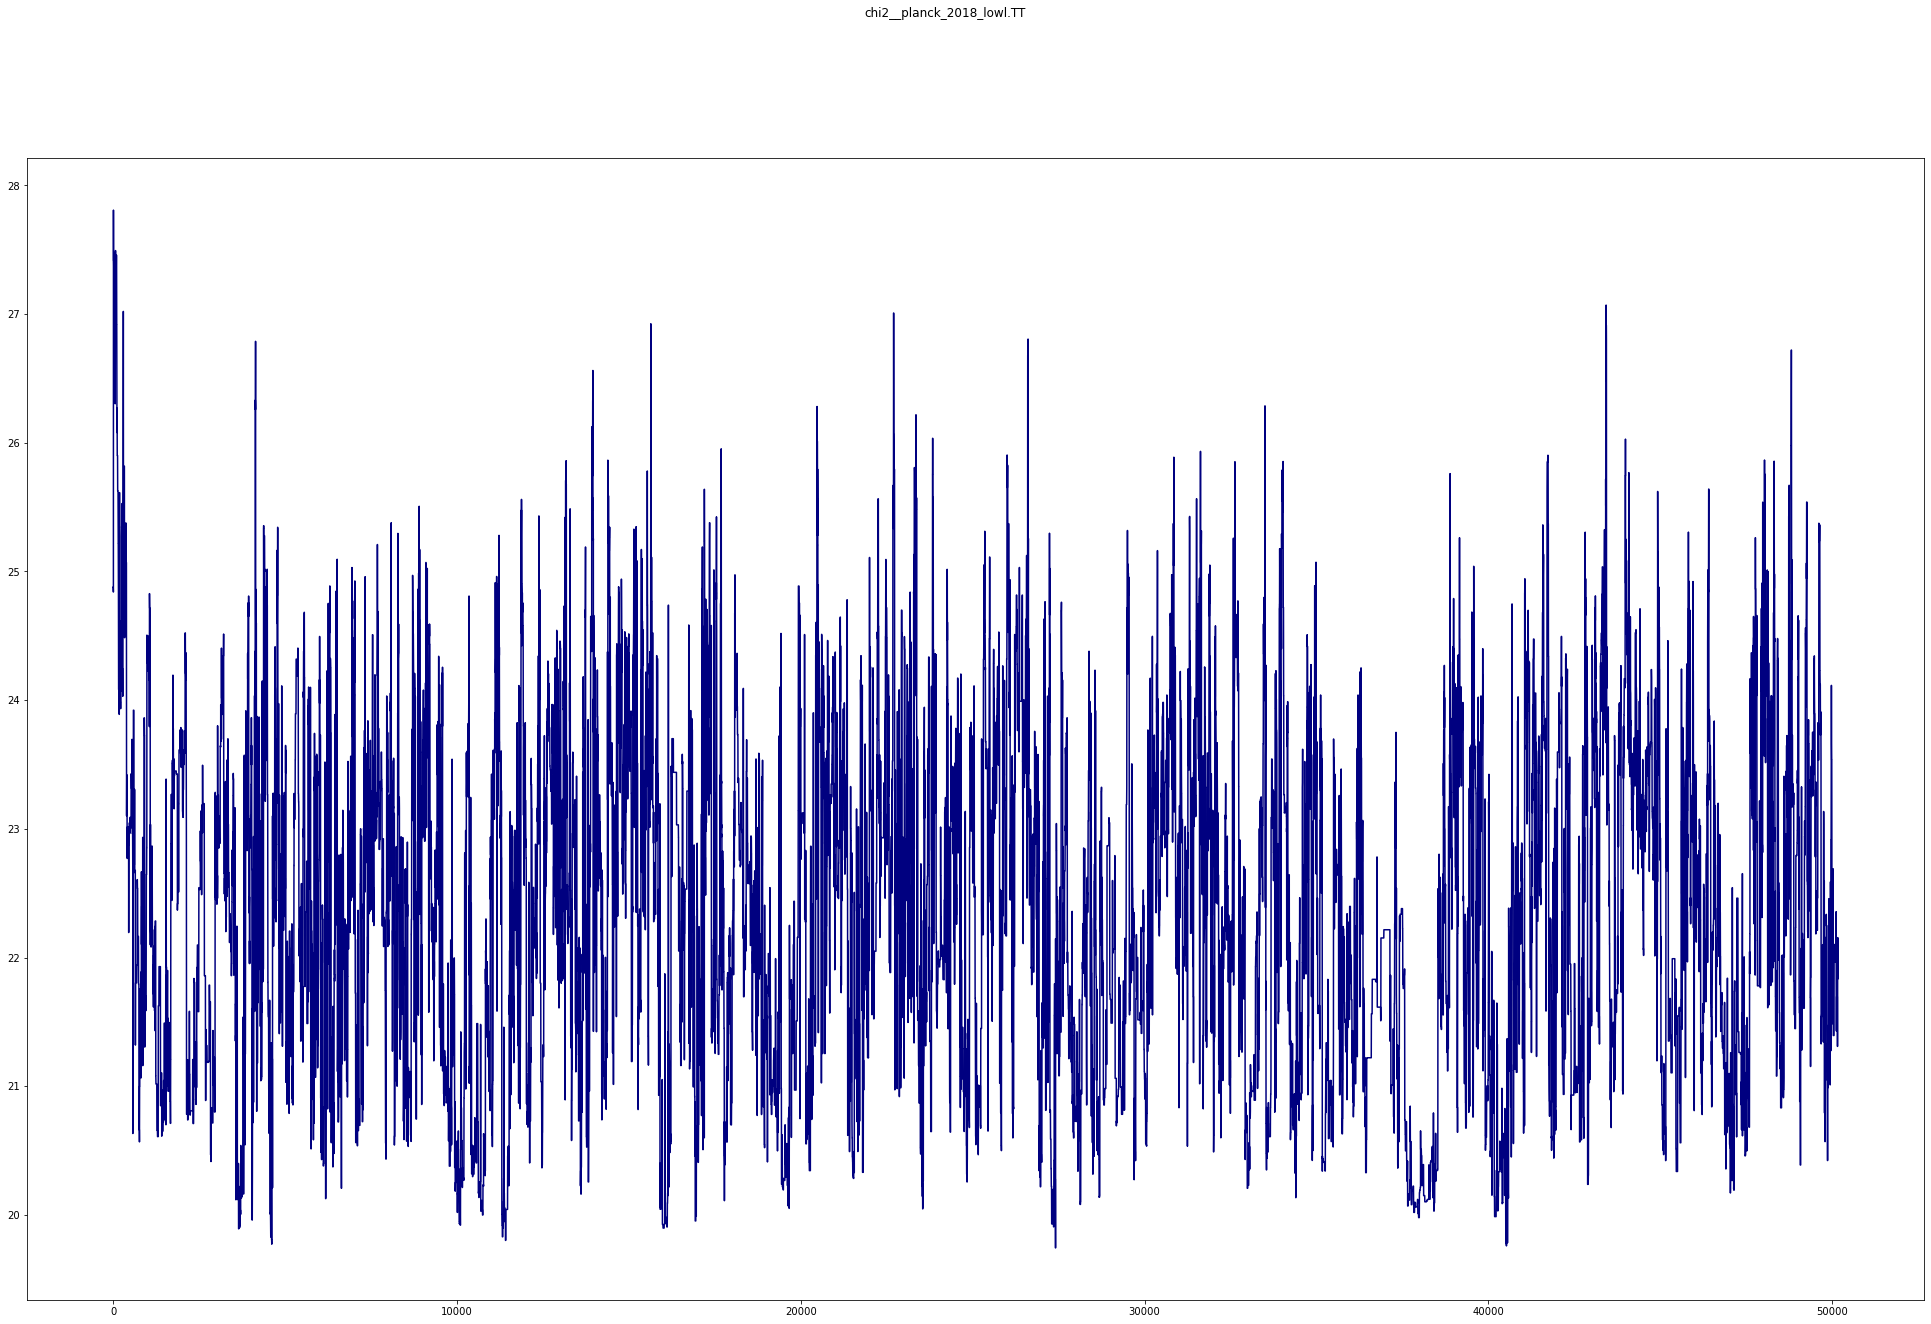

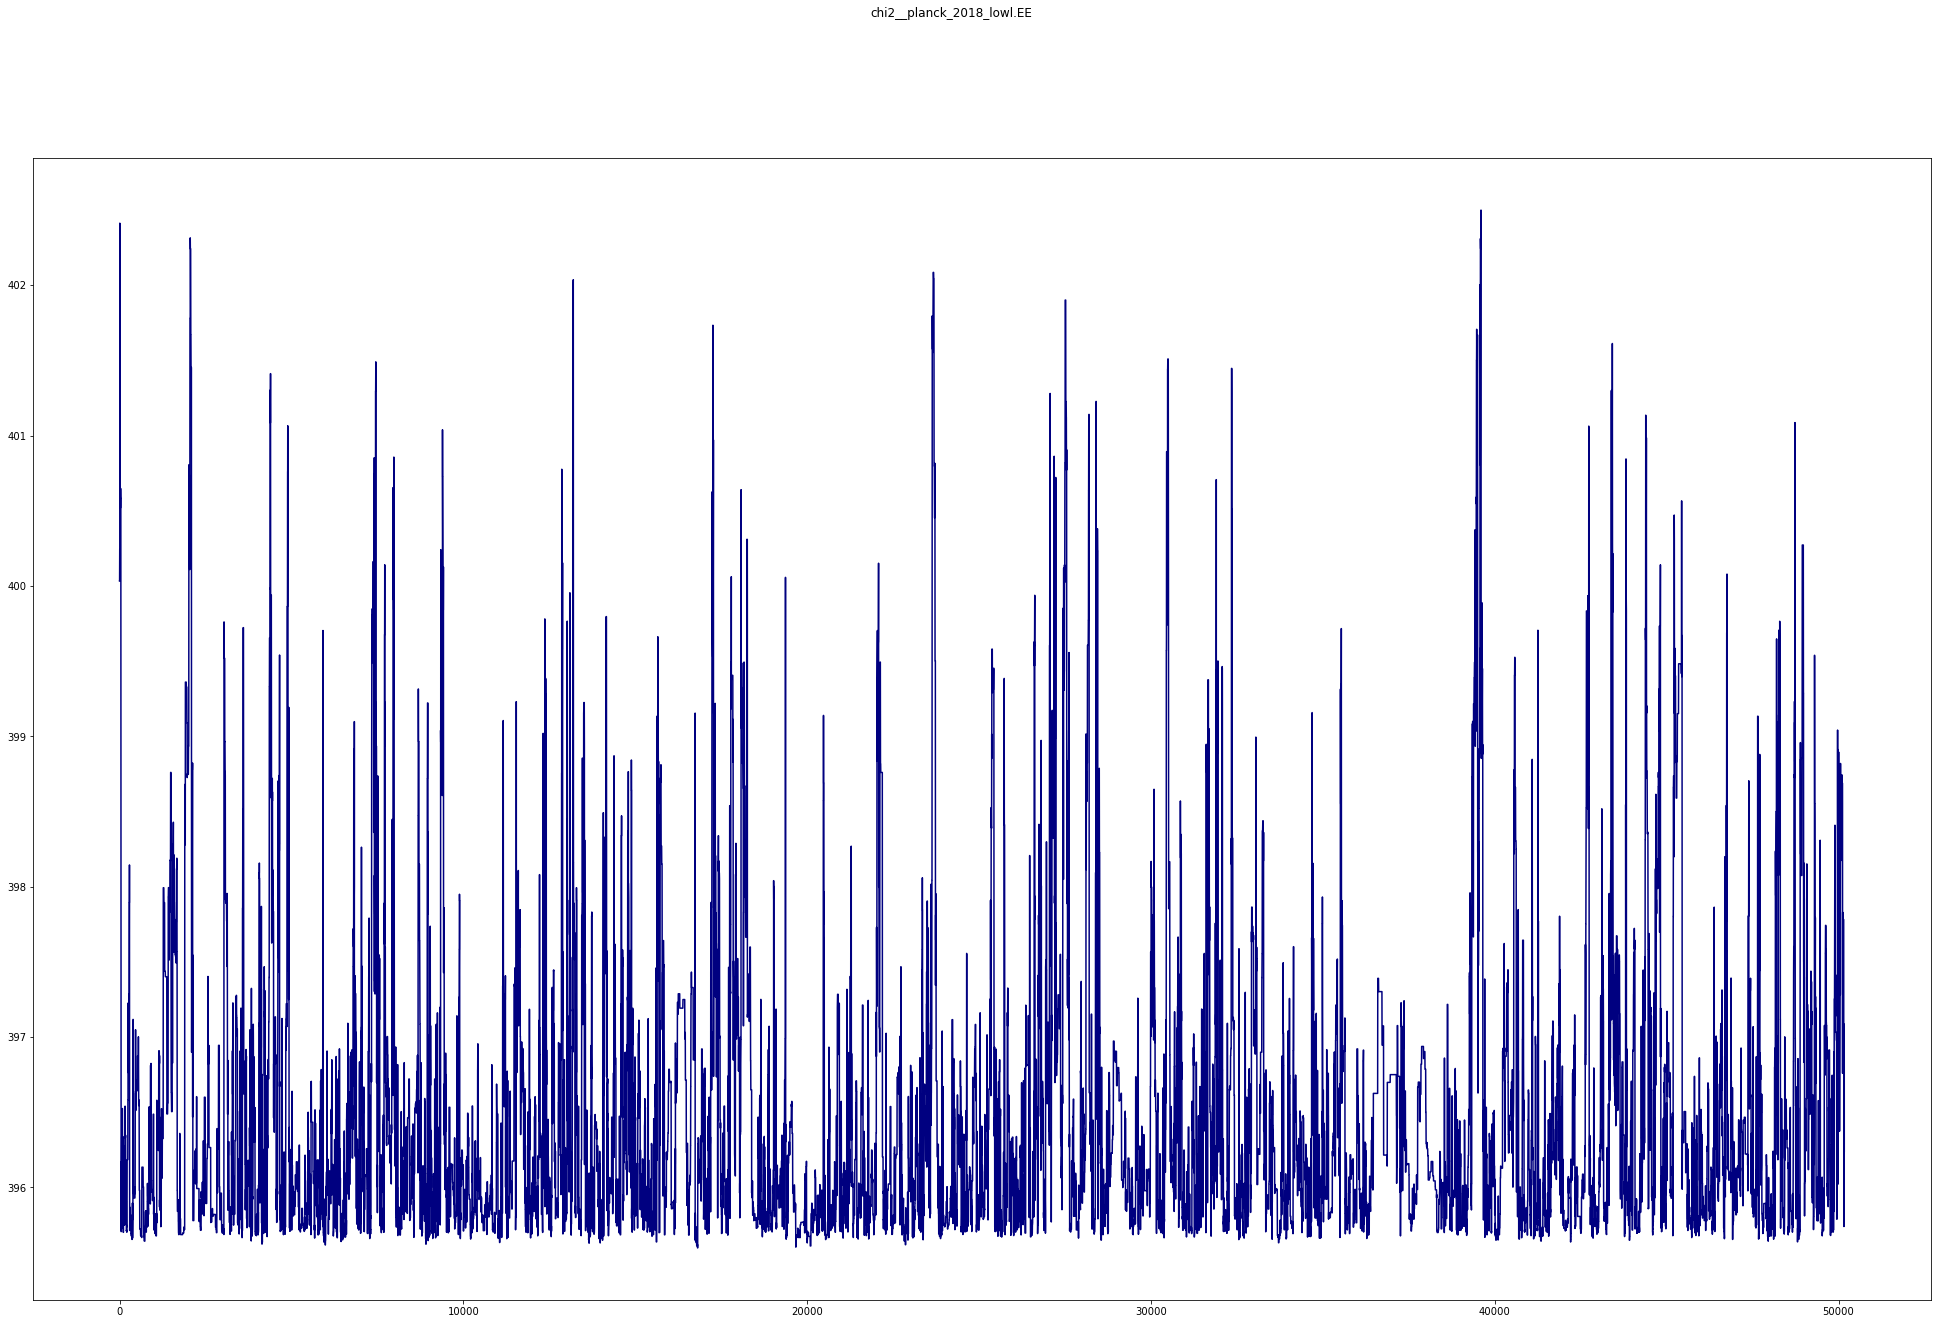

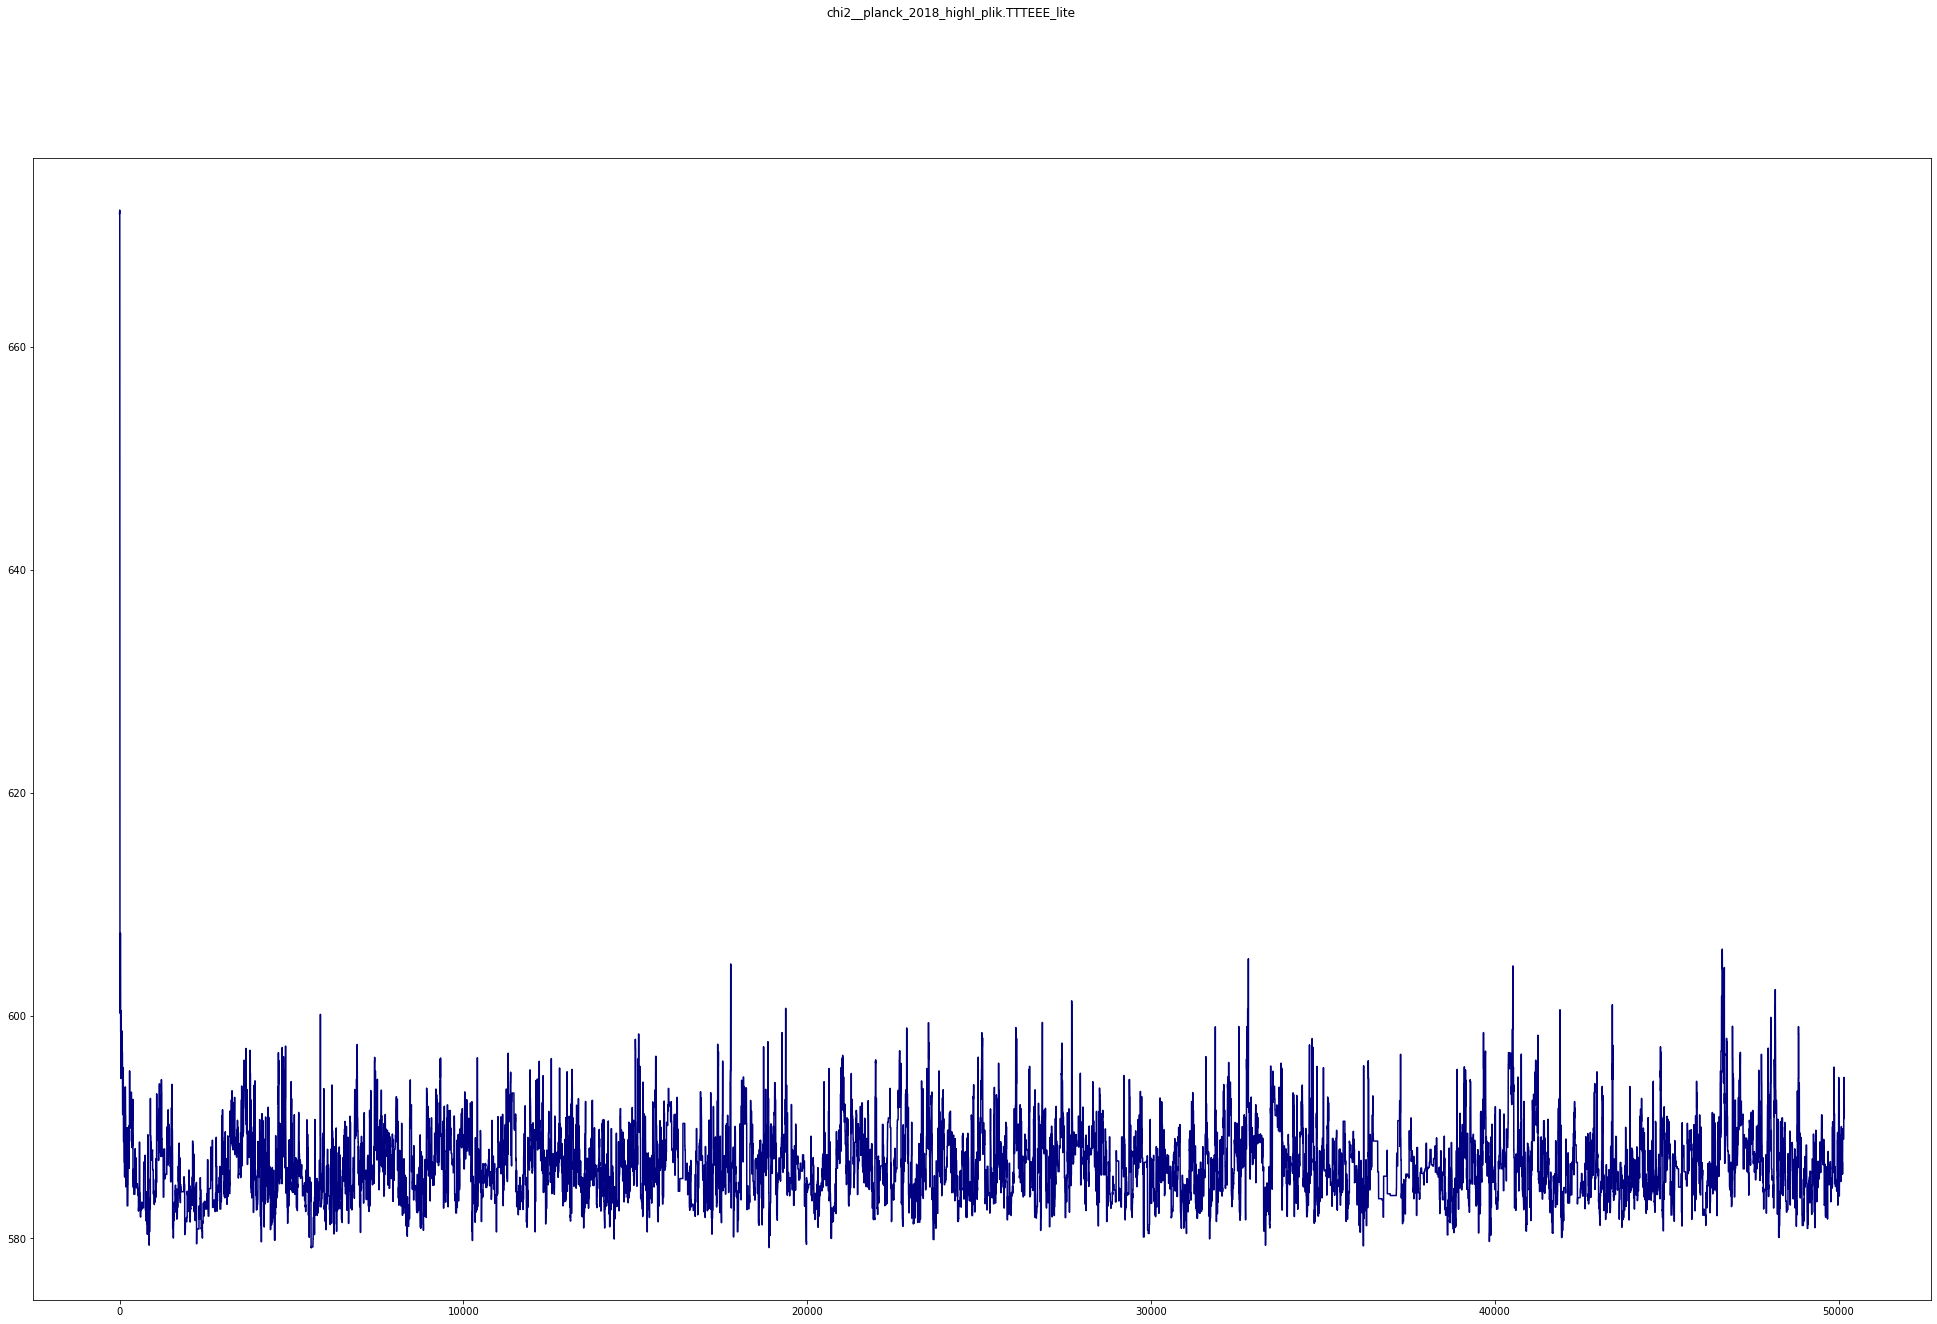

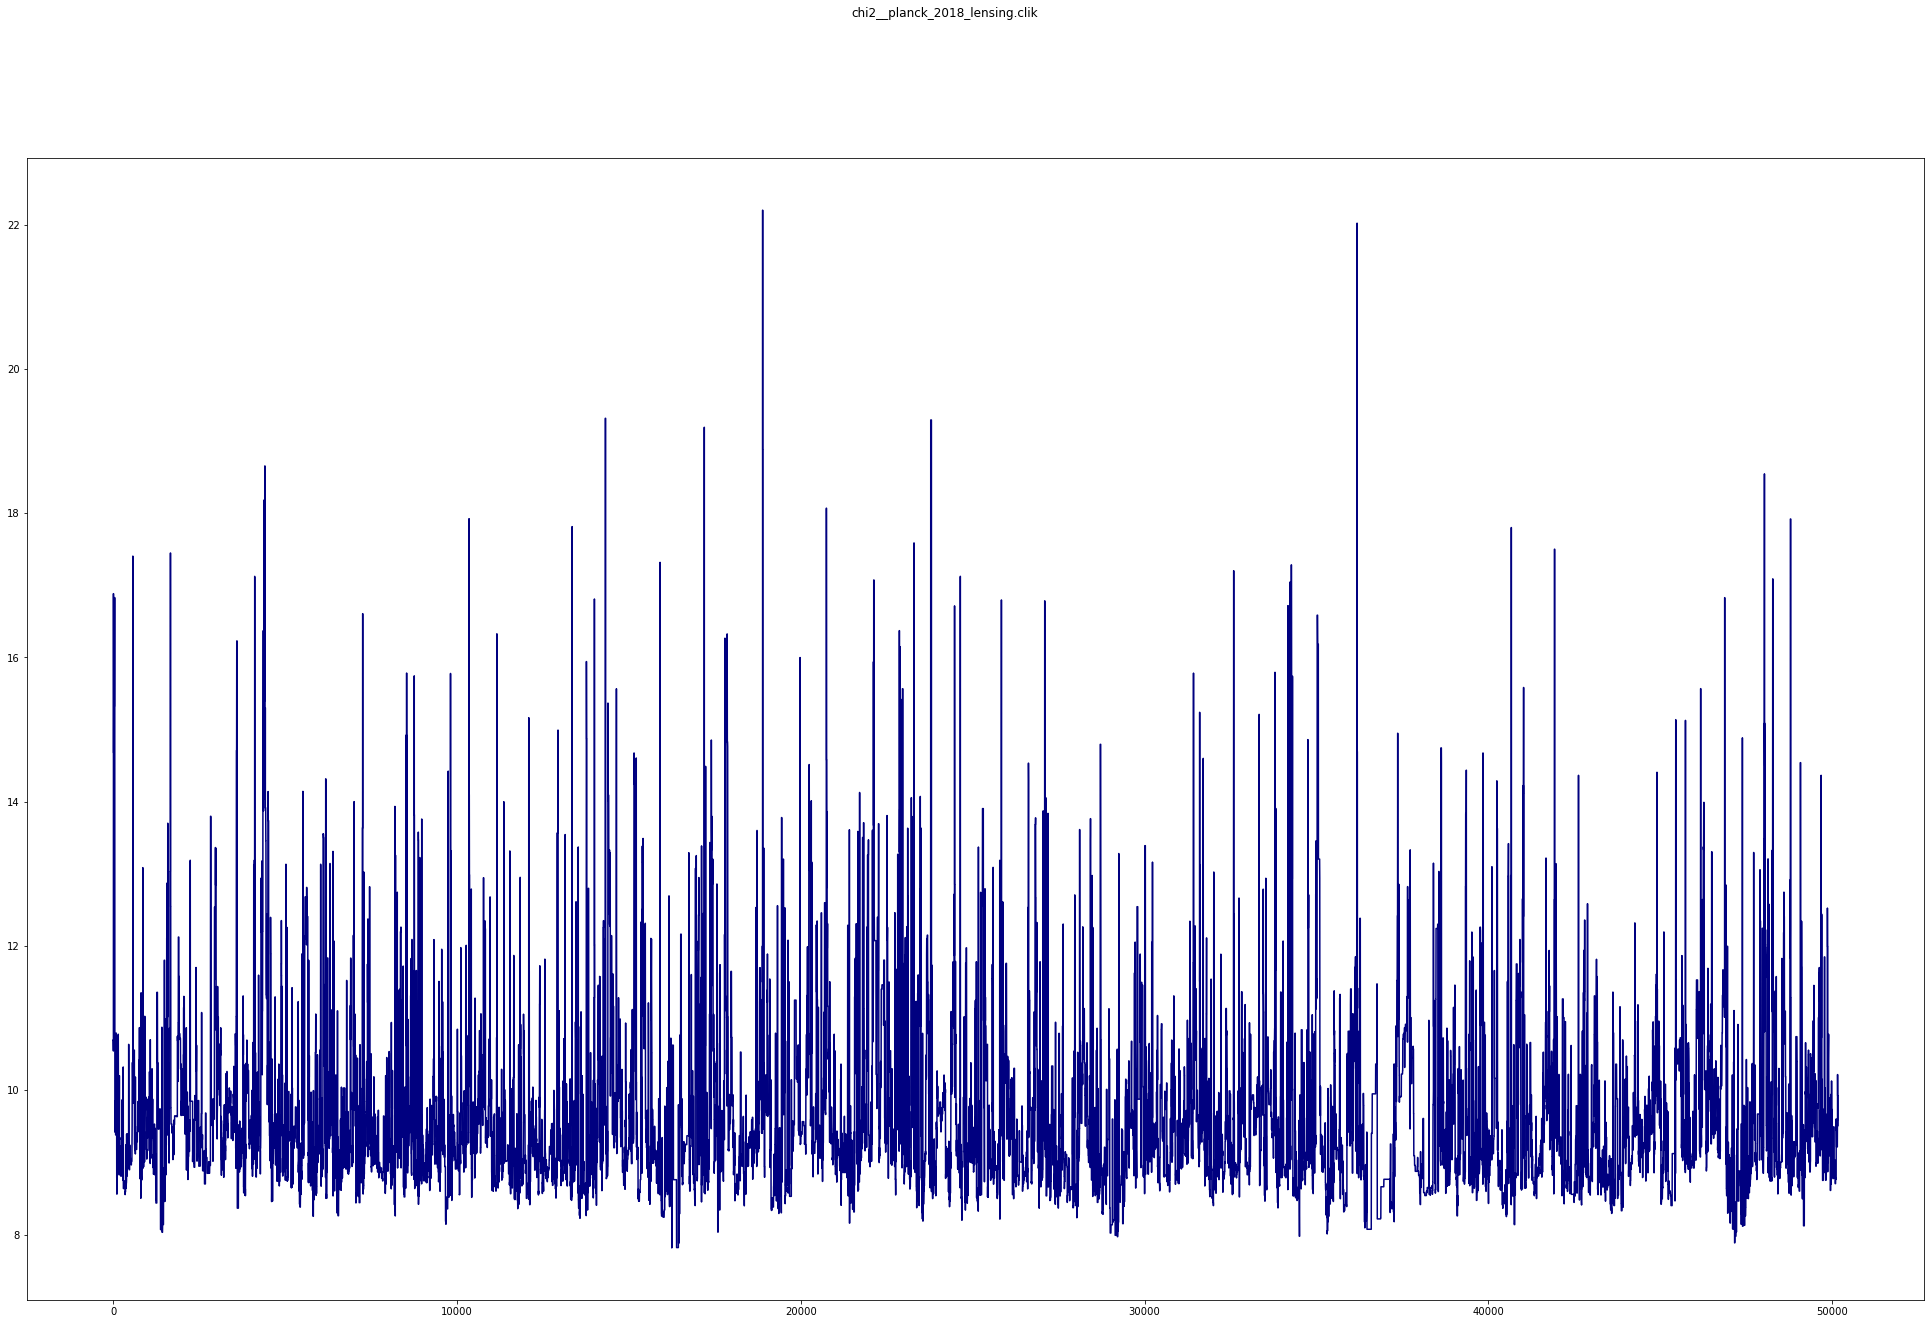

In [10]:
n_param = len(gdm_samples.index.items())

# Grab colormap
cmap = matplotlib.cm.get_cmap('jet')

# Loop through traces and plot them
for k,idx in tuple(gdm_samples.index.items())[:n_param]:
    fig, ax = plt.subplots(1,figsize=(34,21))
    for j,trace in enumerate(traces):
        c=cmap(float(j)/len(traces))
        ax.plot(trace[:,idx],color=c)
    fig.suptitle(k)
    plt.show()
    fig.savefig('plots/trace-' + k +'.png')
    plt.close()
    
    




In [ ]:
# %% in this cell: initialize gdm model

# initialize w model
log10a_epoch_intervals_endpoints = (-14.0, -4.0, -2.0, 0.0)
n_inter_interval_knots = (0, 1, 0)

log10a_knots=np.concatenate(tuple(np.linspace(start, end, n_knots+1, endpoint=False)
                                  for start, end, n_knots in zip(log10a_epoch_intervals_endpoints[:],
                                                                 log10a_epoch_intervals_endpoints[1:],
                                                                 n_inter_interval_knots)) + \
                            (np.array([log10a_epoch_intervals_endpoints[-1]]),))

n_knots = len(log10a_knots)

# store properties of gdm_fluid
c_s2 = 1
c_vis2 = 0
z_alpha = 3000.

gdm_fixed_setting_classy = {'gdm_log10a_vals': ','.join([str(val) for val in log10a_knots]),
                            'gdm_c_eff2': c_s2,
                            'gdm_c_vis2': c_vis2,
                            'gdm_z_alpha': z_alpha,
                            'gdm_interpolation_order': 1,
                            }



In [82]:
def sample_to_w_vec(sample, w_dim=5):
    return ','.join(str(sample['w_'+str(idx)]) for idx in range(w_dim))

lcdm_params = ('h', 'omega_b', 'omega_cdm', 'tau_reio', 'n_s', 'A_s')

def classy_input_from_sample(sample):
    classy_input = {k:sample[k] for k in lcdm_params}
    classy_input['gdm_alpha'] = sample['gdm_alpha']
    classy_input['gdm_w_vals'] = sample_to_w_vec(sample)
    return classy_input
    
                     


In [112]:
from classy import Class


output_and_pre_settings_DEF = {'output': 'tCl,pCl,lCl',
                               'lensing': 'yes',
                               'l_max_scalars': 5000}

cosmo = Class()
cosmo.set({**classy_input_from_sample(best_fit_sample),
           **gdm_fixed_setting_classy,
          **output_and_pre_settings_DEF})
cosmo.compute()
bf_bg = copy(cosmo.get_background())
cosmo.struct_cleanup()
cosmo.empty()

In [111]:
bf_bg = copy(cosmo.get_background())
z = bf_bg['z']
rho_crit = bf_bg['(.)rho_crit']
Omega_gdm=(bf_bg['(.)rho_gdm'])/rho_crit
Omega_r=(bf_bg['(.)rho_g']+bf_bg['(.)rho_ur'])/rho_crit
Omega_b=(bf_bg['(.)rho_b']+bf_bg['(.)rho_cdm'])/rho_crit

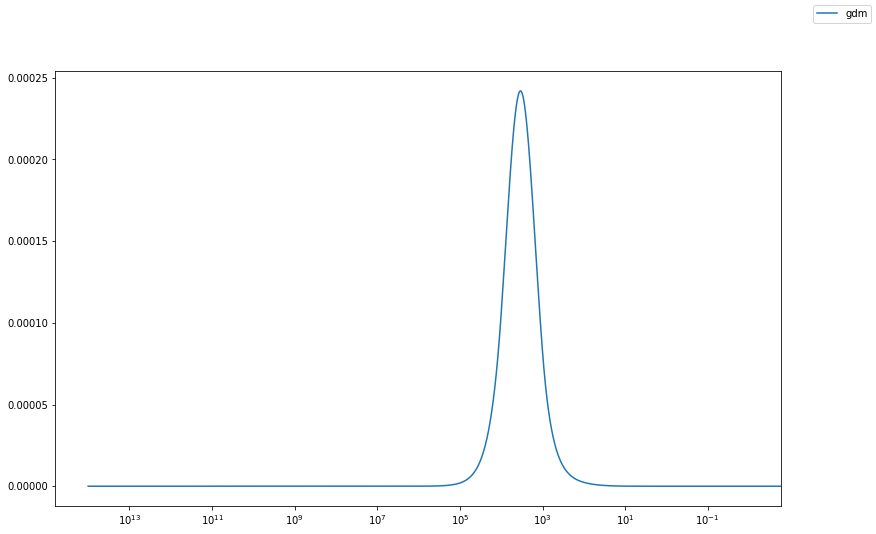

In [191]:
fig, ax = plt.subplots(figsize=(13,8))

ax.semilogx(z,Omega_gdm)
#ax.semilogx(z,Omega_r)
#ax.semilogx(z,Omega_b)
ax.invert_xaxis()
fig.legend(['gdm','r','b'])
fig.show()
#fig.savefig('test.png')

In [94]:
best_fit_sample

{'weight': 1.0,
 'loglike': 496.65303,
 'logA': 3.0426631,
 'n_s': 0.96507551,
 'h': 0.67889353,
 'omega_b': 0.022366256,
 'omega_cdm': 0.11993875,
 'tau_reio': 0.05436801,
 'gdm_alpha': 0.00023909809,
 'w_0': -0.66451794,
 'w_1': -0.26070838,
 'w_2': 0.65597658,
 'w_3': 0.43891738,
 'w_4': 0.8717992,
 'A_planck': 1.0000158,
 'A_s': 2.096099e-09,
 'chi2__CMB': 1011.5692,
 'minuslogprior': -9.1315496,
 'minuslogprior__0': -9.1315496,
 'chi2': 1011.5692,
 'chi2__planck_2018_lowl.TT': 23.447505,
 'chi2__planck_2018_lowl.EE': 396.04468,
 'chi2__planck_2018_highl_plik.TTTEEE_lite': 583.25666,
 'chi2__planck_2018_lensing.clik': 8.8203027}

In [181]:
chi2__CMB_1_sigma = gdm_samples.confidence('chi2__CMB',0.34, upper=True)

rng = np.random.default_rng(12345)
n_show_samples = 5
samples = []
n_samples=0
while n_samples< n_show_samples:
    sample_idx = rng.integers(low=0,high=len(gdm_samples.samples))
    candidate_sample = gdm_samples.getParamSampleDict(sample_idx)
    if candidate_sample['chi2__CMB']<chi2__CMB_1_sigma:
        samples += [candidate_sample]
        n_samples += 1
        
    

In [182]:
sample_bgs = []
for sample in samples:
    cosmo.set({**classy_input_from_sample(sample),
           **gdm_fixed_setting_classy,
          **output_and_pre_settings_DEF})
    cosmo.compute()
    sample_bgs += [copy(cosmo.get_background())]
    cosmo.struct_cleanup()
    cosmo.empty()

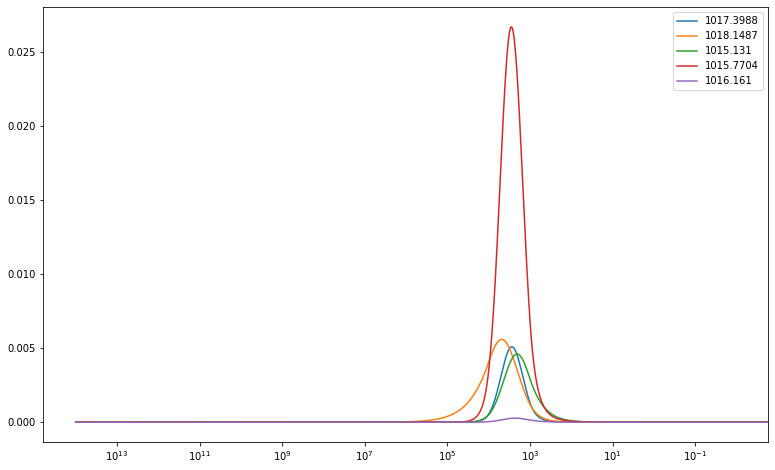

In [183]:
fig, ax = plt.subplots(figsize=(13,8))

for bg,sample in zip(sample_bgs,samples):
    ax.semilogx(bg['z'],(bg['(.)rho_gdm'])/bg['(.)rho_crit'],label=sample['chi2__CMB'])
    ax.invert_xaxis()

ax.legend()
fig.show()

In [184]:
for bg,sample in zip(sample_bgs,samples):
    ax.semilogx(bg['z'],(bg['(.)rho_gdm'])/bg['(.)rho_crit'],label=sample['chi2__CMB'])
    ax.invert_xaxis()

In [185]:
def make_Omega_plot(bg):
    fig, ax = plt.subplots(figsize=(13,8))
    z = bg['z']
    rho_crit = bg['(.)rho_crit']
    Omega_gdm=(bg['(.)rho_gdm'])/rho_crit
    Omega_r=(bg['(.)rho_g']+bg['(.)rho_ur'])/rho_crit
    Omega_b=(bg['(.)rho_b']+bg['(.)rho_cdm'])/rho_crit
    
    ax.semilogx(z,Omega_gdm)
    ax.semilogx(z,Omega_r)
    ax.semilogx(z,Omega_b)
    ax.invert_xaxis()
    fig.legend(['gdm','r','b'])
    return fig

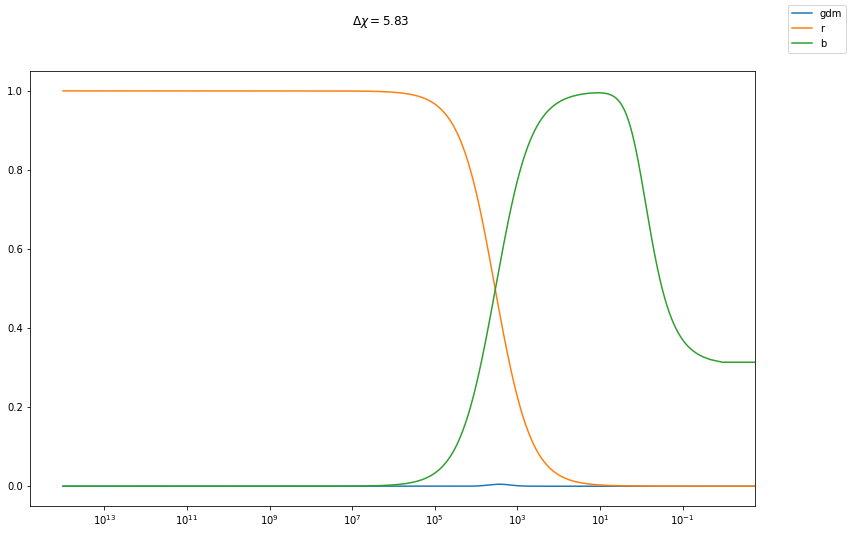

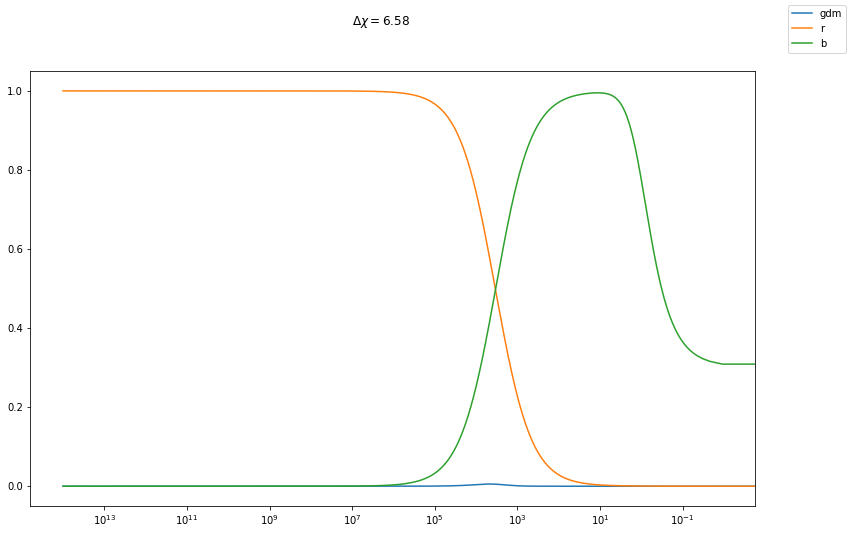

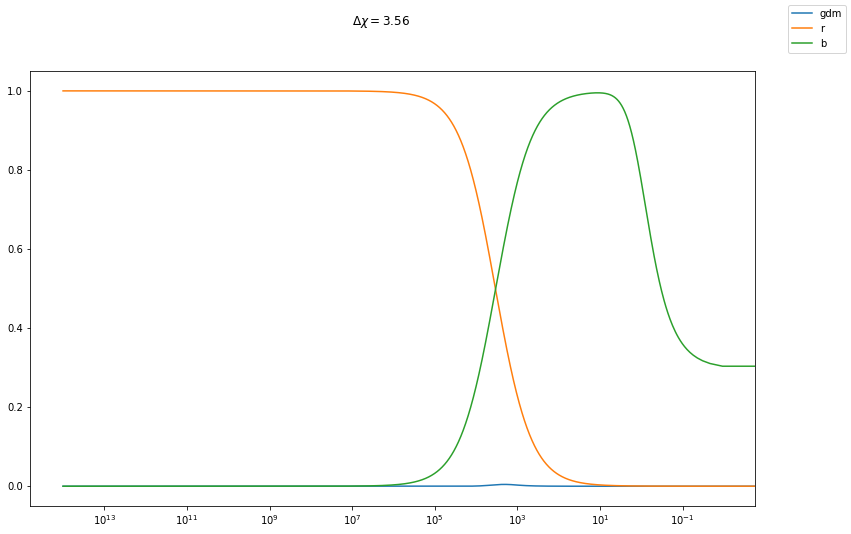

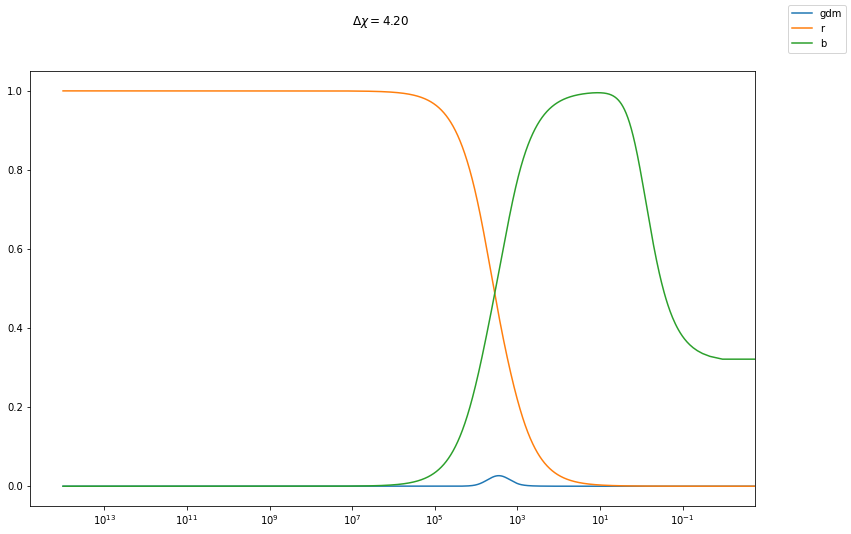

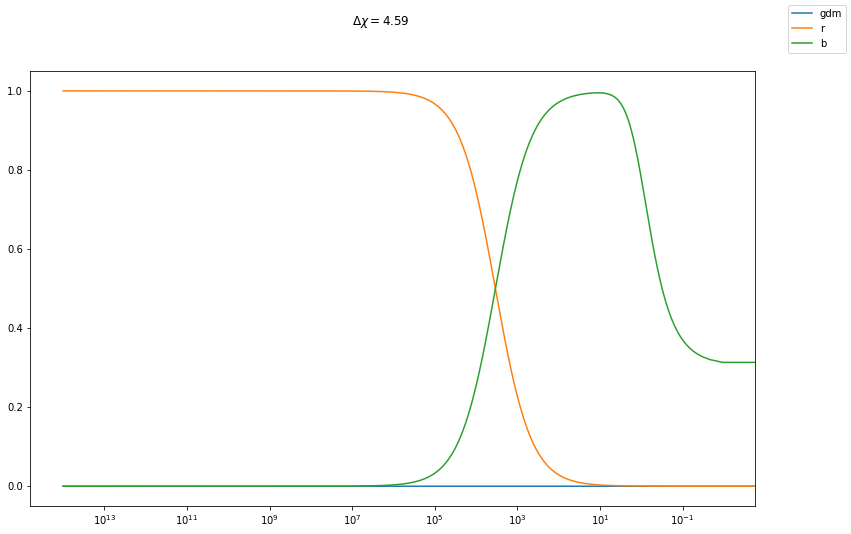

In [186]:


for sample_idx in range(n_show_samples):
    Omega_plot = make_Omega_plot(sample_bgs[sample_idx])
    Omega_plot.suptitle(r'$\Delta \chi=$'+f"{samples[sample_idx]['chi2__CMB']-best_fit_sample['chi2__CMB']:.2f}")
    Omega_plot.show()

In [187]:
chi2__CMB_2_sigma = gdm_samples.confidence('chi2__CMB',0.05, upper=True)

rng = np.random.default_rng(12345)

samples_2_sig = []
n_samples=0
n_try = 0
while n_samples< n_show_samples and n_try <10000  :
    sample_idx = rng.integers(low=0,high=len(gdm_samples.samples))
    candidate_sample = gdm_samples.getParamSampleDict(sample_idx)
    if candidate_sample['chi2__CMB']>chi2__CMB_1_sigma and candidate_sample['chi2__CMB']<chi2__CMB_2_sigma:
        samples_2_sig += [candidate_sample]
        n_samples += 1
        

In [188]:
sample_bgs_2_sig = []
for sample in samples_2_sig:
    cosmo.set({**classy_input_from_sample(sample),
           **gdm_fixed_setting_classy,
          **output_and_pre_settings_DEF})
    cosmo.compute()
    sample_bgs_2_sig += [copy(cosmo.get_background())]
    cosmo.struct_cleanup()
    cosmo.empty()

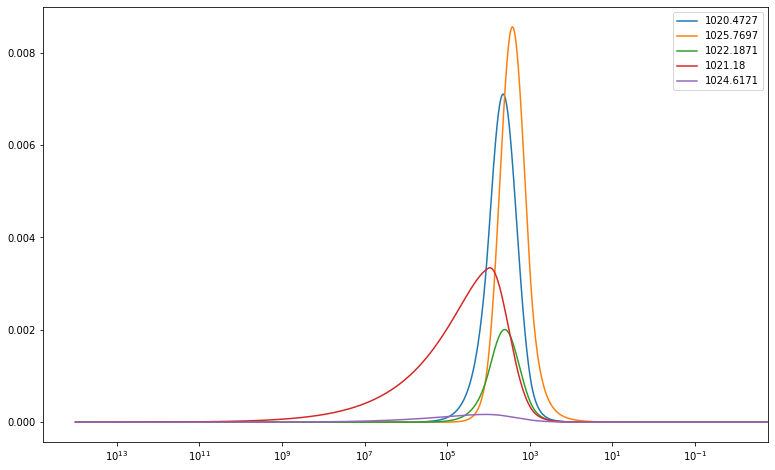

In [189]:
fig, ax = plt.subplots(figsize=(13,8))

for bg,sample in zip(sample_bgs_2_sig,samples_2_sig):
    ax.semilogx(bg['z'],(bg['(.)rho_gdm'])/bg['(.)rho_crit'],label=sample['chi2__CMB'])
    ax.invert_xaxis()

ax.legend()
fig.show()

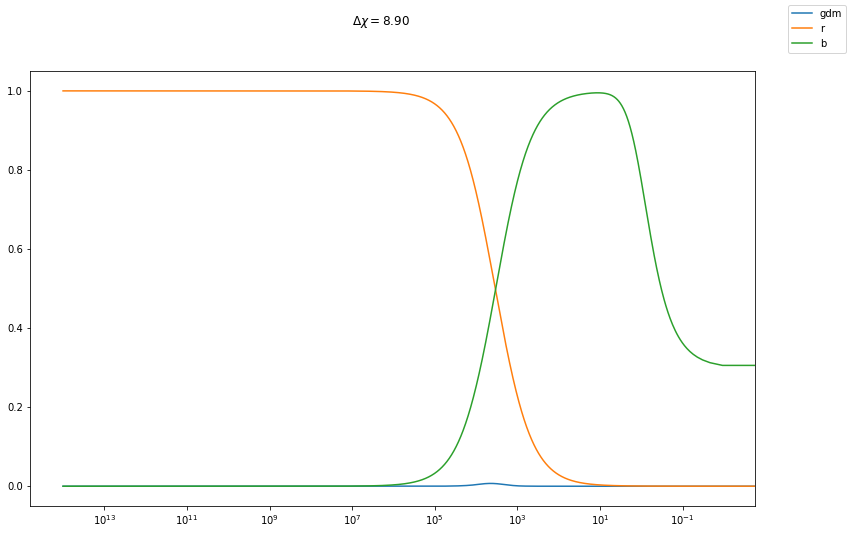

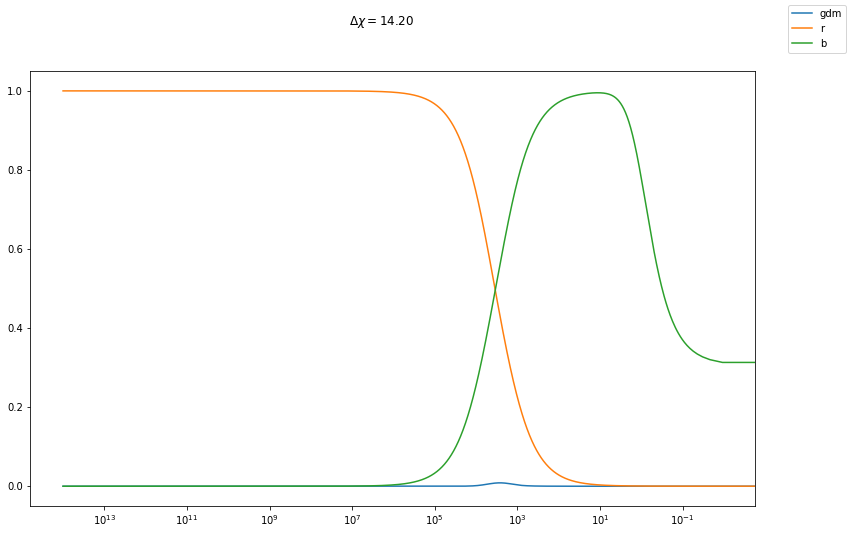

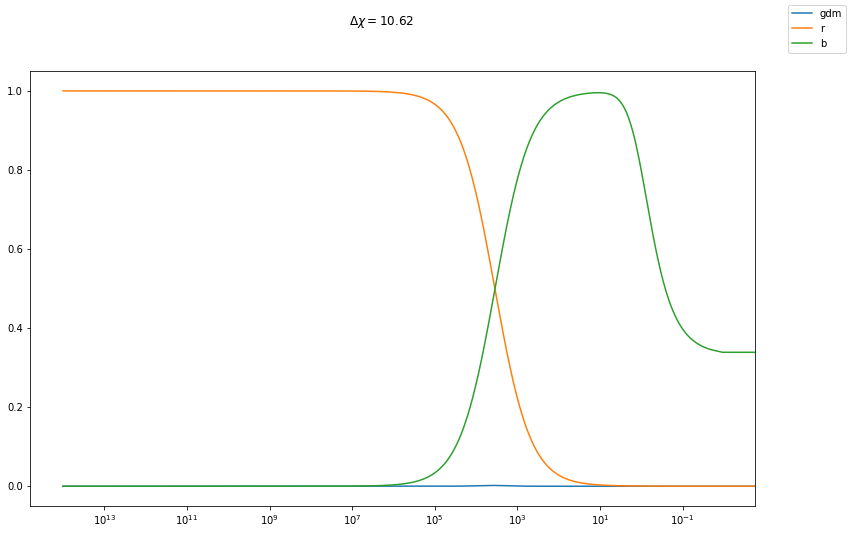

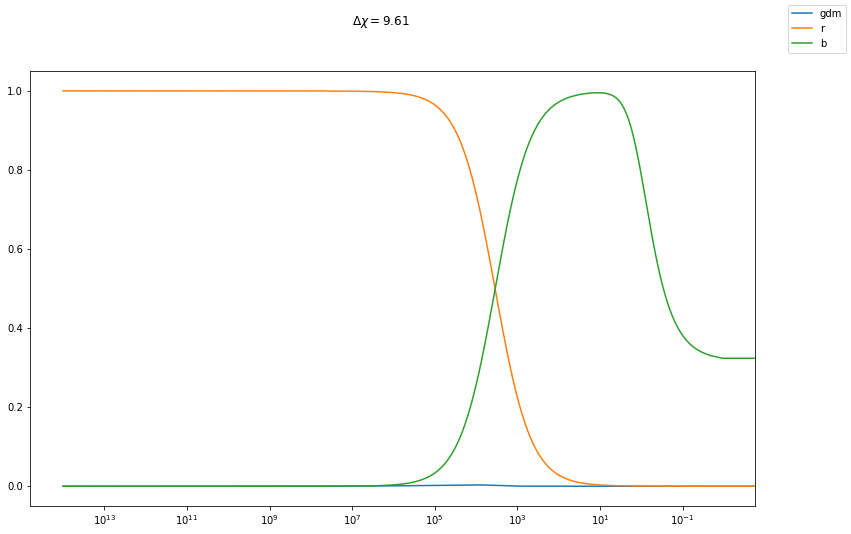

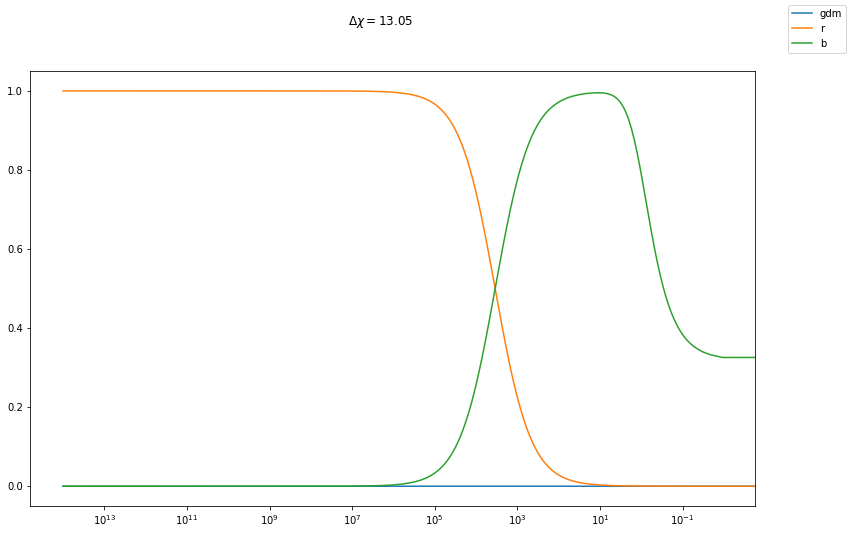

In [190]:
for sample_idx in range(n_show_samples):
    Omega_plot = make_Omega_plot(sample_bgs_2_sig[sample_idx])
    Omega_plot.suptitle(r'$\Delta \chi=$'+f"{samples_2_sig[sample_idx]['chi2__CMB']-best_fit_sample['chi2__CMB']:.2f}")
    Omega_plot.show()

In [178]:
gdm_samples.confidence('chi2__CMB',0.95)

1026.3549

In [180]:
gdm_samples.confidence('chi2__CMB',0.9)

1024.203

In [13]:
np.nan/0

ZeroDivisionError: float division by zero

In [14]:
np.sqrt(-1)

/tmp/ipykernel_5140/3438155168.py:1: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(-1)


nan